# Imports / paths

In [1]:
! pip install torch-summary

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import json
from torchsummary import summary
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_fscore_support
import librosa.display
import math
import os
from textwrap import dedent

IRMAS_PATH = "/content/drive/MyDrive/ITCS 5156 project/IRMAS dataset/IRMAS-TrainingData/"
JSON_PATH = "/content/drive/MyDrive/ITCS 5156 project/IRMAS dataset/json_files/"
filename = "irmas_data_mfcc13_hop_length256_n_fft2048.json"

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# Dataset / Preprocessing

In [3]:
class IRMASDataset(Dataset):
  def __init__(self, JSON_PATH=JSON_PATH, filename=filename, transform=None):
    with open(JSON_PATH + filename, "r") as f:
      self.irmas_data = json.load(f)
    self.metadata = self.irmas_data.pop('metadata') 
    self.instruments = ["cel", "cla", "flu", "gac", "gel", "org", "pia", "sax",
    "tru", "vio", "voi"]
    self.encoder = LabelEncoder()
    self.encoder.fit(self.instruments)

  def __len__(self):
    return len(self.irmas_data)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = np.array(idx.tolist())

    mfccs = np.array(self.irmas_data[str(idx)]['mfccs'])[np.newaxis,...]

    primary_instrument = self.encoder.transform(
      [np.array(self.irmas_data[str(idx)]['primary_instrument'])]
    )
    sample = {'mfccs': mfccs, 'instrument': primary_instrument, 'metadata': self.metadata}
    return sample

def prep_dataset(filename=filename, val_split=0.2, batch_size=1):

  dataset = IRMASDataset(JSON_PATH=JSON_PATH, filename=filename)
  train_set, val_set = random_split(dataset, [round(len(dataset) * (1-val_split)), round(len(dataset)*val_split)])

  train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1)
  val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=1)

  return train_loader, val_loader, dataset

# Architectures

In [4]:
################################################################################
#################################### BLOCKS ####################################
################################################################################

class ConvBlock(nn.Module):

	def __init__(self, in_channels, out_channels, conv_kernel_size=3,
							 conv_stride=1, conv_padding=0,
							 inc_pool=True, pool_kernel_size=2, pool_stride=2):
		"""Convolutional block with conv2d, linear activation, max pooling, 
			and batch norm
		:param in_channels:
		:param out_channels:
		:param conv_kernel_size:
		:param conv_stride:
		:param conv_padding:
		:param inc_pool: If true, includes a max pooling layer

		The following params only matter if inc_pool is True
		:param pool_kernel_size:
		:param pool_stride:
		"""
		super(ConvBlock, self).__init__()

		# construct sequential blocks
		if inc_pool:
			self.conv_block = nn.Sequential(
						nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
										kernel_size=conv_kernel_size, stride=conv_stride,
											padding=conv_padding),
						nn.ReLU(),
						nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride),
						nn.BatchNorm2d(num_features=out_channels)
				)
		else:
			self.conv_block = nn.Sequential(
						nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
											kernel_size=conv_kernel_size, stride=conv_stride,
											padding=conv_padding),
						nn.ReLU(),
						nn.BatchNorm2d(num_features=out_channels)
				) 

	# run forward
	def forward(self, x):
		x = self.conv_block(x)
		return x

class LinearBlock(nn.Module):

	def __init__(self, in_features, out_features, dropout_prob=0):
		"""Linear block with dense layer, relu, batch norm, then dropout
		:param in_features:
		:param out_features:
		:param dropout_prob: Set to 0 for no dropout layer
		"""

		super(LinearBlock, self).__init__()
		self.linear_block = nn.Sequential(
				nn.Linear(in_features=in_features, out_features=out_features),
				nn.ReLU(),
				nn.BatchNorm1d(num_features=out_features),
				nn.Dropout(p=dropout_prob)
		)

	def forward(self, x):
		x = self.linear_block(x)
		return x

class HeadBlock(nn.Module):

	def __init__(self, in_features):
		"""Linear block with softmax output.
		NOTE: no longer using softmax output since the CrossEntropyLoss handles that
		:param in_features:
		out_features is fixed to 11 to corrospond to the number of classes
		"""
		super(HeadBlock, self).__init__()
		self.head_block = nn.Sequential(
				nn.Linear(in_features=in_features, out_features=11),
				#nn.Softmax()
		)

	def forward(self, x):
		x = self.head_block(x)
		return x

################################################################################
################################### NETWORKS ###################################
################################################################################
class Conv1Layer(nn.Module):

	def __init__(self, single_sample, channels=[8],
							 conv_kernel_sizes=[3],
							 conv_strides=[1],
							 conv_paddings=[0],
							 pool_masks=[True],
							 pool_kernel_sizes=[2],
							 pool_strides=[2],
							 linear_features=[128, 64],
							 dropout_probs=[0, 0]):

		"""Convolutional neural network with 1 conv layer and 3 linear layers.
		All hyperparams are flexible and initialized using lists (or array-likes).
		The nth entry in each list corrosponds to the nth layer

		:param single_sample: a sample mfcc to run through the network on init to 
		get layer sizes
		:param channels:
		:param conv_kernel_sizes:
		:param conv_paddings:
		:param pool_masks: array of booleans to control max pooling
			ex: [False, True] means no max pooling after 1st layer, but max pooling 
			after second layer. Other hyperparams for maxpooling must be passed so
			that alignment is consistent. ex: in the [False, True] example, one could
			pass [3, 2] for pool kernel size. The 3 does nothing but the 2 will use 
			a pool kernel size of 2. Passing only [2] will result in an error even if 
			there is only one maxpool layer.
		:param pool_kernel_sizes:
		:param pool_strides:
		:param linear features: output sizes for linear layers (input size
			determined on init by one_mfcc)
		:param dropout_probs:

		"""
		super(Conv1Layer, self).__init__()

		# convolutional blocks
		self.conv1 = ConvBlock(in_channels=1, out_channels=channels[0],
													 conv_kernel_size=conv_kernel_sizes[0],
													 conv_stride=conv_strides[0],
													 conv_padding=conv_paddings[0],
													 inc_pool=pool_masks[0],
													 pool_kernel_size=pool_kernel_sizes[0],
													 pool_stride=pool_strides[0])
	
		# run a single sample through the convolutional block to get output size
		# https://discuss.pytorch.org/t/convolution-and-pooling-layers-need-a-method-to-calculate-output-size/21895
		sample_output1 = self.conv1(torch.from_numpy(
				single_sample[np.newaxis,...].astype(np.float32)))
	
		sample_flattened = sample_output1.flatten(start_dim=1)
 
		# linear blocks
		self.linear1 = LinearBlock(in_features=(sample_flattened.shape[1]),
																						out_features=(linear_features[0]),
																						dropout_prob=dropout_probs[0])
		self.linear2 = LinearBlock(in_features=(linear_features[0]),
																						out_features=(linear_features[1]),
																						dropout_prob=dropout_probs[1])
		self.head = HeadBlock(in_features=(linear_features[1]))

	def forward(self, x):
		x = self.conv1(x)
		x = x.flatten(start_dim=1)
		x = self.linear1(x)
		x = self.linear2(x)
		x = self.head(x)
		return x

class Conv3Layer(nn.Module):
	def __init__(self, single_sample, channels=[8, 16, 32],
							 conv_kernel_sizes=[3, 3, 3],
							 conv_strides=[1, 1, 1],
							 conv_paddings=[0, 0, 1,],
							 pool_masks=[True, False, False],
							 pool_kernel_sizes=[2, 2, 2],
							 pool_strides=[2, 2, 2],
							 linear_features=[128, 64],
							 dropout_probs=[0, 0]):

		"""Convolutional neural network with 3 conv layers and 3 linear layers.
		All hyperparams are flexible and initialized using lists (or array-likes).
		The nth entry in each list corrosponds to the nth layer

		:param single_sample: a sample mfcc to run through the network on init to 
		get layer sizes
		:param channels:
		:param conv_kernel_sizes:
		:param conv_paddings:
		:param pool_masks: array of booleans to control max pooling
			ex: [False, True] means no max pooling after 1st layer, but max pooling 
			after second layer. Other hyperparams for maxpooling must be passed so
			that alignment is consistent. ex: in the [False, True] example, one could
			pass [3, 2] for pool kernel size. The 3 does nothing but the 2 will use 
			a pool kernel size of 2. Passing only [2] will result in an error even if 
			there is only one maxpool layer.
		:param pool_kernel_sizes:
		:param pool_strides:
		:param linear features: output sizes for linear layers (input size
			determined on init by one_mfcc)
		:param dropout_probs:
		"""

		super(Conv3Layer, self).__init__()

		self.conv1 = ConvBlock(in_channels=1, out_channels=channels[0],
													 conv_kernel_size=conv_kernel_sizes[0],
													 conv_stride=conv_strides[0],
													 conv_padding=conv_paddings[0],
													 inc_pool=pool_masks[0],
													 pool_kernel_size=pool_kernel_sizes[0],
													 pool_stride=pool_strides[0])
		
		self.conv2 = ConvBlock(in_channels=channels[0], out_channels=channels[1],
													 conv_kernel_size=conv_kernel_sizes[1],
													 conv_stride=conv_strides[1],
													 conv_padding=conv_paddings[1],
													 inc_pool=pool_masks[1],
													 pool_kernel_size=pool_kernel_sizes[1],
													 pool_stride=pool_strides[1])

		self.conv3 = ConvBlock(in_channels=channels[1], out_channels=channels[2],
													 conv_kernel_size=conv_kernel_sizes[2],
													 conv_stride=conv_strides[2],
													 conv_padding=conv_paddings[2],
													 inc_pool=pool_masks[2],
													 pool_kernel_size=pool_kernel_sizes[2],
													 pool_stride=pool_strides[2])
		
		# calculate size for linear layers
		sample_output1 = self.conv1(torch.from_numpy(
				single_sample[np.newaxis,...].astype(np.float32)))
		sample_output2 = self.conv2(sample_output1)
		sample_output3 = self.conv3(sample_output2)
		sample_flattened = sample_output3.flatten(start_dim=1)

		# linear blocks
		self.linear1 = LinearBlock(in_features=(sample_flattened.shape[1]),
																						out_features=(linear_features[0]),
																						dropout_prob=dropout_probs[0])
		self.linear2 = LinearBlock(in_features=(linear_features[0]),
																						out_features=(linear_features[1]),
																						dropout_prob=dropout_probs[1])
		self.head = HeadBlock(in_features=(linear_features[1]))
	
	def forward(self, x):
		x = self.conv1(x)
		x = self.conv2(x)
		x = self.conv3(x)
		x = x.flatten(start_dim=1)
		x = self.linear1(x)
		x = self.linear2(x)
		x = self.head(x)
		return x

class Conv5Layer(nn.Module):
	def __init__(self, single_sample, channels= [8, 8, 32, 32, 64],
							 conv_kernel_sizes=[3, 3, 3, 3, 3],
							 conv_strides=[1, 1, 1, 1, 1],
							 conv_paddings=[0, 0, 1, 1, 1],
							 pool_masks=[True, False, False, False, False],
							 pool_kernel_sizes=[2, 2, 2, 2, 2],
							 pool_strides=[2, 2, 2, 2, 2],
							 linear_features=[128, 64],
							 dropout_probs=[0, 0]):
		
		"""Convolutional neural network with 3 conv layers and 3 linear layers.
		All hyperparams are flexible and initialized using lists (or array-likes).
		The nth entry in each list corrosponds to the nth layer

		:param single_sample: a sample mfcc to run through the network on init to 
		get layer sizes
		:param channels:
		:param conv_kernel_sizes:
		:param conv_paddings:
		:param pool_masks: array of booleans to control max pooling
			ex: [False, True] means no max pooling after 1st layer, but max pooling 
			after second layer. Other hyperparams for maxpooling must be passed so
			that alignment is consistent. ex: in the [False, True] example, one could
			pass [3, 2] for pool kernel size. The 3 does nothing but the 2 will use 
			a pool kernel size of 2. Passing only [2] will result in an error even if 
			there is only one maxpool layer.
		:param pool_kernel_sizes:
		:param pool_strides:
		:param linear features: output sizes for linear layers (input size
			determined on init by one_mfcc)
		:param dropout_probs:
		"""

		super(Conv5Layer, self).__init__()

		# convolutional layers
		self.conv1 = ConvBlock(in_channels=1, out_channels=channels[0],
													 conv_kernel_size=conv_kernel_sizes[0],
													 conv_stride=conv_strides[0],
													 conv_padding=conv_paddings[0],
													 inc_pool=pool_masks[0],
													 pool_kernel_size=pool_kernel_sizes[0],
													 pool_stride=pool_strides[0])
		
		self.conv2 = ConvBlock(in_channels=channels[0], out_channels=channels[1],
													 conv_kernel_size=conv_kernel_sizes[1],
													 conv_stride=conv_strides[1],
													 conv_padding=conv_paddings[1],
													 inc_pool=pool_masks[1],
													 pool_kernel_size=pool_kernel_sizes[1],
													 pool_stride=pool_strides[1])

		self.conv3 = ConvBlock(in_channels=channels[1], out_channels=channels[2],
													 conv_kernel_size=conv_kernel_sizes[2],
													 conv_stride=conv_strides[2],
													 conv_padding=conv_paddings[2],
													 inc_pool=pool_masks[2],
													 pool_kernel_size=pool_kernel_sizes[2],
													 pool_stride=pool_strides[2])
		
		self.conv4 = ConvBlock(in_channels=channels[2], out_channels=channels[3],
													 conv_kernel_size=conv_kernel_sizes[3],
													 conv_stride=conv_strides[3],
													 conv_padding=conv_paddings[3],
													 inc_pool=pool_masks[3],
													 pool_kernel_size=pool_kernel_sizes[3],
													 pool_stride=pool_strides[3])
		
		self.conv5 = ConvBlock(in_channels=channels[3], out_channels=channels[4],
													 conv_kernel_size=conv_kernel_sizes[4],
													 conv_stride=conv_strides[4],
													 conv_padding=conv_paddings[4],
													 inc_pool=pool_masks[4],
													 pool_kernel_size=pool_kernel_sizes[4],
													 pool_stride=pool_strides[4])
		
		# calculate size for linear layers
		sample_output1 = self.conv1(torch.from_numpy(
				single_sample[np.newaxis,...].astype(np.float32)))
		sample_output2 = self.conv2(sample_output1)
		sample_output3 = self.conv3(sample_output2)
		sample_output4 = self.conv4(sample_output3)
		sample_output5 = self.conv5(sample_output4)
		sample_flattened = sample_output5.flatten(start_dim=1)


		# linear blocks
		self.linear1 = LinearBlock(in_features=(sample_flattened.shape[1]),
																						out_features=(linear_features[0]),
																						dropout_prob=dropout_probs[0])
		self.linear2 = LinearBlock(in_features=(linear_features[0]),
																						out_features=(linear_features[1]),
																						dropout_prob=dropout_probs[1])
		self.head = HeadBlock(in_features=(linear_features[1]))
	
	def forward(self, x):
		x = self.conv1(x)
		x = self.conv2(x)
		x = self.conv3(x)
		x = self.conv4(x)
		x = self.conv5(x)
		x = x.flatten(start_dim=1)
		x = self.linear1(x)
		x = self.linear2(x)
		x = self.head(x)
		return x

### This one doesn't seem to be working yet
class ConvNLayer(nn.Module):
	def __init__(self, single_sample, 

		num_conv_layers=2,
		channels=[8, 16],
		conv_kernel_sizes=[3, 3],
		conv_strides=[1, 1],
		conv_paddings=[1, 1],
		pool_masks=[True, True],
		pool_kernel_sizes=[2, 2],
		pool_strides=[2, 2],
		
		num_linear_layers=2,
		linear_features=[128, 64],
		dropout_probs=[0, 0]
		):
		"""Convolutional neural net with an arbitrary number of convolutional layers
		"""
		super(ConvNLayer, self).__init__()

		self.num_conv_layers = num_conv_layers
		self.num_linear_layers = num_linear_layers

		# prepend 1 to input channels since there is only one
		channels.insert(0, 1)

		# define list of convolutional layers
		self.conv_layers = [
			ConvBlock(
				in_channels = channels[i],
				out_channels = channels[i+1],
				conv_kernel_size = conv_kernel_sizes[i],
				conv_stride = conv_strides[i],
				conv_padding = conv_paddings[i],
				inc_pool = pool_masks[i],
				pool_kernel_size = pool_kernel_sizes[i],
				pool_stride = pool_strides[i])
		for i in range(self.num_conv_layers)]

		# calculate size of linear layers
		sample = torch.from_numpy(
			single_sample[np.newaxis,...].astype(np.float32)
		)

		for i in range(self.num_conv_layers):
			sample = self.conv_layers[i](sample)

		sample_flattened = sample.flatten(start_dim=1)

		# prepend shape of input to linear block
		linear_features.insert(0, sample_flattened.shape[1])

		# define list of linear layers
		self.linear_layers = [
			LinearBlock(
				in_features = (linear_features[i]),
				out_features = (linear_features[i+1]),
				dropout_prob = dropout_probs[i])
			for i in range(self.num_linear_layers)
		]

		# define output head
		self.head = HeadBlock(in_features=(linear_features[-1]))

	def forward(self, x):
		for i in range(self.num_conv_layers):
			print(self.conv_layers[i])
			x = self.conv_layers[i](x)
		
		x = x.flatten(start_dim=1)

		for i in range(self.num_linear_layers):
			x = self.linear_layers[i](x)
		
		x = self.head(x)
		return x

models_dict = {
	"Conv_1_layer": Conv1Layer,
	"Conv_3_layer": Conv3Layer,
	"Conv_5_layer": Conv5Layer,
	"Conv_N_layer": ConvNLayer,
}

# Get a sample & test

In [5]:
train_loader, val_loader, dataset = prep_dataset(
      filename=filename, batch_size=5, val_split=0.2)
single_sample = dataset[0]

one_mfcc = np.array(single_sample['mfccs'])
one_mfcc.shape

(1, 13, 517)

# Train Loop

In [7]:
def train_model(filename="irmas_data_mfcc13_hop_length256_n_fft2048", model_id="TestModel",
                num_epochs=2, interval=16, lr=0.001, batch_size=64,
                val_split=0.2, save_checkpoint=False, checkpoint_path="",
                notes="", checkpoint_name="utitled.pt", criterion=torch.nn.NLLLoss(),
                patience=None, min_epochs=5, buffer=0.05, dropout_prob=None,
                model_args={}, experiment_params={}):
  """Model training loop for music analysis project. Currently, this loop only supports
  models that take input in the shape [mini_batch, channels, L, W].

  :param filename:
  :param model_id:
  :param num_epochs:
  :param interval:
  :param lr:
  :param batch_size:
  :param val_split:
  :param save_checkpoint:
  :param checkpoint_path:
  :param notes:
  :param checkpoint name:
  :param criterion:
  :param patience: If validation loss does not improve over this many epochs, stop training
  """

  # Initialize device
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print("device: ", device)
  
  # get train and validation set, print metadata
  train_loader, val_loader, dataset = prep_dataset(
      filename=filename, batch_size=batch_size, val_split=val_split)

  print("dataset metadata: ", dataset.metadata)

  # param for early stopping
  stop_next = False

  # get number of train and validdation samples
  train_samples = round(len(dataset) * (1-val_split))
  val_samples = round(len(dataset)*val_split)

  # initialize loss history and accuracy history for each epoch
  # this is the stored history for the train and validation metrics
  epoch_hist = []
  avg_train_loss_hist = []  # training loss for each epoch
  std_train_loss_hist = []
  avg_val_loss_hist = []    # validation loss for each epoch
  std_val_loss_hist = []
  train_acc_hist = []       # training accuracy for each epoch
  train_prec_hist = []
  train_recall_hist = []
  train_f1_hist = []
  val_acc_hist = []         # validation accuracy for each epoch
  val_prec_hist = []
  val_recall_hist = []
  val_f1_hist = []


  # get one sample to load initial shape for neural net
  single_sample = dataset[0]
  one_mfcc = np.array(single_sample['mfccs'])
  print("train model: data loaders initialized")
  print("sample shape = ", one_mfcc.shape)

  # initialize model
  #model = models_dict[model_id](one_mfcc, dropout_prob).to(device)
  model = models_dict[model_id](one_mfcc, **model_args).to(device)
  print("model loaded")
  summary_str = str(summary(model, one_mfcc.shape, verbose=0))

  print(summary_str)

  # initialize optimizer and criterion
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  print("criterion: ", criterion)

  n_train_steps = len(train_loader)
  n_val_steps = len(val_loader)

  ### loop epochs
  for epoch in range(num_epochs):
    print("\n\ntraining epoch: ", epoch)
    epoch_hist.append(epoch+1)
    epoch_time_start = time.time()
    interval_time_start = time.time()
    model.to(device)

    # at the start of the epoch, set all tracked params to zero
    train_losses = []
    val_losses = []
    inter_epoch_loss = []
    train_num_correct = 0
    val_num_correct = 0

    # set params to be tracked within the epoch ("inter-epoch")
    # these will be outputted at each interval, but not saved
    inter_epoch_num_correct = 0

    ### Training loop
    model.train()
    print("model set to train")
    train_preds = []
    train_targets = []
    for i, sample in enumerate(train_loader):

      # prep input and target tensor
      input_tensor = torch.from_numpy(
          np.array(sample['mfccs']).astype(np.float32)).to(device)
      targets = sample['instrument']
      target_tensor = torch.squeeze(torch.tensor(targets), dim=1)
      #print("target tensor after processing: ", target_tensor)
      train_targets.extend(list(targets.numpy()))
      # make predictions
      predictions = torch.squeeze(model(input_tensor).to('cpu'), dim=1)

      # compute loss and do back-propagation
      loss = criterion(predictions, target_tensor)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # append the loss to overall 
      train_losses.append(loss.item())
      inter_epoch_loss.append(loss.item())

      # compute accuracies
      with torch.no_grad():
        predictions_arr = predictions.numpy()
        preds = [np.argmax(predictions_arr[i]) 
          for i in range(len(target_tensor))]
        # inter-epoch accuracy (reset this at each interval)
        inter_epoch_num_correct += np.sum([target_tensor[i] == np.argmax(predictions[i])
          for i in range(len(target_tensor))])
        
        # epoch accuracy (this is tracked and saved)
        train_num_correct += np.sum([target_tensor[i] == np.argmax(predictions[i])
          for i in range(len(target_tensor))])
        #print("debugging in epoch: preds = ", preds)
        train_preds.extend(preds)

      # print step info
      if i % interval == 0:

        # time elapsed
        interval_time_end = time.time()

        # compute mean and std of losses
        inter_epoch_loss_avg = np.mean(inter_epoch_loss)
        inter_epoch_loss_std = np.std(inter_epoch_loss)
        
        # compute inter-epoch accuracy
        # note, this accuracy may be incorrect at the end of each epoch
        # when the batch size is slightly different
        acc = inter_epoch_num_correct / (interval*batch_size)
        print(f"Epoch [{epoch+1}/{num_epochs}], step [{i+1}/{n_train_steps}], ",
              f"Loss: {inter_epoch_loss_avg:.4f} +/- {inter_epoch_loss_std:.4f}, ",
              f"accuracy: {acc}, "
              f"time elapsed = {interval_time_end-interval_time_start}s")
        interval_time_start = time.time()

        # reset inter_epoch metrics
        inter_epoch_num_correct = 0
        inter_epoch_loss = []

    ### training loop finished
    # append the accuracy
    train_acc_hist.append(train_num_correct / train_samples)

    # calculate classification metrics
    train_targets = np.array(train_targets).ravel()
    train_preds = np.array(train_preds).ravel()
    # print("debugging: train targets: ", train_targets)
    # print("debugging: train predictions: ", train_preds)
    train_prec, train_recall, train_f1, _ = precision_recall_fscore_support(train_targets, train_preds,
                                                      average='micro')

    ### Validation loop
    model.eval()
    print("model set to eval")
    val_preds = []
    val_targets = []
    with torch.no_grad():

      num_correct = 0
      for i, sample in enumerate(val_loader):
        
        # prep input and target tensor
        input_tensor = torch.from_numpy(
            np.array(sample['mfccs']).astype(np.float32)).to(device)
        targets = sample['instrument']
        val_targets.extend(list(targets.numpy()))
        target_tensor = torch.squeeze(torch.tensor(targets), dim=1)
        #target_tensor = torch.squeeze(torch.tensor(sample['instrument']), dim=1)

        # make predictions
        predictions = torch.squeeze(model(input_tensor).to('cpu'), dim=1)

        # compute and append losses
        loss = criterion(predictions, target_tensor)
        val_losses.append(loss.item())

        predictions_arr = predictions.numpy()
        preds = [np.argmax(predictions_arr[i]) 
          for i in range(len(target_tensor))]
        val_preds.extend(preds)
        # get num correct to comput accuracy
        val_num_correct += np.sum([target_tensor[i] == np.argmax(predictions[i])
          for i in range(len(target_tensor))])
      
      ### validation loop finished. prep model and metrics for saving
      # calculate validation accuracy
      val_acc_hist.append(val_num_correct / val_samples)
      val_targets = np.array(val_targets).ravel()
      val_preds = np.array(val_preds).ravel()
      # print("debugging: train targets: ", train_targets)
      # print("debugging: train predictions: ", train_preds)
      val_prec, val_recall, val_f1, _ = precision_recall_fscore_support(val_targets, val_preds,
                                                      average='micro')
      # calculate mean and standard deviation of losses
      avg_train_loss = np.mean(train_losses)
      std_train_loss = np.std(train_losses)
      avg_val_loss = np.mean(val_losses)
      std_val_loss = np.std(val_losses)

      # append mean and standard deviation to histories
      avg_train_loss_hist.append(avg_train_loss) 
      std_train_loss_hist.append(std_train_loss)  
      avg_val_loss_hist.append(avg_val_loss)
      std_val_loss_hist.append(std_val_loss)

      train_prec_hist.append(train_prec)
      train_recall_hist.append(train_recall)
      train_f1_hist.append(train_f1)

      val_prec_hist.append(val_prec)
      val_recall_hist.append(val_recall)
      val_f1_hist.append(val_f1)
    
    ### epoch training finished, output results and save checkpoint

    # text output
    epoch_time_end = time.time()
    print(f"\nEPOCH FINISHED: , ",
          f"training: acc = {train_acc_hist[-1]:.3f}, ",
          f"precision = {train_prec_hist[-1]:.3f}",
          f"recall = {train_recall_hist[-1]:.3f}",
          f"f1 = {train_f1_hist[-1]:.3f}",
          f"::: val: acc = {val_acc_hist[-1]:.3f}, ",
          f"precision = {val_prec_hist[-1]:.3f}",
          f"recall = {val_recall_hist[-1]:.3f}",
          f"time elapsed = {epoch_time_end-epoch_time_start}s")
    
    # make a plot
    plt.close("all")
    fig, ax = plt.subplots(ncols=2, figsize=[15, 5])
    #ax.scatter(epoch_hist, avg_train_loss_hist, c='r', label="train loss", )
    ax[0].plot(epoch_hist, avg_train_loss_hist, 'ro--', label="train loss", )
    ax[0].errorbar(x=epoch_hist, y=avg_train_loss_hist, yerr=std_train_loss_hist,
                capsize=5, ls='none', color='r')

    # ax.scatter(epoch_hist, avg_val_loss_hist, c='b', label="val loss", )
    ax[0].plot(epoch_hist, avg_val_loss_hist, 'ko--', label="val loss", )
    ax[0].errorbar(x=epoch_hist, y=avg_val_loss_hist, yerr=std_val_loss_hist,
                capsize=5, ls='none', color='k')
    
    ax[0].set_xlabel("epoch")
    ax[0].set_ylabel("loss")
    ax[0].legend()
    

    ax[1].plot(epoch_hist, train_acc_hist, 'r-.', label="train accuracy", 
                  marker='s')

    ax[1].plot(epoch_hist, val_acc_hist, 'k-.', label="val accuracy",
                  marker='s')
    ax[1].set_ylabel("accuracy")
    ax[1].set_xlabel("epoch")
    ax[1].set_ylim([0, 1])
    ax[1].legend()
    fig.tight_layout(pad=1)
    plt.show(block=False)

    # check validation loss if we need to stop training
    # print("validation loss hist: ", avg_val_loss_hist)
    # if (epoch > patience) and all(avg_val_loss_hist[-1-i] >= avg_val_loss_hist[-1-i-1]
    #                               for i in range(patience)):
    model.to('cpu')
    if (epoch > min_epochs) and (
        #avg_val_loss_hist[-1] > (std_val_loss_hist[-1] + std_train_loss_hist[-1] + avg_train_loss_hist[-1] + buffer)):
        (avg_val_loss_hist[-1] - avg_train_loss_hist[-1] + buffer) > (std_train_loss_hist[-1] + std_val_loss_hist[-1])):
        #avg_val_loss_hist[-1] > (std_val_loss_hist[-1] + std_train_loss_hist[-1] + buffer)):
                    # and any(avg_val_loss_hist[-1-i] >= avg_val_loss_hist[-1-i-1]
                    #                                   for i in range(patience)):
      # save model
      # TODO: refactor this so torch.save isn't repeated
      if save_checkpoint:
        notes = notes + "\n\n stopped early"
        torch.save({
            'filename': filename,
            'epochs': epoch_hist,
            'model_id': model_id,
            'model_state_dict': model.state_dict(),
            'model_args': model_args,
            'metrics':{
              'avg_train_loss_hist': avg_train_loss_hist,
              'std_train_loss_hist': std_train_loss_hist,
              'avg_val_loss_hist': avg_val_loss_hist,
              'std_val_loss_hist': std_val_loss_hist,
              'train_acc_hist': train_acc_hist,
              'train_prec_hist': train_prec_hist,
              'train_recall_hist': train_recall_hist,
              'train_f1_hist': train_f1_hist,
              'val_acc_hist': val_acc_hist,
              'val_prec_hist': val_prec_hist,
              'val_recall_hist': val_recall_hist,
              'val_f1_hist': val_f1_hist,},
            'dataset_info': dataset.metadata,
            'notes': notes,
            'summary': summary_str,
            'experiment_params': experiment_params,
        }, checkpoint_path+checkpoint_name)
        print("model saved")

      if stop_next:
        print("stopping early")
        break
      else:
        stop_next = True
    else:
      stop_next = False

    # save model
    if save_checkpoint:
      torch.save({
            'filename': filename,
            'epochs': epoch_hist,
            'model_id': model_id,
            'model_state_dict': model.state_dict(),
            'model_args': model_args,
            'metrics':{
              'avg_train_loss_hist': avg_train_loss_hist,
              'std_train_loss_hist': std_train_loss_hist,
              'avg_val_loss_hist': avg_val_loss_hist,
              'std_val_loss_hist': std_val_loss_hist,
              'train_acc_hist': train_acc_hist,
              'train_prec_hist': train_prec_hist,
              'train_recall_hist': train_recall_hist,
              'train_f1_hist': train_f1_hist,
              'val_acc_hist': val_acc_hist,
              'val_prec_hist': val_prec_hist,
              'val_recall_hist': val_recall_hist,
              'val_f1_hist': val_f1_hist,},
            'dataset_info': dataset.metadata,
            'notes': notes,
            'summary': summary_str,
            'experiment_params': experiment_params,
        }, checkpoint_path+checkpoint_name)
      print("model saved")

# Initialize params

device:  cuda
dataset metadata:  {'n_fft': 2048, 'hop_length': 256, 'n_mfcc': 13, 'notes': 'optional notes not passed'}
train model: data loaders initialized
sample shape =  (1, 13, 517)
model loaded
Layer (type:depth-idx)                   Output Shape              Param #
├─ConvBlock: 1-1                         [-1, 8, 6, 258]           --
|    └─Sequential: 2-1                   [-1, 8, 6, 258]           --
|    |    └─Conv2d: 3-1                  [-1, 8, 13, 517]          80
|    |    └─ReLU: 3-2                    [-1, 8, 13, 517]          --
|    |    └─MaxPool2d: 3-3               [-1, 8, 6, 258]           --
|    |    └─BatchNorm2d: 3-4             [-1, 8, 6, 258]           16
├─ConvBlock: 1-2                         [-1, 8, 3, 129]           --
|    └─Sequential: 2-2                   [-1, 8, 3, 129]           --
|    |    └─Conv2d: 3-5                  [-1, 8, 6, 258]           584
|    |    └─ReLU: 3-6                    [-1, 8, 6, 258]           --
|    |    └─MaxPool2d: 3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch [1/100], step [1/84],  Loss: 2.6797 +/- 0.0000,  accuracy: 0.0029296875, time elapsed = 0.3110353946685791s
Epoch [1/100], step [17/84],  Loss: 2.6771 +/- 0.3392,  accuracy: 0.140625, time elapsed = 1.1728332042694092s
Epoch [1/100], step [33/84],  Loss: 2.2716 +/- 0.1196,  accuracy: 0.1884765625, time elapsed = 1.150024652481079s
Epoch [1/100], step [49/84],  Loss: 2.2105 +/- 0.0832,  accuracy: 0.240234375, time elapsed = 1.1294500827789307s
Epoch [1/100], step [65/84],  Loss: 2.1341 +/- 0.1133,  accuracy: 0.2568359375, time elapsed = 1.2221615314483643s
Epoch [1/100], step [81/84],  Loss: 2.1161 +/- 0.1140,  accuracy: 0.2587890625, time elapsed = 1.1878907680511475s
model set to eval


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:192: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



EPOCH FINISHED: ,  training: acc = 0.218,  precision = 0.218 recall = 0.218 f1 = 0.218 ::: val: acc = 0.232,  precision = 0.232 recall = 0.232 time elapsed = 7.956908464431763s


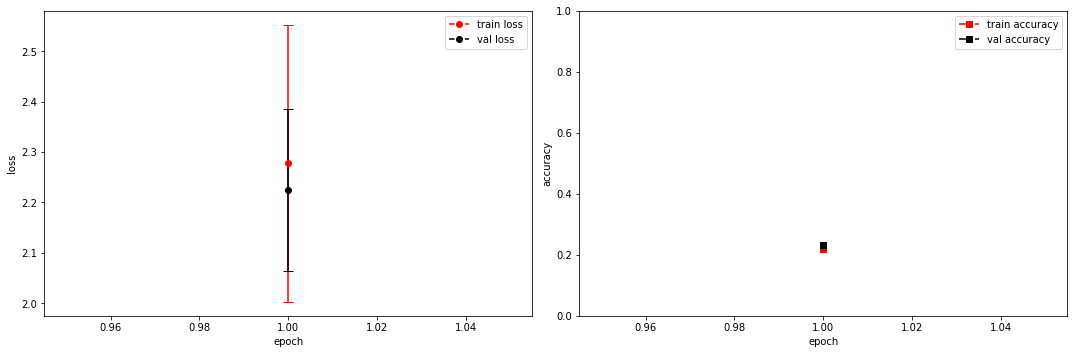

model saved


training epoch:  1
model set to train
Epoch [2/100], step [1/84],  Loss: 1.9897 +/- 0.0000,  accuracy: 0.01953125, time elapsed = 0.25136542320251465s
Epoch [2/100], step [17/84],  Loss: 2.0997 +/- 0.1205,  accuracy: 0.2734375, time elapsed = 1.1803874969482422s
Epoch [2/100], step [33/84],  Loss: 2.1660 +/- 0.0933,  accuracy: 0.2431640625, time elapsed = 1.1755542755126953s
Epoch [2/100], step [49/84],  Loss: 2.0878 +/- 0.0998,  accuracy: 0.2783203125, time elapsed = 1.159334659576416s
Epoch [2/100], step [65/84],  Loss: 2.1144 +/- 0.1259,  accuracy: 0.26171875, time elapsed = 1.1698098182678223s
Epoch [2/100], step [81/84],  Loss: 2.0829 +/- 0.1119,  accuracy: 0.267578125, time elapsed = 1.1898531913757324s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.265,  precision = 0.265 recall = 0.265 f1 = 0.265 ::: val: acc = 0.269,  precision = 0.269 recall = 0.269 time elapsed = 7.926013231277466s


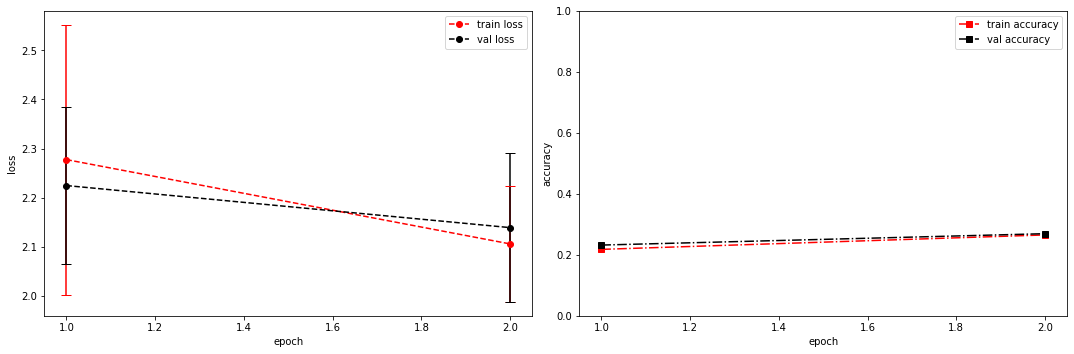

model saved


training epoch:  2
model set to train
Epoch [3/100], step [1/84],  Loss: 2.2226 +/- 0.0000,  accuracy: 0.0146484375, time elapsed = 0.23773479461669922s
Epoch [3/100], step [17/84],  Loss: 2.0275 +/- 0.1223,  accuracy: 0.2900390625, time elapsed = 1.1860673427581787s
Epoch [3/100], step [33/84],  Loss: 2.0547 +/- 0.1052,  accuracy: 0.2802734375, time elapsed = 1.1710853576660156s
Epoch [3/100], step [49/84],  Loss: 2.0748 +/- 0.1010,  accuracy: 0.28515625, time elapsed = 1.1581690311431885s
Epoch [3/100], step [65/84],  Loss: 1.9774 +/- 0.1290,  accuracy: 0.314453125, time elapsed = 1.148540735244751s
Epoch [3/100], step [81/84],  Loss: 1.9773 +/- 0.0932,  accuracy: 0.330078125, time elapsed = 1.141603708267212s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.300,  precision = 0.300 recall = 0.300 f1 = 0.300 ::: val: acc = 0.264,  precision = 0.264 recall = 0.264 time elapsed = 7.800458192825317s


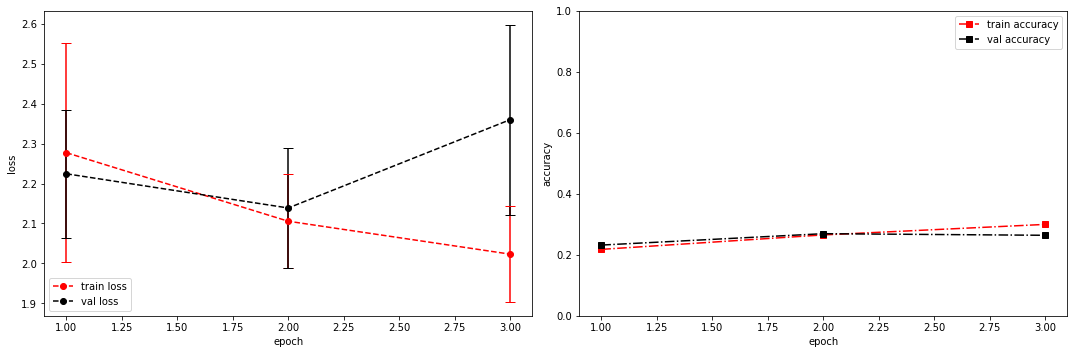

model saved


training epoch:  3
model set to train
Epoch [4/100], step [1/84],  Loss: 1.9948 +/- 0.0000,  accuracy: 0.0185546875, time elapsed = 0.25910401344299316s
Epoch [4/100], step [17/84],  Loss: 2.0061 +/- 0.1676,  accuracy: 0.30859375, time elapsed = 1.155304193496704s
Epoch [4/100], step [33/84],  Loss: 2.0203 +/- 0.0897,  accuracy: 0.3046875, time elapsed = 1.1803205013275146s
Epoch [4/100], step [49/84],  Loss: 1.9695 +/- 0.0924,  accuracy: 0.33203125, time elapsed = 1.1473612785339355s
Epoch [4/100], step [65/84],  Loss: 1.9410 +/- 0.0915,  accuracy: 0.3203125, time elapsed = 1.1416935920715332s
Epoch [4/100], step [81/84],  Loss: 2.0483 +/- 0.1297,  accuracy: 0.2939453125, time elapsed = 1.160539150238037s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.311,  precision = 0.311 recall = 0.311 f1 = 0.311 ::: val: acc = 0.306,  precision = 0.306 recall = 0.306 time elapsed = 7.837420701980591s


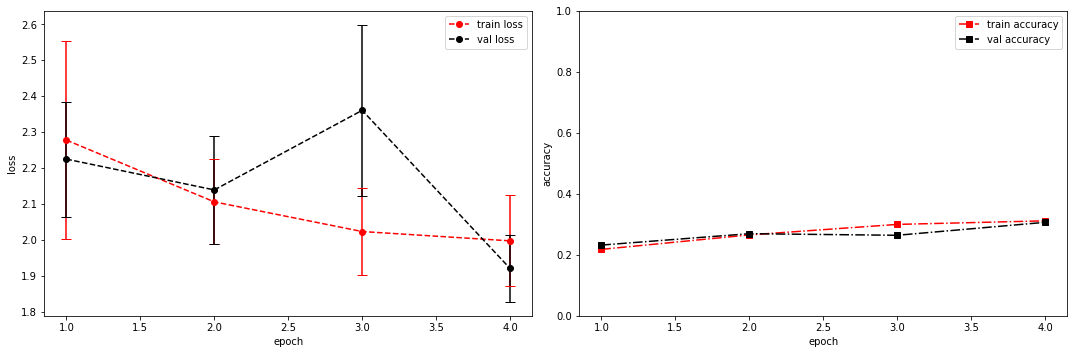

model saved


training epoch:  4
model set to train
Epoch [5/100], step [1/84],  Loss: 1.6574 +/- 0.0000,  accuracy: 0.0283203125, time elapsed = 0.2528860569000244s
Epoch [5/100], step [17/84],  Loss: 1.9385 +/- 0.1563,  accuracy: 0.337890625, time elapsed = 1.1759629249572754s
Epoch [5/100], step [33/84],  Loss: 1.9715 +/- 0.1183,  accuracy: 0.32421875, time elapsed = 1.1753013134002686s
Epoch [5/100], step [49/84],  Loss: 1.9942 +/- 0.1200,  accuracy: 0.3310546875, time elapsed = 1.155874490737915s
Epoch [5/100], step [65/84],  Loss: 1.9322 +/- 0.1512,  accuracy: 0.330078125, time elapsed = 1.1543936729431152s
Epoch [5/100], step [81/84],  Loss: 1.9016 +/- 0.1117,  accuracy: 0.3388671875, time elapsed = 1.163090705871582s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.333,  precision = 0.333 recall = 0.333 f1 = 0.333 ::: val: acc = 0.280,  precision = 0.280 recall = 0.280 time elapsed = 7.871294975280762s


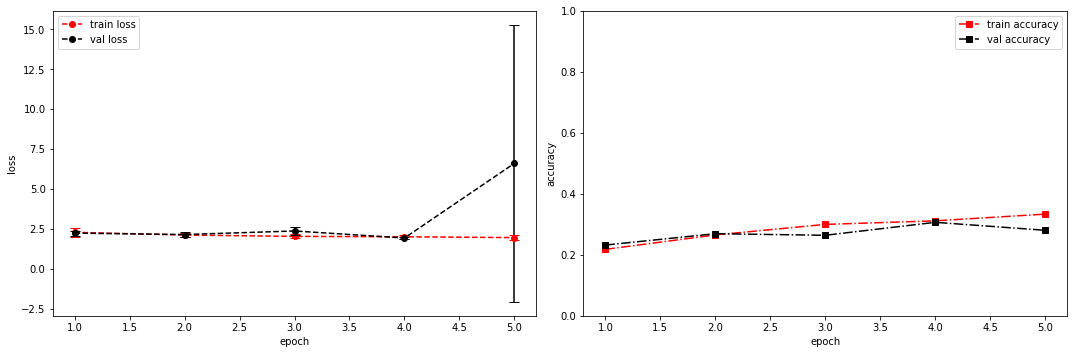

model saved


training epoch:  5
model set to train
Epoch [6/100], step [1/84],  Loss: 1.9235 +/- 0.0000,  accuracy: 0.0185546875, time elapsed = 0.24595022201538086s
Epoch [6/100], step [17/84],  Loss: 1.9291 +/- 0.2225,  accuracy: 0.369140625, time elapsed = 1.1758317947387695s
Epoch [6/100], step [33/84],  Loss: 1.9434 +/- 0.1151,  accuracy: 0.3173828125, time elapsed = 1.1855323314666748s
Epoch [6/100], step [49/84],  Loss: 1.9163 +/- 0.1239,  accuracy: 0.3369140625, time elapsed = 1.170074701309204s
Epoch [6/100], step [65/84],  Loss: 1.8778 +/- 0.1490,  accuracy: 0.3369140625, time elapsed = 1.2289047241210938s
Epoch [6/100], step [81/84],  Loss: 1.9171 +/- 0.1415,  accuracy: 0.3525390625, time elapsed = 1.1130573749542236s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.342,  precision = 0.342 recall = 0.342 f1 = 0.342 ::: val: acc = 0.323,  precision = 0.323 recall = 0.323 time elapsed = 7.894250869750977s


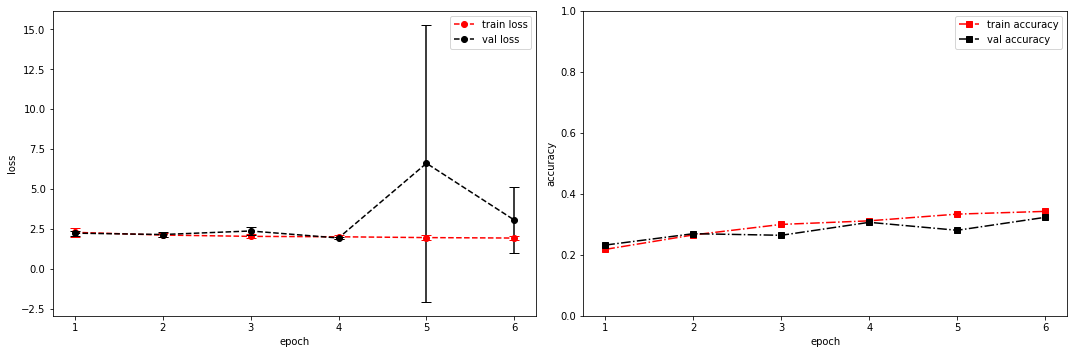

model saved


training epoch:  6
model set to train
Epoch [7/100], step [1/84],  Loss: 1.9922 +/- 0.0000,  accuracy: 0.0185546875, time elapsed = 0.2624838352203369s
Epoch [7/100], step [17/84],  Loss: 1.9258 +/- 0.1400,  accuracy: 0.3310546875, time elapsed = 1.1726891994476318s
Epoch [7/100], step [33/84],  Loss: 1.8839 +/- 0.1487,  accuracy: 0.341796875, time elapsed = 1.1734519004821777s
Epoch [7/100], step [49/84],  Loss: 1.8927 +/- 0.1920,  accuracy: 0.3505859375, time elapsed = 1.1839873790740967s
Epoch [7/100], step [65/84],  Loss: 1.8064 +/- 0.1398,  accuracy: 0.384765625, time elapsed = 1.1706981658935547s
Epoch [7/100], step [81/84],  Loss: 1.8937 +/- 0.1235,  accuracy: 0.353515625, time elapsed = 1.1902222633361816s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.352,  precision = 0.352 recall = 0.352 f1 = 0.352 ::: val: acc = 0.242,  precision = 0.242 recall = 0.242 time elapsed = 7.965430974960327s


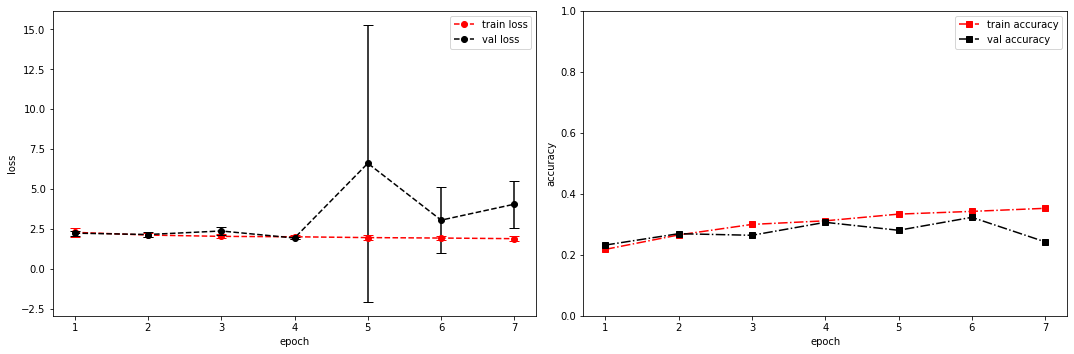

model saved
model saved


training epoch:  7
model set to train
Epoch [8/100], step [1/84],  Loss: 2.0153 +/- 0.0000,  accuracy: 0.0234375, time elapsed = 0.24340415000915527s
Epoch [8/100], step [17/84],  Loss: 1.8259 +/- 0.1762,  accuracy: 0.375, time elapsed = 1.1877517700195312s
Epoch [8/100], step [33/84],  Loss: 1.9184 +/- 0.1190,  accuracy: 0.3427734375, time elapsed = 1.159414291381836s
Epoch [8/100], step [49/84],  Loss: 1.8739 +/- 0.1496,  accuracy: 0.3388671875, time elapsed = 1.2143340110778809s
Epoch [8/100], step [65/84],  Loss: 1.8196 +/- 0.1688,  accuracy: 0.361328125, time elapsed = 1.157973051071167s
Epoch [8/100], step [81/84],  Loss: 1.8514 +/- 0.0965,  accuracy: 0.36328125, time elapsed = 1.1883387565612793s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.356,  precision = 0.356 recall = 0.356 f1 = 0.356 ::: val: acc = 0.379,  precision = 0.379 recall = 0.379 time elapsed = 7.970167398452759s


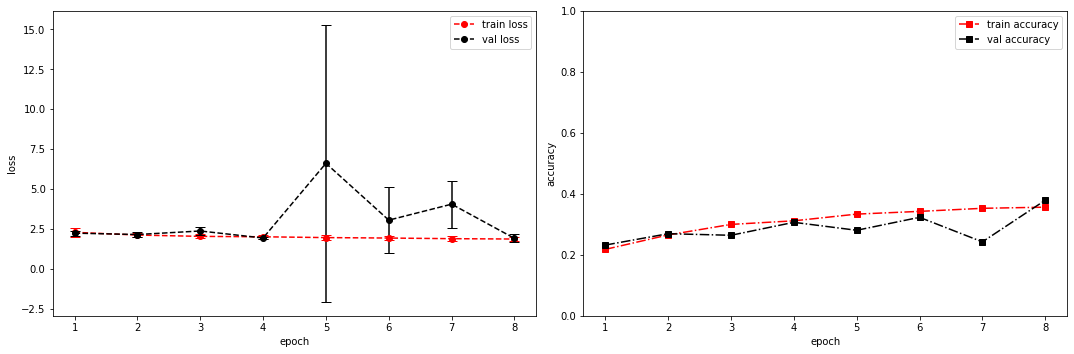

model saved


training epoch:  8
model set to train
Epoch [9/100], step [1/84],  Loss: 1.8497 +/- 0.0000,  accuracy: 0.0263671875, time elapsed = 0.25664615631103516s
Epoch [9/100], step [17/84],  Loss: 1.7920 +/- 0.1754,  accuracy: 0.3955078125, time elapsed = 1.2013897895812988s
Epoch [9/100], step [33/84],  Loss: 1.8067 +/- 0.1392,  accuracy: 0.3701171875, time elapsed = 1.1931328773498535s
Epoch [9/100], step [49/84],  Loss: 1.8359 +/- 0.1206,  accuracy: 0.353515625, time elapsed = 1.1807160377502441s
Epoch [9/100], step [65/84],  Loss: 1.8145 +/- 0.1444,  accuracy: 0.396484375, time elapsed = 1.1821725368499756s
Epoch [9/100], step [81/84],  Loss: 1.8023 +/- 0.1453,  accuracy: 0.3818359375, time elapsed = 1.1786224842071533s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.382,  precision = 0.382 recall = 0.382 f1 = 0.382 ::: val: acc = 0.327,  precision = 0.327 recall = 0.327 time elapsed = 7.974793195724487s


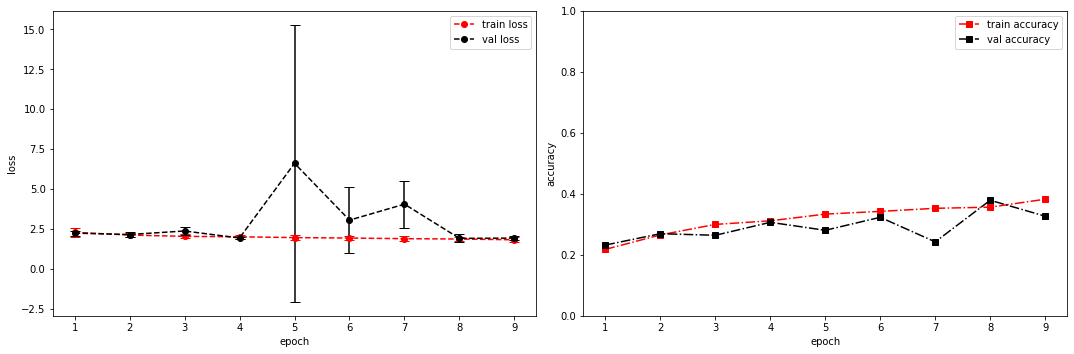

model saved


training epoch:  9
model set to train
Epoch [10/100], step [1/84],  Loss: 1.8433 +/- 0.0000,  accuracy: 0.021484375, time elapsed = 0.25011539459228516s
Epoch [10/100], step [17/84],  Loss: 1.8607 +/- 0.1467,  accuracy: 0.3779296875, time elapsed = 1.2116761207580566s
Epoch [10/100], step [33/84],  Loss: 1.8468 +/- 0.1772,  accuracy: 0.3662109375, time elapsed = 1.1846752166748047s
Epoch [10/100], step [49/84],  Loss: 1.7617 +/- 0.1475,  accuracy: 0.3935546875, time elapsed = 1.173511028289795s
Epoch [10/100], step [65/84],  Loss: 1.8038 +/- 0.1508,  accuracy: 0.3876953125, time elapsed = 1.206333875656128s
Epoch [10/100], step [81/84],  Loss: 1.8255 +/- 0.1553,  accuracy: 0.3740234375, time elapsed = 1.1602604389190674s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.380,  precision = 0.380 recall = 0.380 f1 = 0.380 ::: val: acc = 0.335,  precision = 0.335 recall = 0.335 time elapsed = 8.00098466873169s


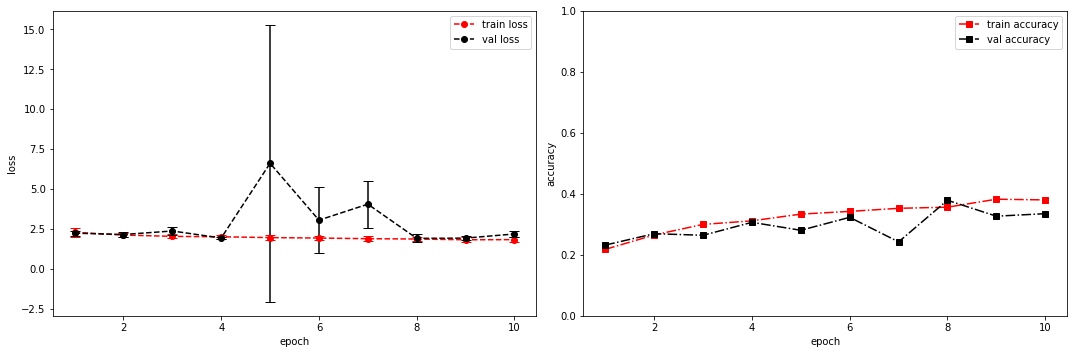

model saved
model saved


training epoch:  10
model set to train
Epoch [11/100], step [1/84],  Loss: 1.5296 +/- 0.0000,  accuracy: 0.03125, time elapsed = 0.25409364700317383s
Epoch [11/100], step [17/84],  Loss: 1.7973 +/- 0.1694,  accuracy: 0.3740234375, time elapsed = 1.2117323875427246s
Epoch [11/100], step [33/84],  Loss: 1.8517 +/- 0.1030,  accuracy: 0.3876953125, time elapsed = 1.1997952461242676s
Epoch [11/100], step [49/84],  Loss: 1.8146 +/- 0.1527,  accuracy: 0.369140625, time elapsed = 1.1815540790557861s
Epoch [11/100], step [65/84],  Loss: 1.8707 +/- 0.1849,  accuracy: 0.369140625, time elapsed = 1.1844828128814697s
Epoch [11/100], step [81/84],  Loss: 1.7752 +/- 0.1724,  accuracy: 0.400390625, time elapsed = 1.1671538352966309s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.378,  precision = 0.378 recall = 0.378 f1 = 0.378 ::: val: acc = 0.330,  precision = 0.330 recall = 0.330 time elapsed = 9.384690999984741s


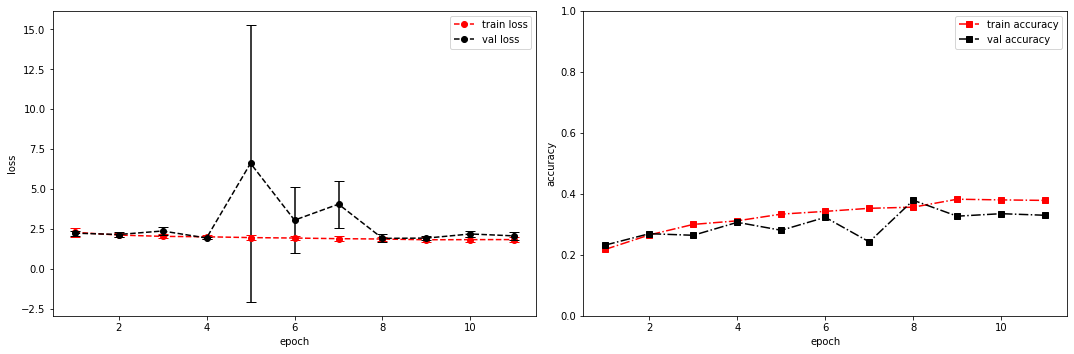

model saved


training epoch:  11
model set to train
Epoch [12/100], step [1/84],  Loss: 2.1172 +/- 0.0000,  accuracy: 0.0205078125, time elapsed = 0.2585411071777344s
Epoch [12/100], step [17/84],  Loss: 1.8504 +/- 0.1232,  accuracy: 0.3857421875, time elapsed = 1.1638803482055664s
Epoch [12/100], step [33/84],  Loss: 1.7663 +/- 0.1469,  accuracy: 0.3994140625, time elapsed = 1.1988565921783447s
Epoch [12/100], step [49/84],  Loss: 1.8333 +/- 0.1286,  accuracy: 0.361328125, time elapsed = 1.1887731552124023s
Epoch [12/100], step [65/84],  Loss: 1.7800 +/- 0.1583,  accuracy: 0.3876953125, time elapsed = 1.1697146892547607s
Epoch [12/100], step [81/84],  Loss: 1.6458 +/- 0.1263,  accuracy: 0.421875, time elapsed = 1.1708385944366455s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.393,  precision = 0.393 recall = 0.393 f1 = 0.393 ::: val: acc = 0.356,  precision = 0.356 recall = 0.356 time elapsed = 7.959856271743774s


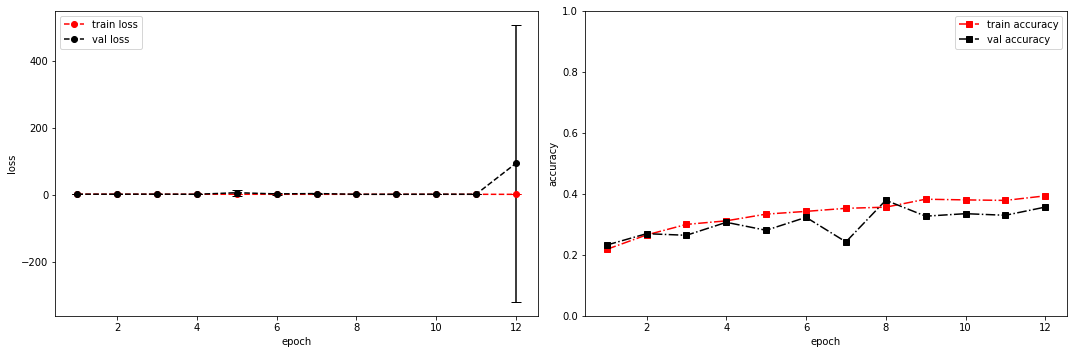

model saved


training epoch:  12
model set to train
Epoch [13/100], step [1/84],  Loss: 1.5511 +/- 0.0000,  accuracy: 0.025390625, time elapsed = 0.25550293922424316s
Epoch [13/100], step [17/84],  Loss: 1.7602 +/- 0.1994,  accuracy: 0.4091796875, time elapsed = 1.1642484664916992s
Epoch [13/100], step [33/84],  Loss: 1.8273 +/- 0.1318,  accuracy: 0.3779296875, time elapsed = 1.2012066841125488s
Epoch [13/100], step [49/84],  Loss: 1.8137 +/- 0.1587,  accuracy: 0.388671875, time elapsed = 1.208082675933838s
Epoch [13/100], step [65/84],  Loss: 1.7118 +/- 0.1588,  accuracy: 0.4296875, time elapsed = 1.1712751388549805s
Epoch [13/100], step [81/84],  Loss: 1.7657 +/- 0.1668,  accuracy: 0.390625, time elapsed = 1.1345009803771973s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.401,  precision = 0.401 recall = 0.401 f1 = 0.401 ::: val: acc = 0.322,  precision = 0.322 recall = 0.322 time elapsed = 7.937514543533325s


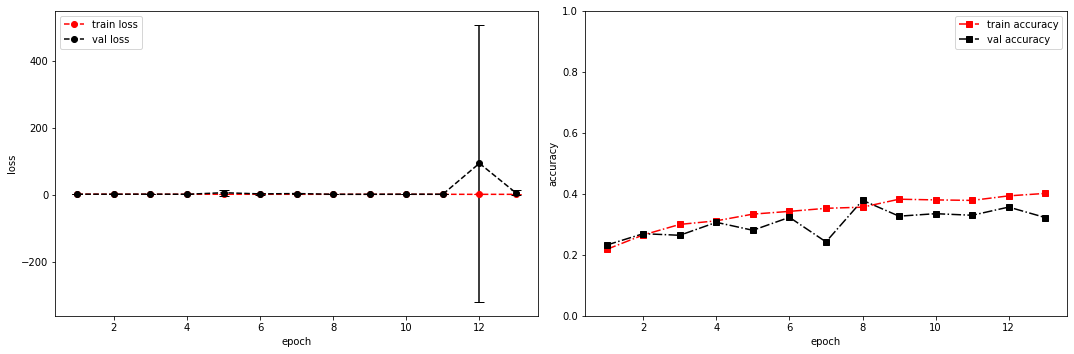

model saved


training epoch:  13
model set to train
Epoch [14/100], step [1/84],  Loss: 1.7247 +/- 0.0000,  accuracy: 0.0234375, time elapsed = 0.2477869987487793s
Epoch [14/100], step [17/84],  Loss: 1.7318 +/- 0.1620,  accuracy: 0.4169921875, time elapsed = 1.194478988647461s
Epoch [14/100], step [33/84],  Loss: 1.6923 +/- 0.1286,  accuracy: 0.419921875, time elapsed = 1.1567814350128174s
Epoch [14/100], step [49/84],  Loss: 1.7853 +/- 0.1454,  accuracy: 0.3974609375, time elapsed = 1.1608185768127441s
Epoch [14/100], step [65/84],  Loss: 1.7669 +/- 0.1523,  accuracy: 0.384765625, time elapsed = 1.1549208164215088s
Epoch [14/100], step [81/84],  Loss: 1.7097 +/- 0.1720,  accuracy: 0.4208984375, time elapsed = 1.19759202003479s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.407,  precision = 0.407 recall = 0.407 f1 = 0.407 ::: val: acc = 0.374,  precision = 0.374 recall = 0.374 time elapsed = 7.9006028175354s


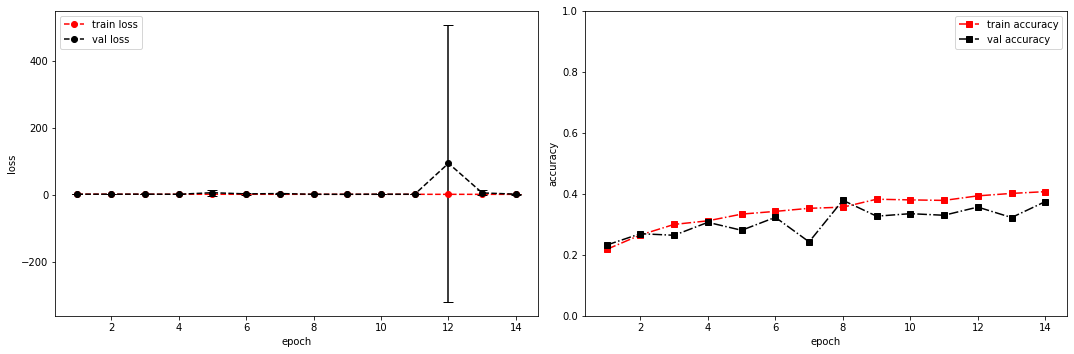

model saved


training epoch:  14
model set to train
Epoch [15/100], step [1/84],  Loss: 1.5282 +/- 0.0000,  accuracy: 0.0322265625, time elapsed = 0.2527289390563965s
Epoch [15/100], step [17/84],  Loss: 1.7001 +/- 0.1693,  accuracy: 0.419921875, time elapsed = 1.1854782104492188s
Epoch [15/100], step [33/84],  Loss: 1.6444 +/- 0.1686,  accuracy: 0.4453125, time elapsed = 1.1867165565490723s
Epoch [15/100], step [49/84],  Loss: 1.7424 +/- 0.2041,  accuracy: 0.4091796875, time elapsed = 1.1624956130981445s
Epoch [15/100], step [65/84],  Loss: 1.6361 +/- 0.1308,  accuracy: 0.4296875, time elapsed = 1.1721067428588867s
Epoch [15/100], step [81/84],  Loss: 1.6763 +/- 0.1010,  accuracy: 0.42578125, time elapsed = 1.1622509956359863s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.428,  precision = 0.428 recall = 0.428 f1 = 0.428 ::: val: acc = 0.336,  precision = 0.336 recall = 0.336 time elapsed = 7.9363484382629395s


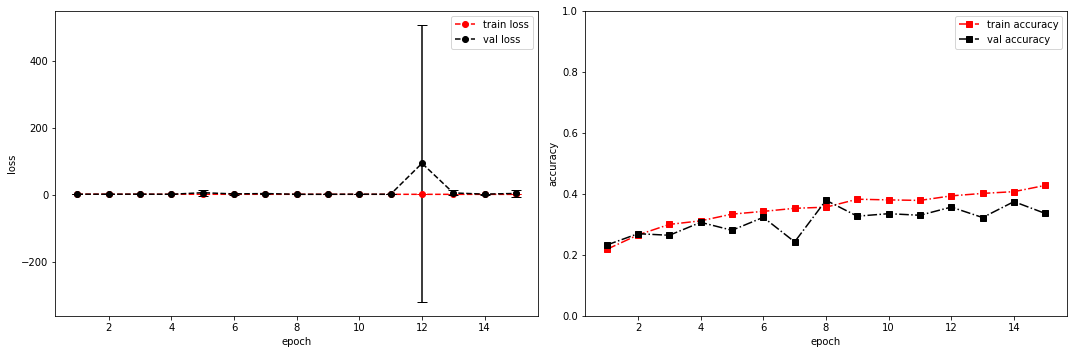

model saved


training epoch:  15
model set to train
Epoch [16/100], step [1/84],  Loss: 1.7875 +/- 0.0000,  accuracy: 0.0244140625, time elapsed = 0.26877617835998535s
Epoch [16/100], step [17/84],  Loss: 1.6667 +/- 0.1273,  accuracy: 0.4248046875, time elapsed = 1.1597566604614258s
Epoch [16/100], step [33/84],  Loss: 1.6517 +/- 0.1787,  accuracy: 0.423828125, time elapsed = 1.1791975498199463s
Epoch [16/100], step [49/84],  Loss: 1.6840 +/- 0.2084,  accuracy: 0.4208984375, time elapsed = 1.1457233428955078s
Epoch [16/100], step [65/84],  Loss: 1.6336 +/- 0.1254,  accuracy: 0.455078125, time elapsed = 1.1303515434265137s
Epoch [16/100], step [81/84],  Loss: 1.6457 +/- 0.1499,  accuracy: 0.439453125, time elapsed = 1.161360740661621s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.435,  precision = 0.435 recall = 0.435 f1 = 0.435 ::: val: acc = 0.414,  precision = 0.414 recall = 0.414 time elapsed = 7.791910648345947s


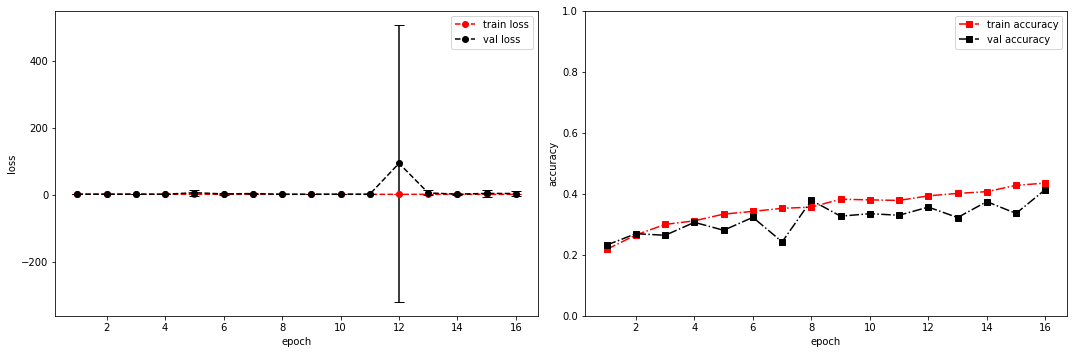

model saved


training epoch:  16
model set to train
Epoch [17/100], step [1/84],  Loss: 1.3130 +/- 0.0000,  accuracy: 0.0361328125, time elapsed = 0.24351286888122559s
Epoch [17/100], step [17/84],  Loss: 1.5626 +/- 0.1131,  accuracy: 0.4931640625, time elapsed = 1.2033238410949707s
Epoch [17/100], step [33/84],  Loss: 1.7167 +/- 0.1125,  accuracy: 0.4248046875, time elapsed = 1.1641740798950195s
Epoch [17/100], step [49/84],  Loss: 1.6867 +/- 0.1541,  accuracy: 0.423828125, time elapsed = 1.1719975471496582s
Epoch [17/100], step [65/84],  Loss: 1.6661 +/- 0.1517,  accuracy: 0.4326171875, time elapsed = 1.1742937564849854s
Epoch [17/100], step [81/84],  Loss: 1.6539 +/- 0.0776,  accuracy: 0.4384765625, time elapsed = 1.167342185974121s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.447,  precision = 0.447 recall = 0.447 f1 = 0.447 ::: val: acc = 0.400,  precision = 0.400 recall = 0.400 time elapsed = 7.906275033950806s


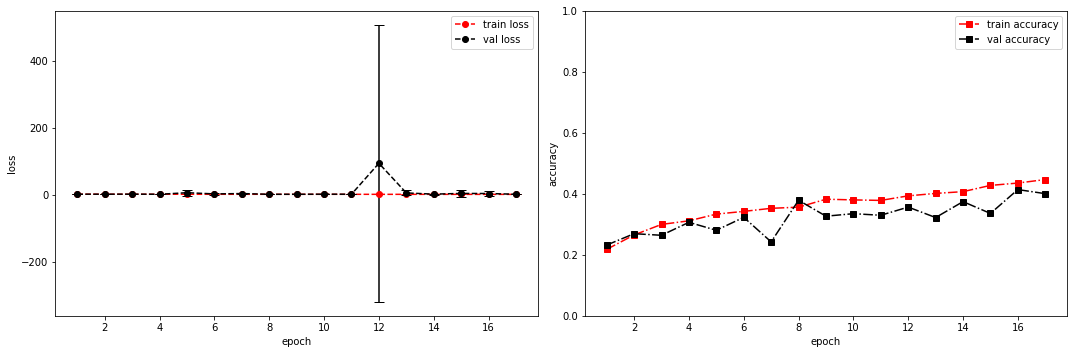

model saved


training epoch:  17
model set to train
Epoch [18/100], step [1/84],  Loss: 1.5707 +/- 0.0000,  accuracy: 0.0322265625, time elapsed = 0.2549107074737549s
Epoch [18/100], step [17/84],  Loss: 1.5643 +/- 0.1132,  accuracy: 0.4521484375, time elapsed = 1.171093463897705s
Epoch [18/100], step [33/84],  Loss: 1.6242 +/- 0.1869,  accuracy: 0.44140625, time elapsed = 1.1793384552001953s
Epoch [18/100], step [49/84],  Loss: 1.6040 +/- 0.1562,  accuracy: 0.44140625, time elapsed = 1.1772980690002441s
Epoch [18/100], step [65/84],  Loss: 1.6074 +/- 0.1718,  accuracy: 0.4619140625, time elapsed = 1.1555001735687256s
Epoch [18/100], step [81/84],  Loss: 1.5664 +/- 0.1199,  accuracy: 0.453125, time elapsed = 1.1579267978668213s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.449,  precision = 0.449 recall = 0.449 f1 = 0.449 ::: val: acc = 0.364,  precision = 0.364 recall = 0.364 time elapsed = 7.873523235321045s


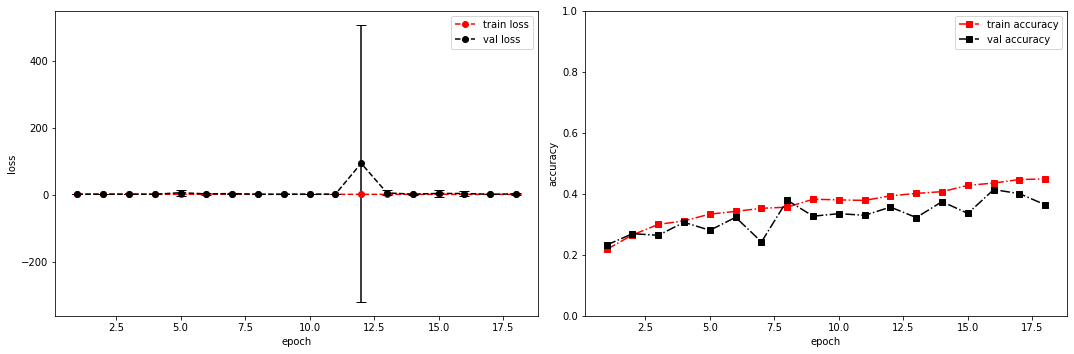

model saved


training epoch:  18
model set to train
Epoch [19/100], step [1/84],  Loss: 1.4816 +/- 0.0000,  accuracy: 0.03125, time elapsed = 0.26899099349975586s
Epoch [19/100], step [17/84],  Loss: 1.5015 +/- 0.1795,  accuracy: 0.4970703125, time elapsed = 1.1862542629241943s
Epoch [19/100], step [33/84],  Loss: 1.6273 +/- 0.1853,  accuracy: 0.4541015625, time elapsed = 1.1891286373138428s
Epoch [19/100], step [49/84],  Loss: 1.6559 +/- 0.1824,  accuracy: 0.44921875, time elapsed = 1.183718204498291s
Epoch [19/100], step [65/84],  Loss: 1.5960 +/- 0.1477,  accuracy: 0.4462890625, time elapsed = 1.1947438716888428s
Epoch [19/100], step [81/84],  Loss: 1.5800 +/- 0.1815,  accuracy: 0.486328125, time elapsed = 1.146425724029541s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.469,  precision = 0.469 recall = 0.469 f1 = 0.469 ::: val: acc = 0.314,  precision = 0.314 recall = 0.314 time elapsed = 7.993630647659302s


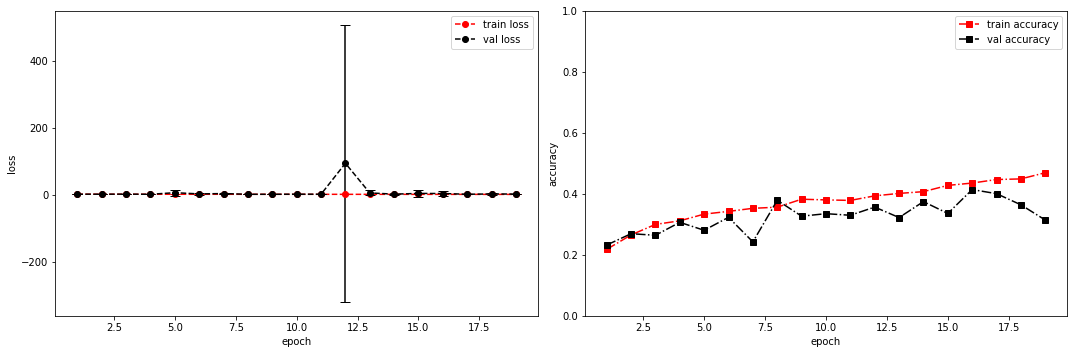

model saved


training epoch:  19
model set to train
Epoch [20/100], step [1/84],  Loss: 1.6461 +/- 0.0000,  accuracy: 0.0283203125, time elapsed = 0.25963616371154785s
Epoch [20/100], step [17/84],  Loss: 1.5449 +/- 0.1942,  accuracy: 0.48046875, time elapsed = 1.2193546295166016s
Epoch [20/100], step [33/84],  Loss: 1.5060 +/- 0.1566,  accuracy: 0.482421875, time elapsed = 1.2054200172424316s
Epoch [20/100], step [49/84],  Loss: 1.6146 +/- 0.1031,  accuracy: 0.4619140625, time elapsed = 1.1909115314483643s
Epoch [20/100], step [65/84],  Loss: 1.5768 +/- 0.1585,  accuracy: 0.474609375, time elapsed = 1.1859171390533447s
Epoch [20/100], step [81/84],  Loss: 1.5676 +/- 0.1411,  accuracy: 0.4609375, time elapsed = 1.1789019107818604s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.470,  precision = 0.470 recall = 0.470 f1 = 0.470 ::: val: acc = 0.339,  precision = 0.339 recall = 0.339 time elapsed = 8.060495376586914s


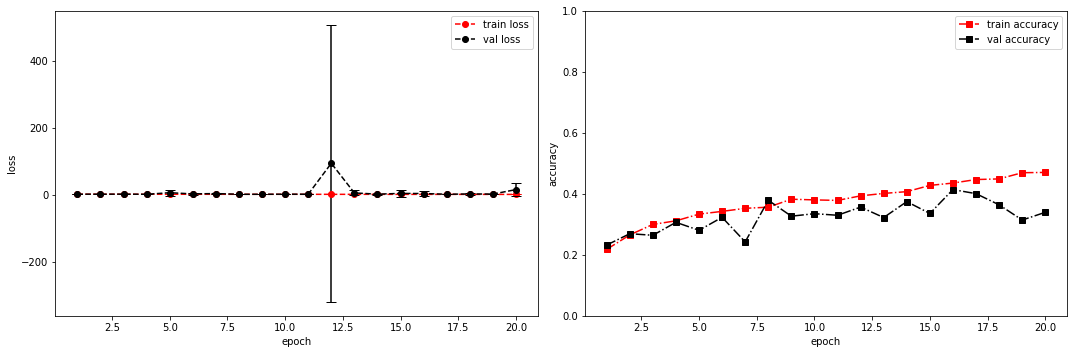

model saved


training epoch:  20
model set to train
Epoch [21/100], step [1/84],  Loss: 1.5407 +/- 0.0000,  accuracy: 0.02734375, time elapsed = 0.2534947395324707s
Epoch [21/100], step [17/84],  Loss: 1.4948 +/- 0.1781,  accuracy: 0.5078125, time elapsed = 1.1968271732330322s
Epoch [21/100], step [33/84],  Loss: 1.5424 +/- 0.1514,  accuracy: 0.4755859375, time elapsed = 1.2066872119903564s
Epoch [21/100], step [49/84],  Loss: 1.5145 +/- 0.1244,  accuracy: 0.4794921875, time elapsed = 1.1947059631347656s
Epoch [21/100], step [65/84],  Loss: 1.5721 +/- 0.1673,  accuracy: 0.4560546875, time elapsed = 1.188161849975586s
Epoch [21/100], step [81/84],  Loss: 1.5468 +/- 0.1364,  accuracy: 0.4638671875, time elapsed = 1.1862127780914307s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.475,  precision = 0.475 recall = 0.475 f1 = 0.475 ::: val: acc = 0.375,  precision = 0.375 recall = 0.375 time elapsed = 8.098489999771118s


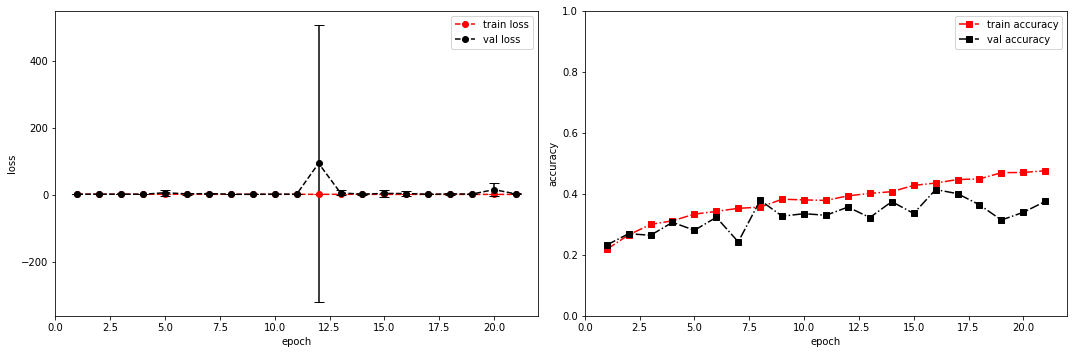

model saved


training epoch:  21
model set to train
Epoch [22/100], step [1/84],  Loss: 1.5722 +/- 0.0000,  accuracy: 0.02734375, time elapsed = 0.26250553131103516s
Epoch [22/100], step [17/84],  Loss: 1.4157 +/- 0.1227,  accuracy: 0.5166015625, time elapsed = 1.1862776279449463s
Epoch [22/100], step [33/84],  Loss: 1.5438 +/- 0.1455,  accuracy: 0.4638671875, time elapsed = 1.1637334823608398s
Epoch [22/100], step [49/84],  Loss: 1.5182 +/- 0.1251,  accuracy: 0.4716796875, time elapsed = 1.2006733417510986s
Epoch [22/100], step [65/84],  Loss: 1.5045 +/- 0.1042,  accuracy: 0.5126953125, time elapsed = 1.2085802555084229s
Epoch [22/100], step [81/84],  Loss: 1.5383 +/- 0.1397,  accuracy: 0.4775390625, time elapsed = 1.202929973602295s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.488,  precision = 0.488 recall = 0.488 f1 = 0.488 ::: val: acc = 0.396,  precision = 0.396 recall = 0.396 time elapsed = 8.03604531288147s


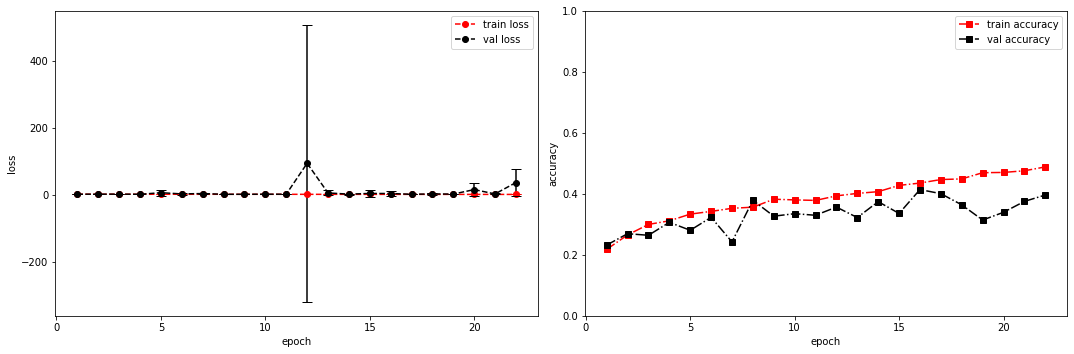

model saved


training epoch:  22
model set to train
Epoch [23/100], step [1/84],  Loss: 1.3340 +/- 0.0000,  accuracy: 0.033203125, time elapsed = 0.259798526763916s
Epoch [23/100], step [17/84],  Loss: 1.3850 +/- 0.1484,  accuracy: 0.5439453125, time elapsed = 1.2224340438842773s
Epoch [23/100], step [33/84],  Loss: 1.9357 +/- 0.3225,  accuracy: 0.3857421875, time elapsed = 1.1921236515045166s
Epoch [23/100], step [49/84],  Loss: 1.9882 +/- 0.1866,  accuracy: 0.337890625, time elapsed = 1.1914968490600586s
Epoch [23/100], step [65/84],  Loss: 2.0329 +/- 0.1782,  accuracy: 0.3330078125, time elapsed = 1.1665735244750977s
Epoch [23/100], step [81/84],  Loss: 1.9598 +/- 0.1769,  accuracy: 0.3447265625, time elapsed = 1.175835371017456s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.389,  precision = 0.389 recall = 0.389 f1 = 0.389 ::: val: acc = 0.317,  precision = 0.317 recall = 0.317 time elapsed = 8.017053604125977s


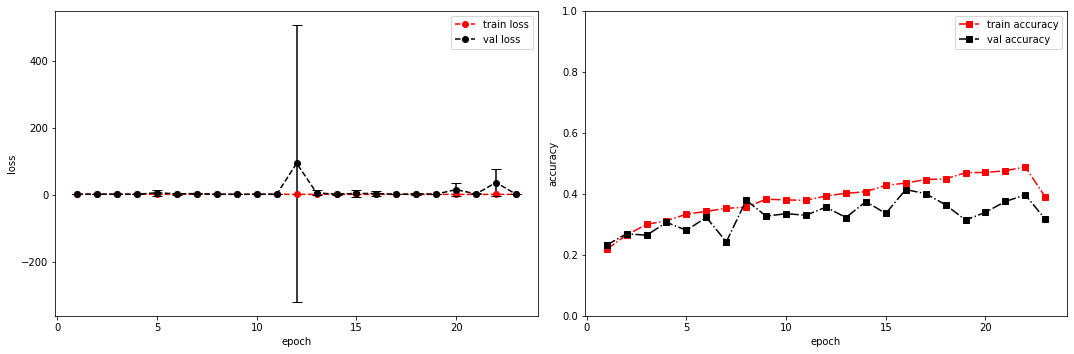

model saved


training epoch:  23
model set to train
Epoch [24/100], step [1/84],  Loss: 1.5356 +/- 0.0000,  accuracy: 0.029296875, time elapsed = 0.2585783004760742s
Epoch [24/100], step [17/84],  Loss: 1.7979 +/- 0.1559,  accuracy: 0.400390625, time elapsed = 1.2177729606628418s
Epoch [24/100], step [33/84],  Loss: 1.9871 +/- 0.2365,  accuracy: 0.3291015625, time elapsed = 1.1794021129608154s
Epoch [24/100], step [49/84],  Loss: 2.0249 +/- 0.2034,  accuracy: 0.3310546875, time elapsed = 1.2129206657409668s
Epoch [24/100], step [65/84],  Loss: 1.9035 +/- 0.1933,  accuracy: 0.34375, time elapsed = 1.1816494464874268s
Epoch [24/100], step [81/84],  Loss: 1.8339 +/- 0.1749,  accuracy: 0.40625, time elapsed = 1.1725568771362305s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.366,  precision = 0.366 recall = 0.366 f1 = 0.366 ::: val: acc = 0.372,  precision = 0.372 recall = 0.372 time elapsed = 8.063496112823486s


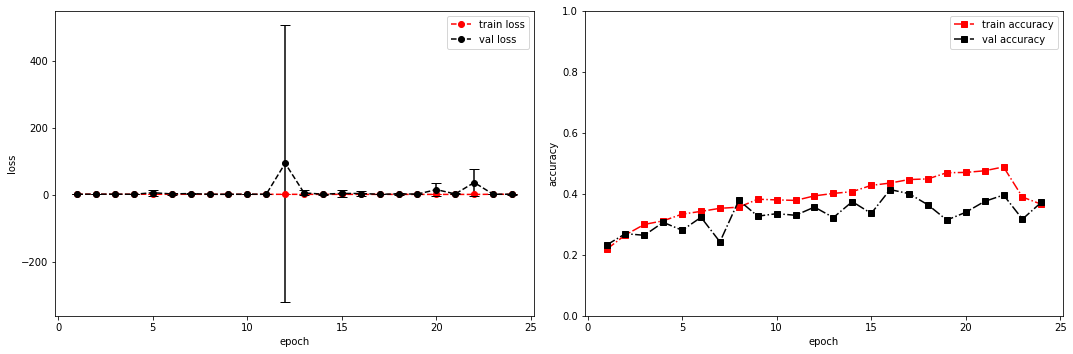

model saved


training epoch:  24
model set to train
Epoch [25/100], step [1/84],  Loss: 1.8131 +/- 0.0000,  accuracy: 0.0263671875, time elapsed = 0.26233410835266113s
Epoch [25/100], step [17/84],  Loss: 1.6928 +/- 0.0980,  accuracy: 0.4248046875, time elapsed = 1.2227632999420166s
Epoch [25/100], step [33/84],  Loss: 1.6893 +/- 0.1454,  accuracy: 0.44140625, time elapsed = 1.2133269309997559s
Epoch [25/100], step [49/84],  Loss: 1.6192 +/- 0.2111,  accuracy: 0.4599609375, time elapsed = 1.2149183750152588s
Epoch [25/100], step [65/84],  Loss: 1.6889 +/- 0.1434,  accuracy: 0.421875, time elapsed = 1.2071642875671387s
Epoch [25/100], step [81/84],  Loss: 1.6359 +/- 0.1044,  accuracy: 0.41796875, time elapsed = 1.1865532398223877s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.433,  precision = 0.433 recall = 0.433 f1 = 0.433 ::: val: acc = 0.390,  precision = 0.390 recall = 0.390 time elapsed = 8.134986162185669s


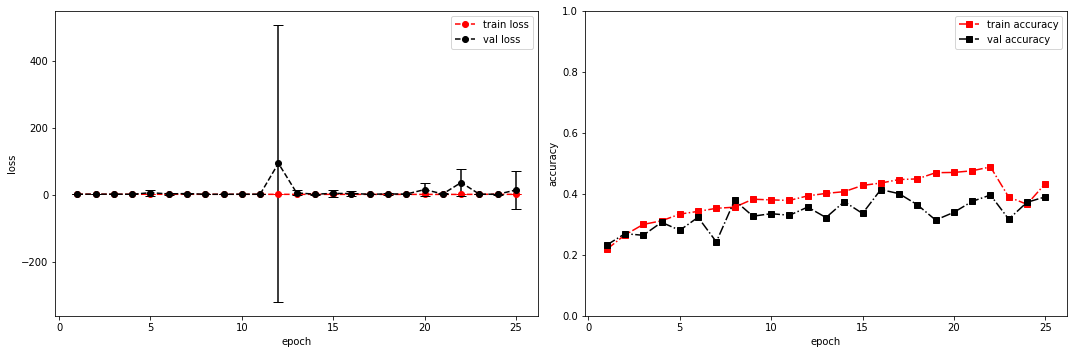

model saved


training epoch:  25
model set to train
Epoch [26/100], step [1/84],  Loss: 1.5767 +/- 0.0000,  accuracy: 0.0283203125, time elapsed = 0.25018954277038574s
Epoch [26/100], step [17/84],  Loss: 1.5238 +/- 0.1259,  accuracy: 0.470703125, time elapsed = 1.2077972888946533s
Epoch [26/100], step [33/84],  Loss: 1.5931 +/- 0.1741,  accuracy: 0.470703125, time elapsed = 1.16748046875s
Epoch [26/100], step [49/84],  Loss: 1.6105 +/- 0.1675,  accuracy: 0.4345703125, time elapsed = 1.1745970249176025s
Epoch [26/100], step [65/84],  Loss: 1.6065 +/- 0.1724,  accuracy: 0.4619140625, time elapsed = 1.200195074081421s
Epoch [26/100], step [81/84],  Loss: 1.4827 +/- 0.1688,  accuracy: 0.4990234375, time elapsed = 1.1915483474731445s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.466,  precision = 0.466 recall = 0.466 f1 = 0.466 ::: val: acc = 0.439,  precision = 0.439 recall = 0.439 time elapsed = 8.030279159545898s


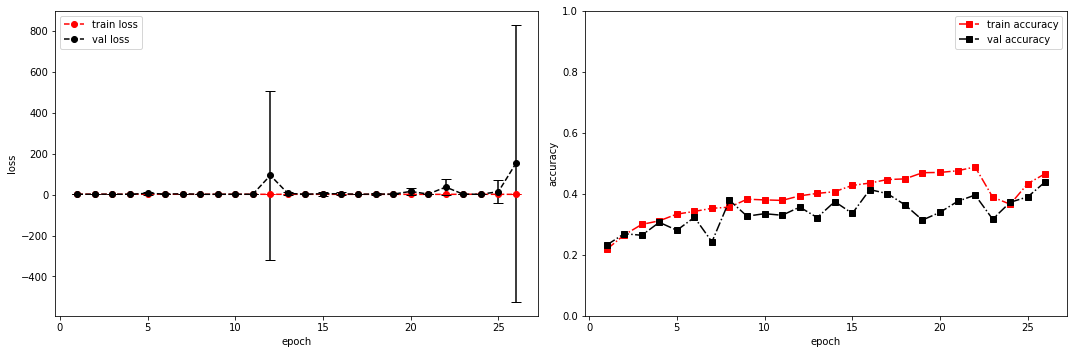

model saved


training epoch:  26
model set to train
Epoch [27/100], step [1/84],  Loss: 1.1358 +/- 0.0000,  accuracy: 0.03515625, time elapsed = 0.24605560302734375s
Epoch [27/100], step [17/84],  Loss: 1.3764 +/- 0.1430,  accuracy: 0.5283203125, time elapsed = 1.1879620552062988s
Epoch [27/100], step [33/84],  Loss: 1.5303 +/- 0.2422,  accuracy: 0.4794921875, time elapsed = 1.1687588691711426s
Epoch [27/100], step [49/84],  Loss: 1.7160 +/- 0.3359,  accuracy: 0.4287109375, time elapsed = 1.1496925354003906s
Epoch [27/100], step [65/84],  Loss: 1.9223 +/- 0.1343,  accuracy: 0.353515625, time elapsed = 1.167090654373169s
Epoch [27/100], step [81/84],  Loss: 1.8832 +/- 0.2068,  accuracy: 0.3720703125, time elapsed = 1.1763958930969238s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.434,  precision = 0.434 recall = 0.434 f1 = 0.434 ::: val: acc = 0.327,  precision = 0.327 recall = 0.327 time elapsed = 7.922908782958984s


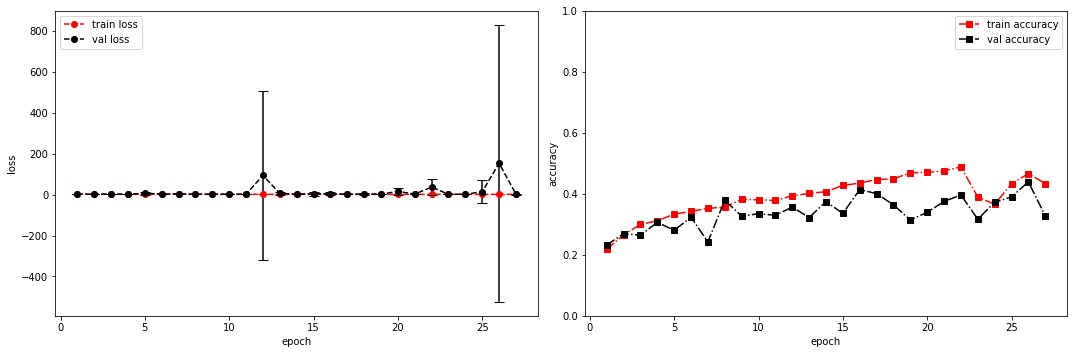

model saved


training epoch:  27
model set to train
Epoch [28/100], step [1/84],  Loss: 1.7630 +/- 0.0000,  accuracy: 0.0234375, time elapsed = 0.2714426517486572s
Epoch [28/100], step [17/84],  Loss: 1.7215 +/- 0.1782,  accuracy: 0.4365234375, time elapsed = 1.2247145175933838s
Epoch [28/100], step [33/84],  Loss: 1.6226 +/- 0.1915,  accuracy: 0.4482421875, time elapsed = 1.1972217559814453s
Epoch [28/100], step [49/84],  Loss: 1.5525 +/- 0.1995,  accuracy: 0.4580078125, time elapsed = 1.174189805984497s
Epoch [28/100], step [65/84],  Loss: 1.6221 +/- 0.1626,  accuracy: 0.4501953125, time elapsed = 1.1543638706207275s
Epoch [28/100], step [81/84],  Loss: 1.5415 +/- 0.1783,  accuracy: 0.4853515625, time elapsed = 1.1742205619812012s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.457,  precision = 0.457 recall = 0.457 f1 = 0.457 ::: val: acc = 0.391,  precision = 0.391 recall = 0.391 time elapsed = 8.018441915512085s


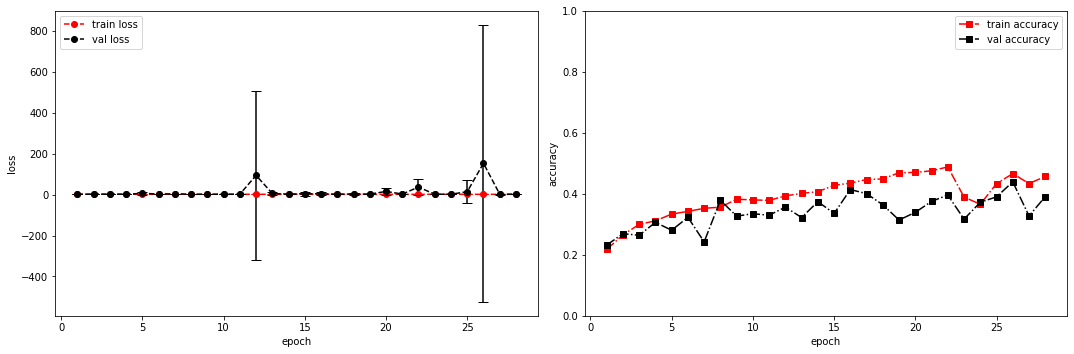

model saved


training epoch:  28
model set to train
Epoch [29/100], step [1/84],  Loss: 1.3806 +/- 0.0000,  accuracy: 0.037109375, time elapsed = 0.2651636600494385s
Epoch [29/100], step [17/84],  Loss: 1.4223 +/- 0.1698,  accuracy: 0.505859375, time elapsed = 1.2127060890197754s
Epoch [29/100], step [33/84],  Loss: 1.4580 +/- 0.1979,  accuracy: 0.498046875, time elapsed = 1.1988377571105957s
Epoch [29/100], step [49/84],  Loss: 1.4022 +/- 0.1448,  accuracy: 0.5205078125, time elapsed = 1.1881051063537598s
Epoch [29/100], step [65/84],  Loss: 1.4449 +/- 0.1265,  accuracy: 0.515625, time elapsed = 1.17521333694458s
Epoch [29/100], step [81/84],  Loss: 1.5207 +/- 0.2109,  accuracy: 0.484375, time elapsed = 1.2006118297576904s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.507,  precision = 0.507 recall = 0.507 f1 = 0.507 ::: val: acc = 0.390,  precision = 0.390 recall = 0.390 time elapsed = 8.042269229888916s


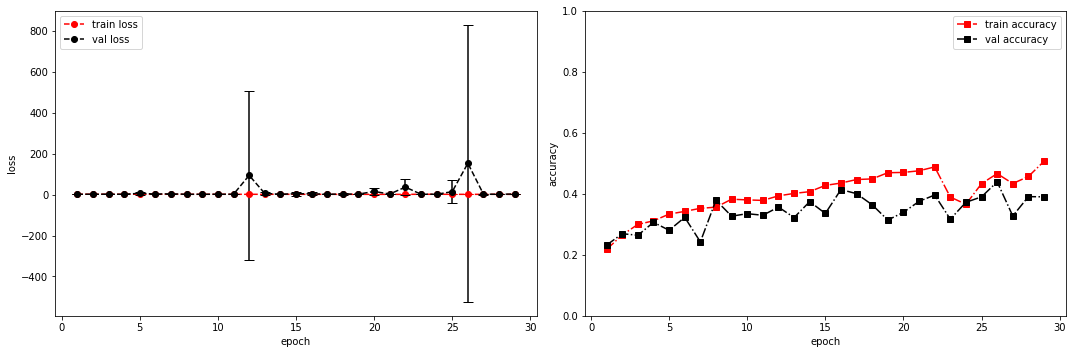

model saved


training epoch:  29
model set to train
Epoch [30/100], step [1/84],  Loss: 1.3033 +/- 0.0000,  accuracy: 0.033203125, time elapsed = 0.26221346855163574s
Epoch [30/100], step [17/84],  Loss: 1.3694 +/- 0.1546,  accuracy: 0.546875, time elapsed = 1.1854815483093262s
Epoch [30/100], step [33/84],  Loss: 1.3380 +/- 0.1644,  accuracy: 0.5400390625, time elapsed = 1.1916077136993408s
Epoch [30/100], step [49/84],  Loss: 1.3386 +/- 0.1312,  accuracy: 0.537109375, time elapsed = 1.1604509353637695s
Epoch [30/100], step [65/84],  Loss: 1.4356 +/- 0.1384,  accuracy: 0.5107421875, time elapsed = 1.1689934730529785s
Epoch [30/100], step [81/84],  Loss: 1.3416 +/- 0.1385,  accuracy: 0.5595703125, time elapsed = 1.2127389907836914s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.538,  precision = 0.538 recall = 0.538 f1 = 0.538 ::: val: acc = 0.412,  precision = 0.412 recall = 0.412 time elapsed = 7.977156400680542s


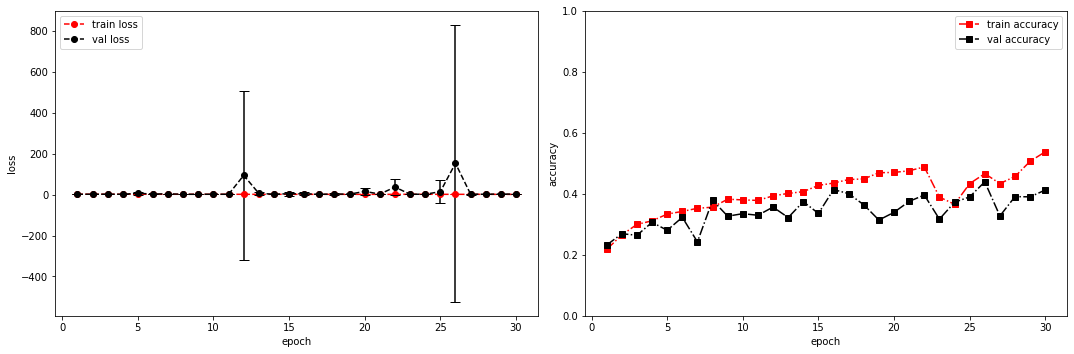

model saved
model saved


training epoch:  30
model set to train
Epoch [31/100], step [1/84],  Loss: 1.4215 +/- 0.0000,  accuracy: 0.0341796875, time elapsed = 0.26865053176879883s
Epoch [31/100], step [17/84],  Loss: 1.3077 +/- 0.1550,  accuracy: 0.5556640625, time elapsed = 1.1941232681274414s
Epoch [31/100], step [33/84],  Loss: 1.3658 +/- 0.1478,  accuracy: 0.5400390625, time elapsed = 1.166041374206543s
Epoch [31/100], step [49/84],  Loss: 1.3529 +/- 0.1439,  accuracy: 0.5380859375, time elapsed = 1.184342384338379s
Epoch [31/100], step [65/84],  Loss: 1.4056 +/- 0.2057,  accuracy: 0.53515625, time elapsed = 1.2223215103149414s
Epoch [31/100], step [81/84],  Loss: 1.4187 +/- 0.2221,  accuracy: 0.544921875, time elapsed = 1.174117088317871s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.542,  precision = 0.542 recall = 0.542 f1 = 0.542 ::: val: acc = 0.386,  precision = 0.386 recall = 0.386 time elapsed = 8.035812139511108s


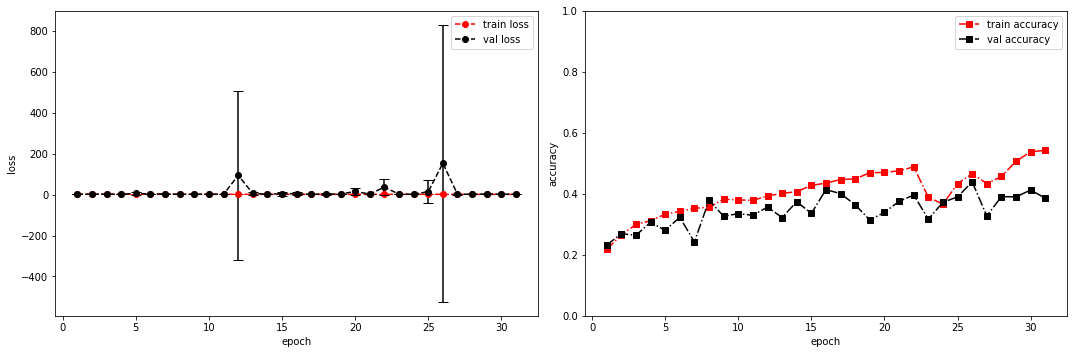

model saved
stopping early
device:  cuda
dataset metadata:  {'n_fft': 2048, 'hop_length': 256, 'n_mfcc': 13, 'notes': 'optional notes not passed'}
train model: data loaders initialized
sample shape =  (1, 13, 517)
model loaded
Layer (type:depth-idx)                   Output Shape              Param #
├─ConvBlock: 1-1                         [-1, 8, 6, 258]           --
|    └─Sequential: 2-1                   [-1, 8, 6, 258]           --
|    |    └─Conv2d: 3-1                  [-1, 8, 13, 517]          80
|    |    └─ReLU: 3-2                    [-1, 8, 13, 517]          --
|    |    └─MaxPool2d: 3-3               [-1, 8, 6, 258]           --
|    |    └─BatchNorm2d: 3-4             [-1, 8, 6, 258]           16
├─ConvBlock: 1-2                         [-1, 8, 3, 129]           --
|    └─Sequential: 2-2                   [-1, 8, 3, 129]           --
|    |    └─Conv2d: 3-5                  [-1, 8, 6, 258]           584
|    |    └─ReLU: 3-6                    [-1, 8, 6, 258]           

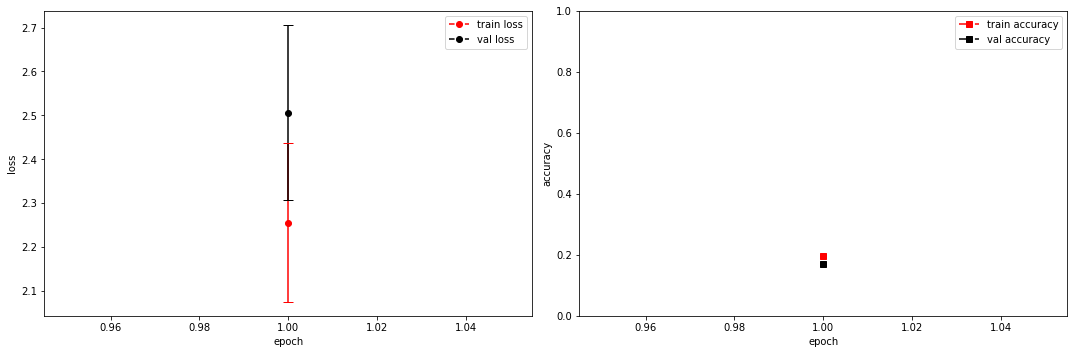

model saved


training epoch:  1
model set to train
Epoch [2/100], step [1/84],  Loss: 1.9882 +/- 0.0000,  accuracy: 0.0166015625, time elapsed = 0.2709522247314453s
Epoch [2/100], step [17/84],  Loss: 2.1139 +/- 0.0867,  accuracy: 0.232421875, time elapsed = 1.2153630256652832s
Epoch [2/100], step [33/84],  Loss: 2.1036 +/- 0.1158,  accuracy: 0.2646484375, time elapsed = 1.1850435733795166s
Epoch [2/100], step [49/84],  Loss: 2.0913 +/- 0.0754,  accuracy: 0.26171875, time elapsed = 1.1761393547058105s
Epoch [2/100], step [65/84],  Loss: 2.0494 +/- 0.1289,  accuracy: 0.275390625, time elapsed = 1.1707825660705566s
Epoch [2/100], step [81/84],  Loss: 2.0399 +/- 0.1295,  accuracy: 0.2744140625, time elapsed = 1.1734061241149902s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.262,  precision = 0.262 recall = 0.262 f1 = 0.262 ::: val: acc = 0.263,  precision = 0.263 recall = 0.263 time elapsed = 8.049930810928345s


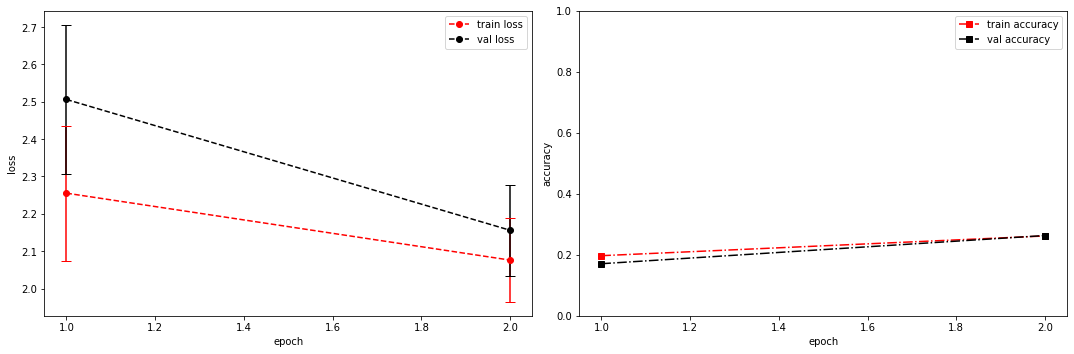

model saved


training epoch:  2
model set to train
Epoch [3/100], step [1/84],  Loss: 1.8501 +/- 0.0000,  accuracy: 0.0234375, time elapsed = 0.27259397506713867s
Epoch [3/100], step [17/84],  Loss: 2.0797 +/- 0.1247,  accuracy: 0.2841796875, time elapsed = 1.2091624736785889s
Epoch [3/100], step [33/84],  Loss: 1.9862 +/- 0.0753,  accuracy: 0.2958984375, time elapsed = 1.1800391674041748s
Epoch [3/100], step [49/84],  Loss: 2.0228 +/- 0.1248,  accuracy: 0.2958984375, time elapsed = 1.160856008529663s
Epoch [3/100], step [65/84],  Loss: 1.9730 +/- 0.1089,  accuracy: 0.3115234375, time elapsed = 1.1943998336791992s
Epoch [3/100], step [81/84],  Loss: 1.9358 +/- 0.0995,  accuracy: 0.318359375, time elapsed = 1.168834924697876s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.304,  precision = 0.304 recall = 0.304 f1 = 0.304 ::: val: acc = 0.262,  precision = 0.262 recall = 0.262 time elapsed = 8.027544498443604s


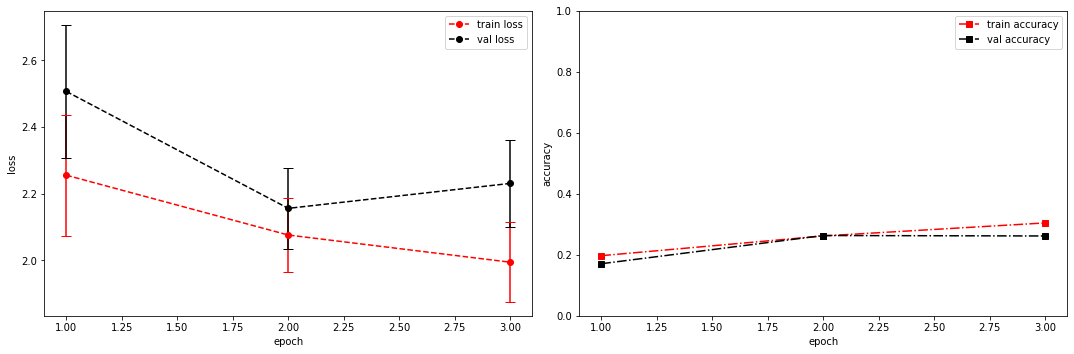

model saved


training epoch:  3
model set to train
Epoch [4/100], step [1/84],  Loss: 1.7079 +/- 0.0000,  accuracy: 0.021484375, time elapsed = 0.30306267738342285s
Epoch [4/100], step [17/84],  Loss: 2.0360 +/- 0.1161,  accuracy: 0.287109375, time elapsed = 1.214440107345581s
Epoch [4/100], step [33/84],  Loss: 1.9719 +/- 0.1148,  accuracy: 0.3056640625, time elapsed = 1.1713554859161377s
Epoch [4/100], step [49/84],  Loss: 1.9341 +/- 0.1350,  accuracy: 0.3310546875, time elapsed = 1.165773868560791s
Epoch [4/100], step [65/84],  Loss: 1.9067 +/- 0.1162,  accuracy: 0.322265625, time elapsed = 1.178100347518921s
Epoch [4/100], step [81/84],  Loss: 1.9977 +/- 0.1245,  accuracy: 0.3037109375, time elapsed = 1.1761164665222168s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.311,  precision = 0.311 recall = 0.311 f1 = 0.311 ::: val: acc = 0.310,  precision = 0.310 recall = 0.310 time elapsed = 8.047651529312134s


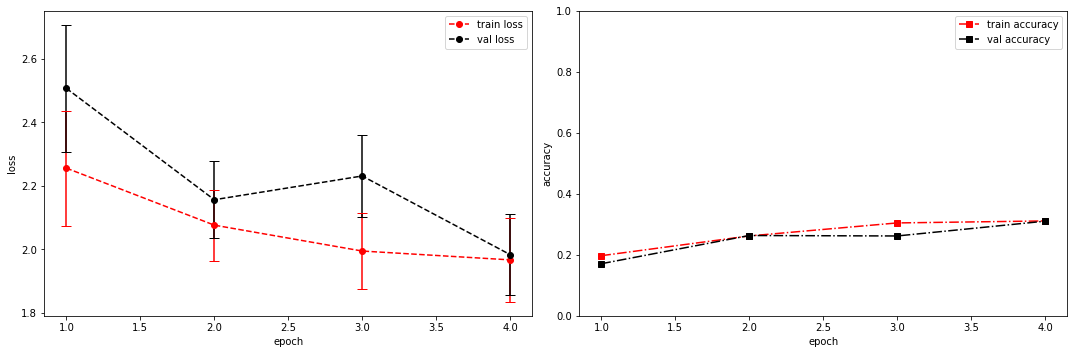

model saved


training epoch:  4
model set to train
Epoch [5/100], step [1/84],  Loss: 2.0660 +/- 0.0000,  accuracy: 0.0166015625, time elapsed = 0.2712881565093994s
Epoch [5/100], step [17/84],  Loss: 1.9127 +/- 0.1182,  accuracy: 0.3271484375, time elapsed = 1.178746223449707s
Epoch [5/100], step [33/84],  Loss: 1.9269 +/- 0.1198,  accuracy: 0.3271484375, time elapsed = 1.1710231304168701s
Epoch [5/100], step [49/84],  Loss: 1.9448 +/- 0.1280,  accuracy: 0.337890625, time elapsed = 1.1897966861724854s
Epoch [5/100], step [65/84],  Loss: 1.8917 +/- 0.1005,  accuracy: 0.33203125, time elapsed = 1.1938226222991943s
Epoch [5/100], step [81/84],  Loss: 1.9119 +/- 0.1040,  accuracy: 0.345703125, time elapsed = 1.1631789207458496s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.332,  precision = 0.332 recall = 0.332 f1 = 0.332 ::: val: acc = 0.286,  precision = 0.286 recall = 0.286 time elapsed = 8.02341365814209s


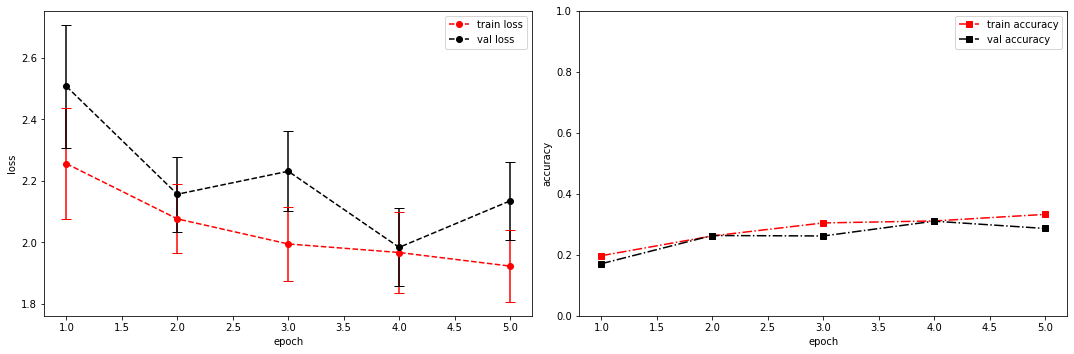

model saved
model saved


training epoch:  5
model set to train
Epoch [6/100], step [1/84],  Loss: 1.9945 +/- 0.0000,  accuracy: 0.0185546875, time elapsed = 0.2856285572052002s
Epoch [6/100], step [17/84],  Loss: 1.8761 +/- 0.0876,  accuracy: 0.345703125, time elapsed = 1.1755754947662354s
Epoch [6/100], step [33/84],  Loss: 1.8515 +/- 0.0823,  accuracy: 0.3330078125, time elapsed = 1.1735308170318604s
Epoch [6/100], step [49/84],  Loss: 1.8724 +/- 0.1371,  accuracy: 0.3623046875, time elapsed = 1.1883800029754639s
Epoch [6/100], step [65/84],  Loss: 1.9288 +/- 0.1723,  accuracy: 0.36328125, time elapsed = 1.1866681575775146s
Epoch [6/100], step [81/84],  Loss: 1.8950 +/- 0.1450,  accuracy: 0.3359375, time elapsed = 1.175318956375122s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.348,  precision = 0.348 recall = 0.348 f1 = 0.348 ::: val: acc = 0.360,  precision = 0.360 recall = 0.360 time elapsed = 8.036335468292236s


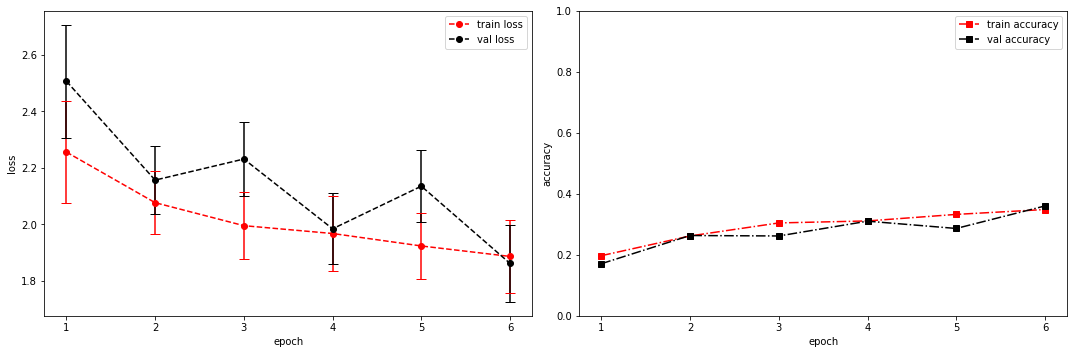

model saved


training epoch:  6
model set to train
Epoch [7/100], step [1/84],  Loss: 1.8931 +/- 0.0000,  accuracy: 0.0244140625, time elapsed = 0.28163599967956543s
Epoch [7/100], step [17/84],  Loss: 1.7961 +/- 0.1635,  accuracy: 0.408203125, time elapsed = 1.18638014793396s
Epoch [7/100], step [33/84],  Loss: 1.8553 +/- 0.1506,  accuracy: 0.3544921875, time elapsed = 1.185014009475708s
Epoch [7/100], step [49/84],  Loss: 1.8757 +/- 0.1637,  accuracy: 0.3408203125, time elapsed = 1.186485767364502s
Epoch [7/100], step [65/84],  Loss: 1.8696 +/- 0.1191,  accuracy: 0.330078125, time elapsed = 1.1719169616699219s
Epoch [7/100], step [81/84],  Loss: 1.8788 +/- 0.1031,  accuracy: 0.34765625, time elapsed = 1.1643216609954834s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.357,  precision = 0.357 recall = 0.357 f1 = 0.357 ::: val: acc = 0.370,  precision = 0.370 recall = 0.370 time elapsed = 8.025274515151978s


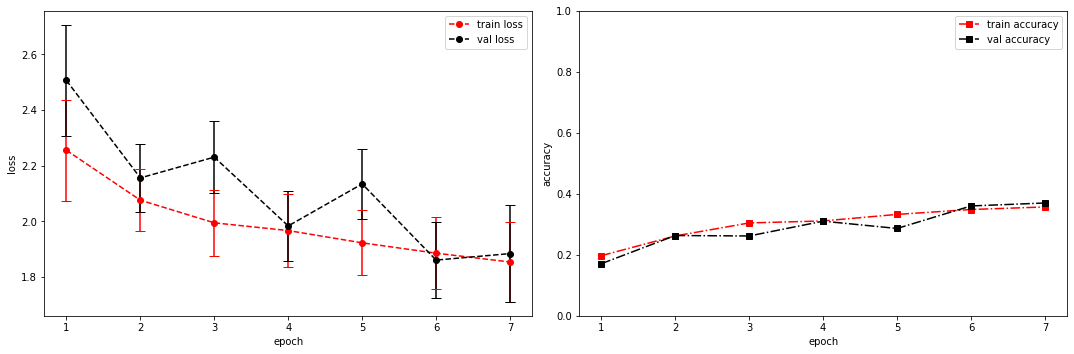

model saved


training epoch:  7
model set to train
Epoch [8/100], step [1/84],  Loss: 1.5099 +/- 0.0000,  accuracy: 0.03125, time elapsed = 0.2828032970428467s
Epoch [8/100], step [17/84],  Loss: 1.7808 +/- 0.1107,  accuracy: 0.3662109375, time elapsed = 1.1672394275665283s
Epoch [8/100], step [33/84],  Loss: 1.7891 +/- 0.1416,  accuracy: 0.3759765625, time elapsed = 1.1817677021026611s
Epoch [8/100], step [49/84],  Loss: 1.7992 +/- 0.0847,  accuracy: 0.3818359375, time elapsed = 1.1745741367340088s
Epoch [8/100], step [65/84],  Loss: 1.8349 +/- 0.1151,  accuracy: 0.3671875, time elapsed = 1.1709716320037842s
Epoch [8/100], step [81/84],  Loss: 1.7866 +/- 0.1364,  accuracy: 0.3740234375, time elapsed = 1.175731897354126s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.374,  precision = 0.374 recall = 0.374 f1 = 0.374 ::: val: acc = 0.346,  precision = 0.346 recall = 0.346 time elapsed = 8.061398983001709s


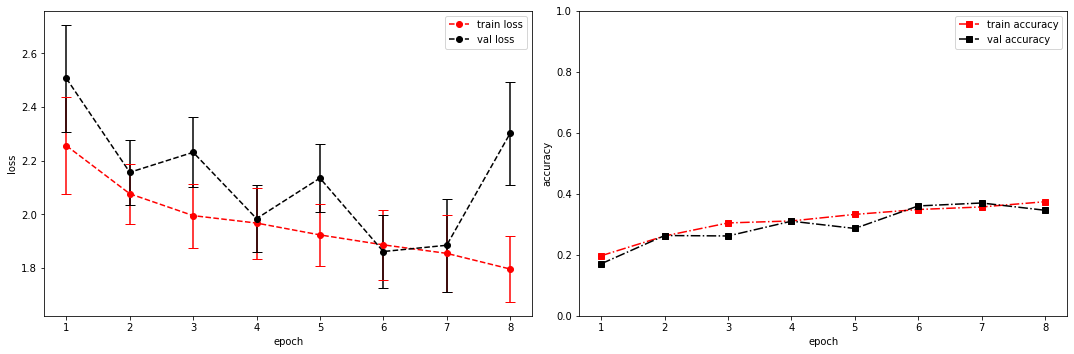

model saved
model saved


training epoch:  8
model set to train
Epoch [9/100], step [1/84],  Loss: 1.5785 +/- 0.0000,  accuracy: 0.0234375, time elapsed = 0.2786405086517334s
Epoch [9/100], step [17/84],  Loss: 1.6790 +/- 0.1369,  accuracy: 0.412109375, time elapsed = 1.2103192806243896s
Epoch [9/100], step [33/84],  Loss: 1.8662 +/- 0.1337,  accuracy: 0.3662109375, time elapsed = 1.1961524486541748s
Epoch [9/100], step [49/84],  Loss: 1.7652 +/- 0.1508,  accuracy: 0.3896484375, time elapsed = 1.1671130657196045s
Epoch [9/100], step [65/84],  Loss: 1.7810 +/- 0.0969,  accuracy: 0.3935546875, time elapsed = 1.2030391693115234s
Epoch [9/100], step [81/84],  Loss: 1.7453 +/- 0.1291,  accuracy: 0.384765625, time elapsed = 1.1583647727966309s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.391,  precision = 0.391 recall = 0.391 f1 = 0.391 ::: val: acc = 0.353,  precision = 0.353 recall = 0.353 time elapsed = 8.066349744796753s


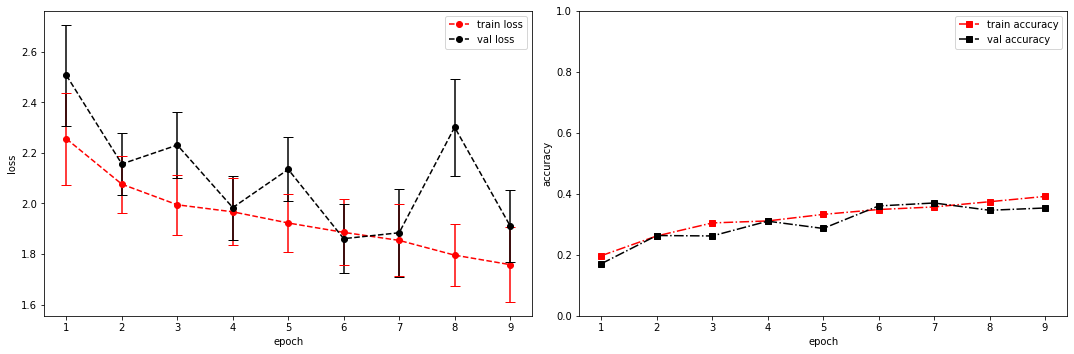

model saved


training epoch:  9
model set to train
Epoch [10/100], step [1/84],  Loss: 1.9453 +/- 0.0000,  accuracy: 0.021484375, time elapsed = 0.29382872581481934s
Epoch [10/100], step [17/84],  Loss: 1.7370 +/- 0.1669,  accuracy: 0.4052734375, time elapsed = 1.217578649520874s
Epoch [10/100], step [33/84],  Loss: 1.7223 +/- 0.1212,  accuracy: 0.4072265625, time elapsed = 1.1788928508758545s
Epoch [10/100], step [49/84],  Loss: 1.7055 +/- 0.1714,  accuracy: 0.396484375, time elapsed = 1.1635968685150146s
Epoch [10/100], step [65/84],  Loss: 1.6286 +/- 0.1273,  accuracy: 0.44140625, time elapsed = 1.1766390800476074s
Epoch [10/100], step [81/84],  Loss: 1.7402 +/- 0.1859,  accuracy: 0.41015625, time elapsed = 1.1353027820587158s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.409,  precision = 0.409 recall = 0.409 f1 = 0.409 ::: val: acc = 0.400,  precision = 0.400 recall = 0.400 time elapsed = 8.042383670806885s


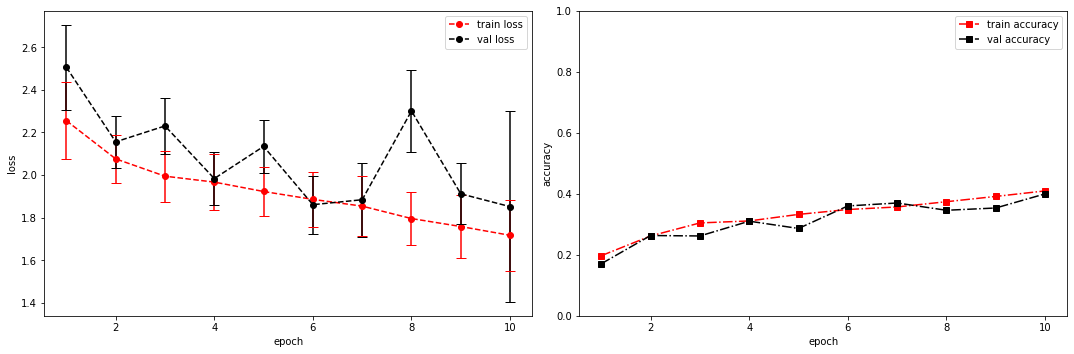

model saved


training epoch:  10
model set to train
Epoch [11/100], step [1/84],  Loss: 1.5362 +/- 0.0000,  accuracy: 0.0302734375, time elapsed = 0.2820878028869629s
Epoch [11/100], step [17/84],  Loss: 1.6521 +/- 0.1427,  accuracy: 0.4443359375, time elapsed = 1.2045137882232666s
Epoch [11/100], step [33/84],  Loss: 1.6849 +/- 0.1278,  accuracy: 0.42578125, time elapsed = 1.178239107131958s
Epoch [11/100], step [49/84],  Loss: 1.6133 +/- 0.1220,  accuracy: 0.4619140625, time elapsed = 1.1750092506408691s
Epoch [11/100], step [65/84],  Loss: 1.7711 +/- 0.1045,  accuracy: 0.4130859375, time elapsed = 1.1795125007629395s
Epoch [11/100], step [81/84],  Loss: 1.6882 +/- 0.1050,  accuracy: 0.4169921875, time elapsed = 1.1933073997497559s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.433,  precision = 0.433 recall = 0.433 f1 = 0.433 ::: val: acc = 0.380,  precision = 0.380 recall = 0.380 time elapsed = 8.091463327407837s


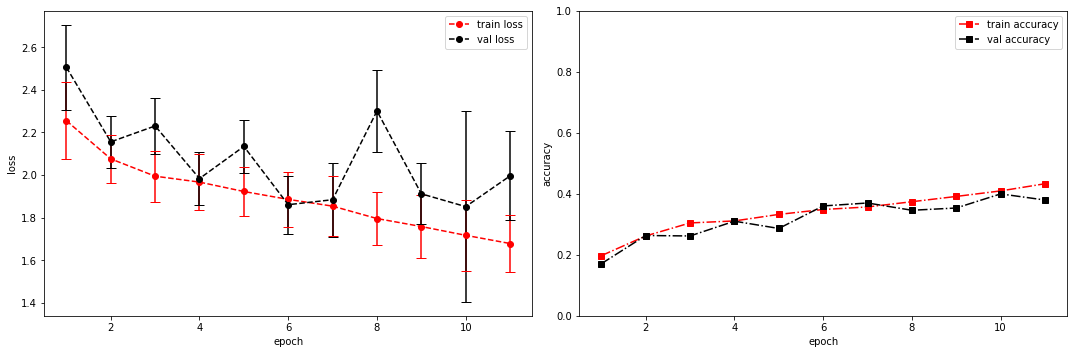

model saved
model saved


training epoch:  11
model set to train
Epoch [12/100], step [1/84],  Loss: 1.5442 +/- 0.0000,  accuracy: 0.0302734375, time elapsed = 0.2894744873046875s
Epoch [12/100], step [17/84],  Loss: 1.6062 +/- 0.1430,  accuracy: 0.447265625, time elapsed = 1.213651180267334s
Epoch [12/100], step [33/84],  Loss: 1.6677 +/- 0.1422,  accuracy: 0.4150390625, time elapsed = 1.1864614486694336s
Epoch [12/100], step [49/84],  Loss: 1.6844 +/- 0.1178,  accuracy: 0.421875, time elapsed = 1.18326735496521s
Epoch [12/100], step [65/84],  Loss: 1.5649 +/- 0.1468,  accuracy: 0.4619140625, time elapsed = 1.2151947021484375s
Epoch [12/100], step [81/84],  Loss: 1.6242 +/- 0.1696,  accuracy: 0.455078125, time elapsed = 1.1612906455993652s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.441,  precision = 0.441 recall = 0.441 f1 = 0.441 ::: val: acc = 0.363,  precision = 0.363 recall = 0.363 time elapsed = 8.116840124130249s


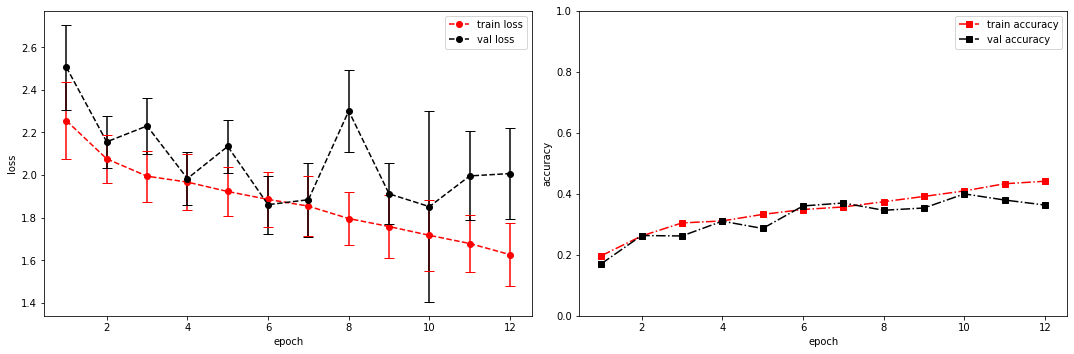

model saved
stopping early
device:  cuda
dataset metadata:  {'n_fft': 2048, 'hop_length': 256, 'n_mfcc': 13, 'notes': 'optional notes not passed'}
train model: data loaders initialized
sample shape =  (1, 13, 517)
model loaded
Layer (type:depth-idx)                   Output Shape              Param #
├─ConvBlock: 1-1                         [-1, 8, 6, 258]           --
|    └─Sequential: 2-1                   [-1, 8, 6, 258]           --
|    |    └─Conv2d: 3-1                  [-1, 8, 13, 517]          80
|    |    └─ReLU: 3-2                    [-1, 8, 13, 517]          --
|    |    └─MaxPool2d: 3-3               [-1, 8, 6, 258]           --
|    |    └─BatchNorm2d: 3-4             [-1, 8, 6, 258]           16
├─ConvBlock: 1-2                         [-1, 8, 3, 129]           --
|    └─Sequential: 2-2                   [-1, 8, 3, 129]           --
|    |    └─Conv2d: 3-5                  [-1, 8, 6, 258]           584
|    |    └─ReLU: 3-6                    [-1, 8, 6, 258]           

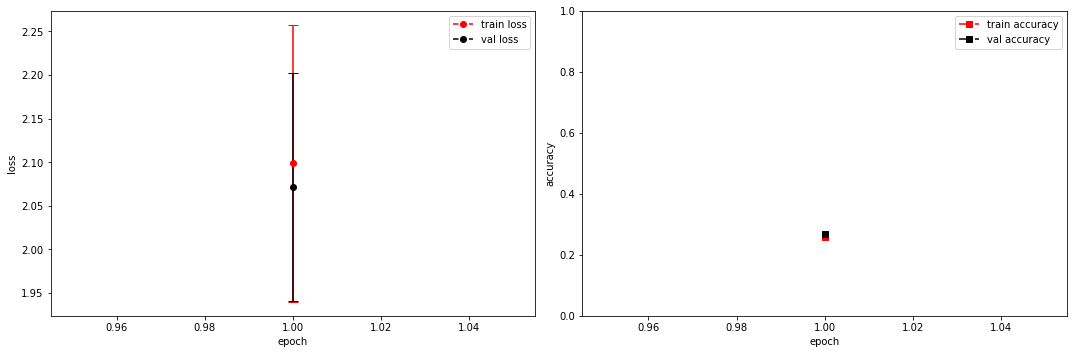

model saved


training epoch:  1
model set to train
Epoch [2/100], step [1/84],  Loss: 1.8887 +/- 0.0000,  accuracy: 0.0234375, time elapsed = 0.2761878967285156s
Epoch [2/100], step [17/84],  Loss: 1.9201 +/- 0.0814,  accuracy: 0.322265625, time elapsed = 1.1658272743225098s
Epoch [2/100], step [33/84],  Loss: 1.9172 +/- 0.0858,  accuracy: 0.3203125, time elapsed = 1.1886875629425049s
Epoch [2/100], step [49/84],  Loss: 1.9009 +/- 0.1212,  accuracy: 0.3125, time elapsed = 1.1765074729919434s
Epoch [2/100], step [65/84],  Loss: 1.9707 +/- 0.1291,  accuracy: 0.3232421875, time elapsed = 1.2002685070037842s
Epoch [2/100], step [81/84],  Loss: 1.9260 +/- 0.0928,  accuracy: 0.3330078125, time elapsed = 1.1750600337982178s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.326,  precision = 0.326 recall = 0.326 f1 = 0.326 ::: val: acc = 0.308,  precision = 0.308 recall = 0.308 time elapsed = 8.038221597671509s


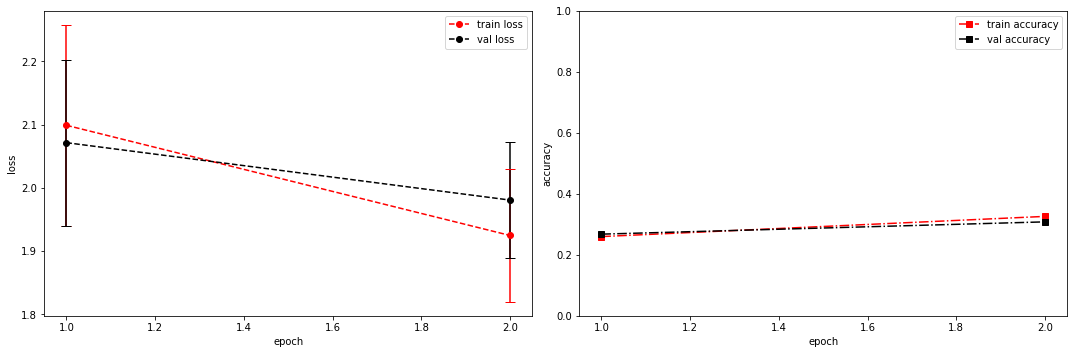

model saved


training epoch:  2
model set to train
Epoch [3/100], step [1/84],  Loss: 1.7925 +/- 0.0000,  accuracy: 0.0224609375, time elapsed = 0.2825472354888916s
Epoch [3/100], step [17/84],  Loss: 1.8643 +/- 0.1479,  accuracy: 0.3408203125, time elapsed = 1.1747281551361084s
Epoch [3/100], step [33/84],  Loss: 1.9290 +/- 0.1469,  accuracy: 0.32421875, time elapsed = 1.2195463180541992s
Epoch [3/100], step [49/84],  Loss: 1.9340 +/- 0.1039,  accuracy: 0.3251953125, time elapsed = 1.192579746246338s
Epoch [3/100], step [65/84],  Loss: 1.8471 +/- 0.0979,  accuracy: 0.3701171875, time elapsed = 1.1740410327911377s
Epoch [3/100], step [81/84],  Loss: 1.8992 +/- 0.1368,  accuracy: 0.3515625, time elapsed = 1.1930103302001953s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.343,  precision = 0.343 recall = 0.343 f1 = 0.343 ::: val: acc = 0.346,  precision = 0.346 recall = 0.346 time elapsed = 8.094219207763672s


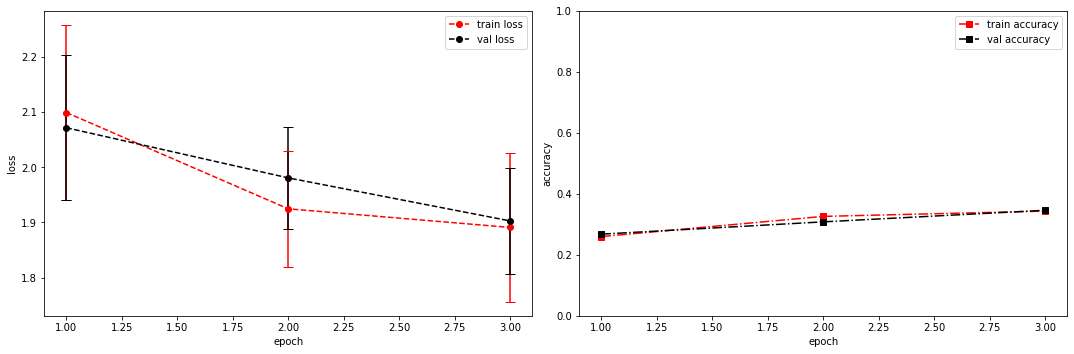

model saved


training epoch:  3
model set to train
Epoch [4/100], step [1/84],  Loss: 1.7301 +/- 0.0000,  accuracy: 0.0263671875, time elapsed = 0.27907395362854004s
Epoch [4/100], step [17/84],  Loss: 1.7864 +/- 0.1146,  accuracy: 0.3857421875, time elapsed = 1.1813311576843262s
Epoch [4/100], step [33/84],  Loss: 1.7801 +/- 0.1239,  accuracy: 0.3896484375, time elapsed = 1.2062828540802002s
Epoch [4/100], step [49/84],  Loss: 1.7963 +/- 0.1004,  accuracy: 0.3701171875, time elapsed = 1.1775233745574951s
Epoch [4/100], step [65/84],  Loss: 1.7921 +/- 0.1125,  accuracy: 0.39453125, time elapsed = 1.18752121925354s
Epoch [4/100], step [81/84],  Loss: 1.7946 +/- 0.1722,  accuracy: 0.384765625, time elapsed = 1.1724481582641602s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.384,  precision = 0.384 recall = 0.384 f1 = 0.384 ::: val: acc = 0.377,  precision = 0.377 recall = 0.377 time elapsed = 8.075244665145874s


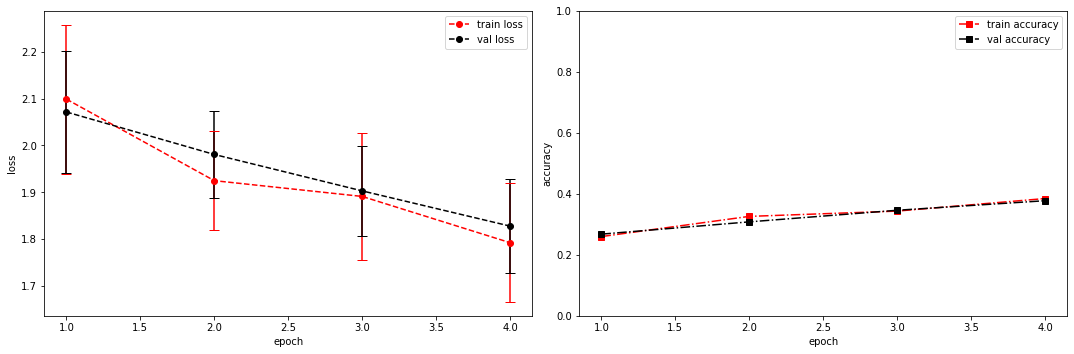

model saved


training epoch:  4
model set to train
Epoch [5/100], step [1/84],  Loss: 1.6805 +/- 0.0000,  accuracy: 0.02734375, time elapsed = 0.28078699111938477s
Epoch [5/100], step [17/84],  Loss: 1.7001 +/- 0.0965,  accuracy: 0.41015625, time elapsed = 1.2119648456573486s
Epoch [5/100], step [33/84],  Loss: 1.7454 +/- 0.1127,  accuracy: 0.37890625, time elapsed = 1.2079946994781494s
Epoch [5/100], step [49/84],  Loss: 1.7711 +/- 0.1247,  accuracy: 0.3720703125, time elapsed = 1.207273244857788s
Epoch [5/100], step [65/84],  Loss: 1.6820 +/- 0.1241,  accuracy: 0.4169921875, time elapsed = 1.2135255336761475s
Epoch [5/100], step [81/84],  Loss: 1.7411 +/- 0.1363,  accuracy: 0.4013671875, time elapsed = 1.201932430267334s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.398,  precision = 0.398 recall = 0.398 f1 = 0.398 ::: val: acc = 0.404,  precision = 0.404 recall = 0.404 time elapsed = 8.195945978164673s


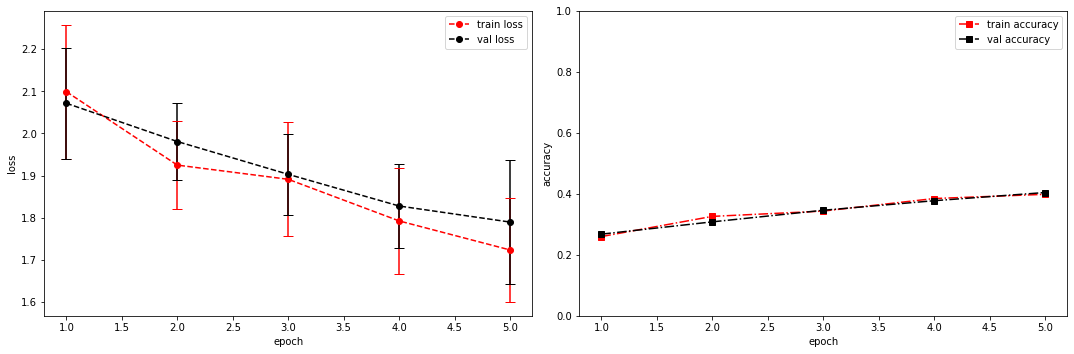

model saved


training epoch:  5
model set to train
Epoch [6/100], step [1/84],  Loss: 1.6392 +/- 0.0000,  accuracy: 0.02734375, time elapsed = 0.2865273952484131s
Epoch [6/100], step [17/84],  Loss: 1.6616 +/- 0.1368,  accuracy: 0.4345703125, time elapsed = 1.1865367889404297s
Epoch [6/100], step [33/84],  Loss: 1.6798 +/- 0.1618,  accuracy: 0.4150390625, time elapsed = 1.1686267852783203s
Epoch [6/100], step [49/84],  Loss: 1.6797 +/- 0.1593,  accuracy: 0.4345703125, time elapsed = 1.1806561946868896s
Epoch [6/100], step [65/84],  Loss: 1.5850 +/- 0.1335,  accuracy: 0.474609375, time elapsed = 1.2165358066558838s
Epoch [6/100], step [81/84],  Loss: 1.6723 +/- 0.1097,  accuracy: 0.4287109375, time elapsed = 1.1621193885803223s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.439,  precision = 0.439 recall = 0.439 f1 = 0.439 ::: val: acc = 0.376,  precision = 0.376 recall = 0.376 time elapsed = 8.072513341903687s


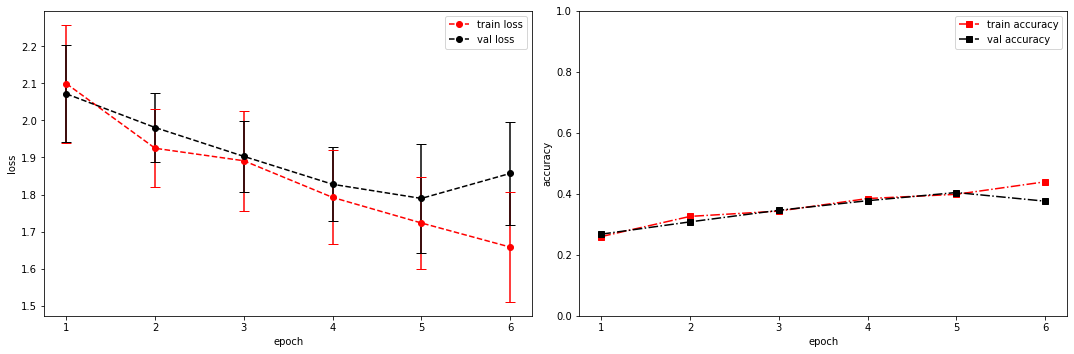

model saved


training epoch:  6
model set to train
Epoch [7/100], step [1/84],  Loss: 1.5973 +/- 0.0000,  accuracy: 0.0244140625, time elapsed = 0.278853178024292s
Epoch [7/100], step [17/84],  Loss: 1.5593 +/- 0.1200,  accuracy: 0.46484375, time elapsed = 1.2015736103057861s
Epoch [7/100], step [33/84],  Loss: 1.6503 +/- 0.1798,  accuracy: 0.44140625, time elapsed = 1.1619040966033936s
Epoch [7/100], step [49/84],  Loss: 1.6121 +/- 0.1218,  accuracy: 0.44140625, time elapsed = 1.1799228191375732s
Epoch [7/100], step [65/84],  Loss: 1.5602 +/- 0.1962,  accuracy: 0.46875, time elapsed = 1.1814546585083008s
Epoch [7/100], step [81/84],  Loss: 1.5989 +/- 0.0930,  accuracy: 0.4365234375, time elapsed = 1.2107818126678467s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.451,  precision = 0.451 recall = 0.451 f1 = 0.451 ::: val: acc = 0.453,  precision = 0.453 recall = 0.453 time elapsed = 8.101585626602173s


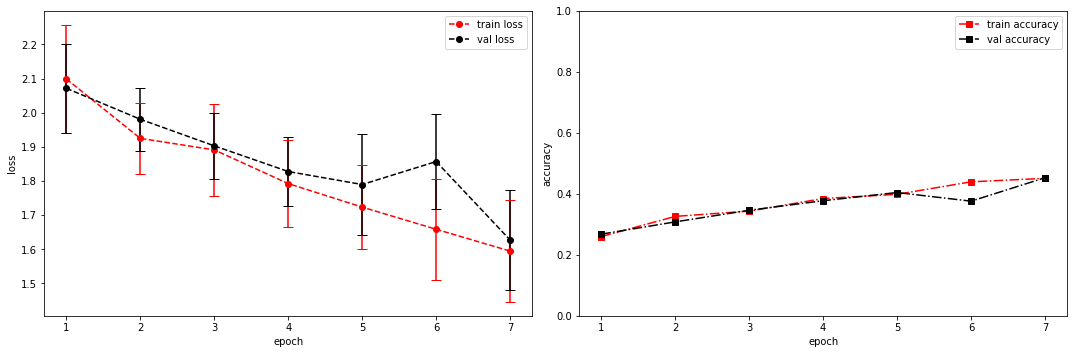

model saved


training epoch:  7
model set to train
Epoch [8/100], step [1/84],  Loss: 1.3948 +/- 0.0000,  accuracy: 0.033203125, time elapsed = 0.27933359146118164s
Epoch [8/100], step [17/84],  Loss: 1.4934 +/- 0.1643,  accuracy: 0.48046875, time elapsed = 1.181899070739746s
Epoch [8/100], step [33/84],  Loss: 1.4444 +/- 0.1302,  accuracy: 0.4892578125, time elapsed = 1.185647964477539s
Epoch [8/100], step [49/84],  Loss: 1.5802 +/- 0.1594,  accuracy: 0.4658203125, time elapsed = 1.1891143321990967s
Epoch [8/100], step [65/84],  Loss: 1.5621 +/- 0.1248,  accuracy: 0.45703125, time elapsed = 1.1805698871612549s
Epoch [8/100], step [81/84],  Loss: 1.5494 +/- 0.0968,  accuracy: 0.48046875, time elapsed = 1.205019474029541s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.473,  precision = 0.473 recall = 0.473 f1 = 0.473 ::: val: acc = 0.418,  precision = 0.418 recall = 0.418 time elapsed = 8.138018131256104s


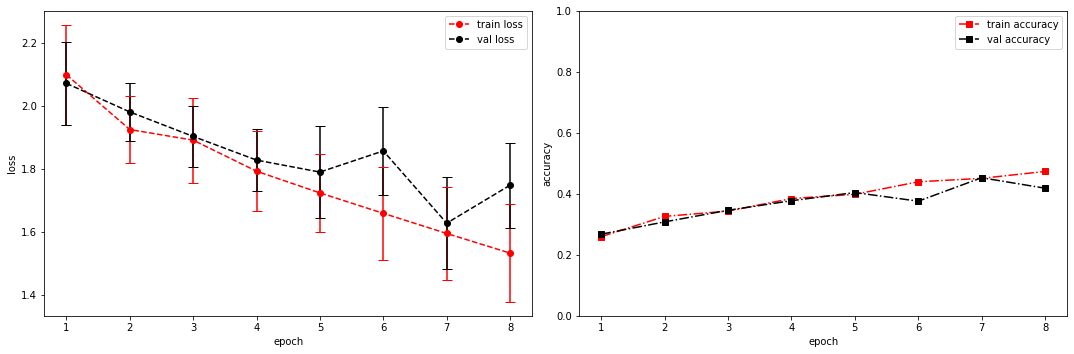

model saved


training epoch:  8
model set to train
Epoch [9/100], step [1/84],  Loss: 1.3884 +/- 0.0000,  accuracy: 0.033203125, time elapsed = 0.2925565242767334s
Epoch [9/100], step [17/84],  Loss: 1.4058 +/- 0.1148,  accuracy: 0.53125, time elapsed = 1.1815245151519775s
Epoch [9/100], step [33/84],  Loss: 1.4671 +/- 0.1467,  accuracy: 0.509765625, time elapsed = 1.1839592456817627s
Epoch [9/100], step [49/84],  Loss: 1.4629 +/- 0.1245,  accuracy: 0.5009765625, time elapsed = 1.1687722206115723s
Epoch [9/100], step [65/84],  Loss: 1.4998 +/- 0.1680,  accuracy: 0.482421875, time elapsed = 1.1926398277282715s
Epoch [9/100], step [81/84],  Loss: 1.5047 +/- 0.1185,  accuracy: 0.48046875, time elapsed = 1.1547234058380127s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.501,  precision = 0.501 recall = 0.501 f1 = 0.501 ::: val: acc = 0.443,  precision = 0.443 recall = 0.443 time elapsed = 8.011006355285645s


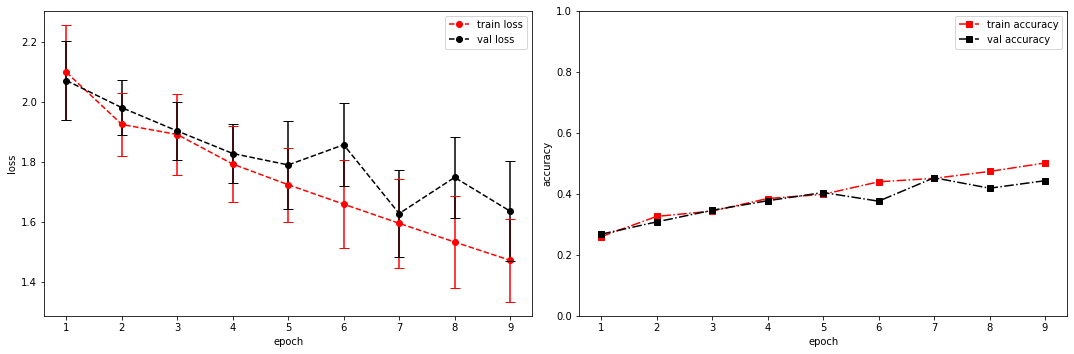

model saved


training epoch:  9
model set to train
Epoch [10/100], step [1/84],  Loss: 1.2605 +/- 0.0000,  accuracy: 0.037109375, time elapsed = 0.29401087760925293s
Epoch [10/100], step [17/84],  Loss: 1.2925 +/- 0.1492,  accuracy: 0.5625, time elapsed = 1.184446096420288s
Epoch [10/100], step [33/84],  Loss: 1.3244 +/- 0.1299,  accuracy: 0.5390625, time elapsed = 1.1855297088623047s
Epoch [10/100], step [49/84],  Loss: 1.4508 +/- 0.1217,  accuracy: 0.4990234375, time elapsed = 1.1782186031341553s
Epoch [10/100], step [65/84],  Loss: 1.4525 +/- 0.1524,  accuracy: 0.5009765625, time elapsed = 1.1663320064544678s
Epoch [10/100], step [81/84],  Loss: 1.4602 +/- 0.1299,  accuracy: 0.513671875, time elapsed = 1.1538968086242676s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.526,  precision = 0.526 recall = 0.526 f1 = 0.526 ::: val: acc = 0.456,  precision = 0.456 recall = 0.456 time elapsed = 8.020447015762329s


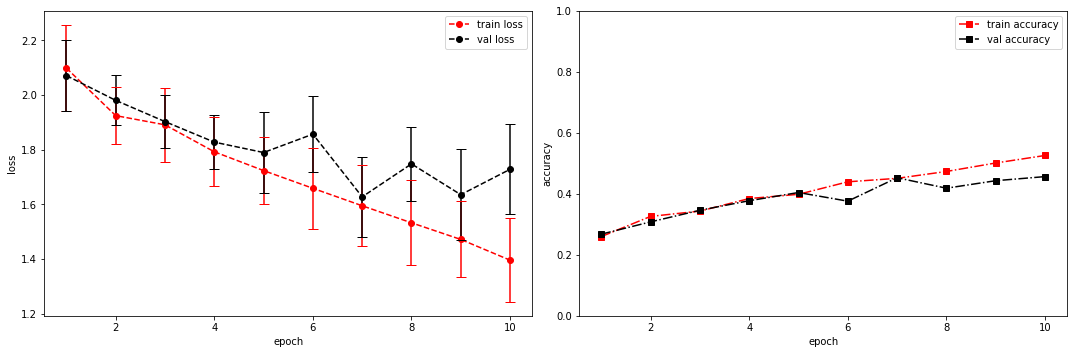

model saved
model saved


training epoch:  10
model set to train
Epoch [11/100], step [1/84],  Loss: 1.1758 +/- 0.0000,  accuracy: 0.0380859375, time elapsed = 0.2865574359893799s
Epoch [11/100], step [17/84],  Loss: 1.2819 +/- 0.1379,  accuracy: 0.5595703125, time elapsed = 1.1947100162506104s
Epoch [11/100], step [33/84],  Loss: 1.3197 +/- 0.1603,  accuracy: 0.5634765625, time elapsed = 1.2066280841827393s
Epoch [11/100], step [49/84],  Loss: 1.2809 +/- 0.1269,  accuracy: 0.5556640625, time elapsed = 1.2094149589538574s
Epoch [11/100], step [65/84],  Loss: 1.3628 +/- 0.2025,  accuracy: 0.54296875, time elapsed = 1.1825642585754395s
Epoch [11/100], step [81/84],  Loss: 1.2992 +/- 0.1434,  accuracy: 0.55859375, time elapsed = 1.1632044315338135s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.556,  precision = 0.556 recall = 0.556 f1 = 0.556 ::: val: acc = 0.424,  precision = 0.424 recall = 0.424 time elapsed = 8.082732439041138s


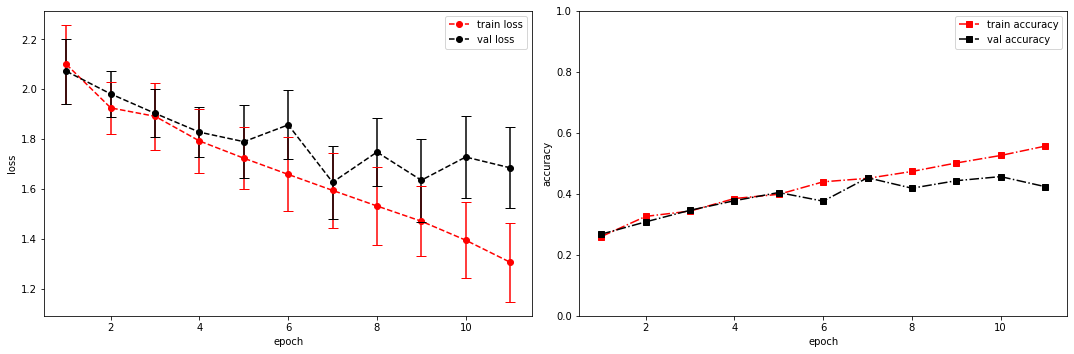

model saved
stopping early
device:  cuda
dataset metadata:  {'n_fft': 2048, 'hop_length': 256, 'n_mfcc': 13, 'notes': 'optional notes not passed'}
train model: data loaders initialized
sample shape =  (1, 13, 517)
model loaded
Layer (type:depth-idx)                   Output Shape              Param #
├─ConvBlock: 1-1                         [-1, 8, 6, 258]           --
|    └─Sequential: 2-1                   [-1, 8, 6, 258]           --
|    |    └─Conv2d: 3-1                  [-1, 8, 13, 517]          80
|    |    └─ReLU: 3-2                    [-1, 8, 13, 517]          --
|    |    └─MaxPool2d: 3-3               [-1, 8, 6, 258]           --
|    |    └─BatchNorm2d: 3-4             [-1, 8, 6, 258]           16
├─ConvBlock: 1-2                         [-1, 8, 3, 129]           --
|    └─Sequential: 2-2                   [-1, 8, 3, 129]           --
|    |    └─Conv2d: 3-5                  [-1, 8, 6, 258]           584
|    |    └─ReLU: 3-6                    [-1, 8, 6, 258]           

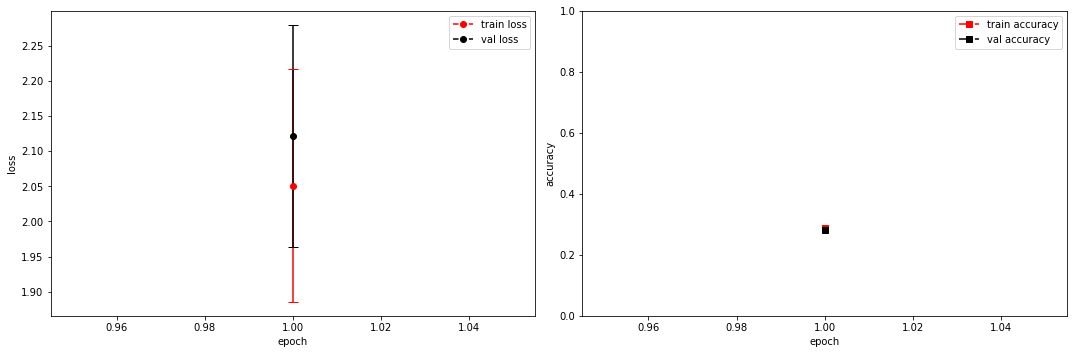

model saved


training epoch:  1
model set to train
Epoch [2/100], step [1/84],  Loss: 1.9490 +/- 0.0000,  accuracy: 0.0205078125, time elapsed = 0.29354000091552734s
Epoch [2/100], step [17/84],  Loss: 1.8823 +/- 0.1429,  accuracy: 0.345703125, time elapsed = 1.16402268409729s
Epoch [2/100], step [33/84],  Loss: 1.8631 +/- 0.1368,  accuracy: 0.345703125, time elapsed = 1.188246250152588s
Epoch [2/100], step [49/84],  Loss: 1.7783 +/- 0.0921,  accuracy: 0.3828125, time elapsed = 1.2015578746795654s
Epoch [2/100], step [65/84],  Loss: 1.8415 +/- 0.1040,  accuracy: 0.3828125, time elapsed = 1.134958267211914s
Epoch [2/100], step [81/84],  Loss: 1.8183 +/- 0.1260,  accuracy: 0.3740234375, time elapsed = 1.197829246520996s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.365,  precision = 0.365 recall = 0.365 f1 = 0.365 ::: val: acc = 0.296,  precision = 0.296 recall = 0.296 time elapsed = 8.046830415725708s


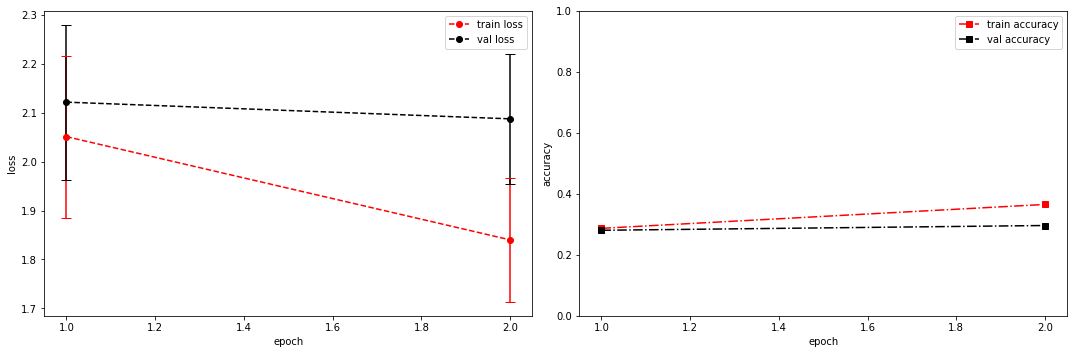

model saved


training epoch:  2
model set to train
Epoch [3/100], step [1/84],  Loss: 1.7845 +/- 0.0000,  accuracy: 0.0244140625, time elapsed = 0.2835676670074463s
Epoch [3/100], step [17/84],  Loss: 1.7821 +/- 0.1109,  accuracy: 0.4013671875, time elapsed = 1.1785435676574707s
Epoch [3/100], step [33/84],  Loss: 1.7887 +/- 0.1487,  accuracy: 0.37890625, time elapsed = 1.2035009860992432s
Epoch [3/100], step [49/84],  Loss: 1.7244 +/- 0.1529,  accuracy: 0.3994140625, time elapsed = 1.180450677871704s
Epoch [3/100], step [65/84],  Loss: 1.6651 +/- 0.1328,  accuracy: 0.435546875, time elapsed = 1.2466461658477783s
Epoch [3/100], step [81/84],  Loss: 1.7389 +/- 0.1179,  accuracy: 0.4130859375, time elapsed = 1.1604547500610352s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.404,  precision = 0.404 recall = 0.404 f1 = 0.404 ::: val: acc = 0.373,  precision = 0.373 recall = 0.373 time elapsed = 8.098482608795166s


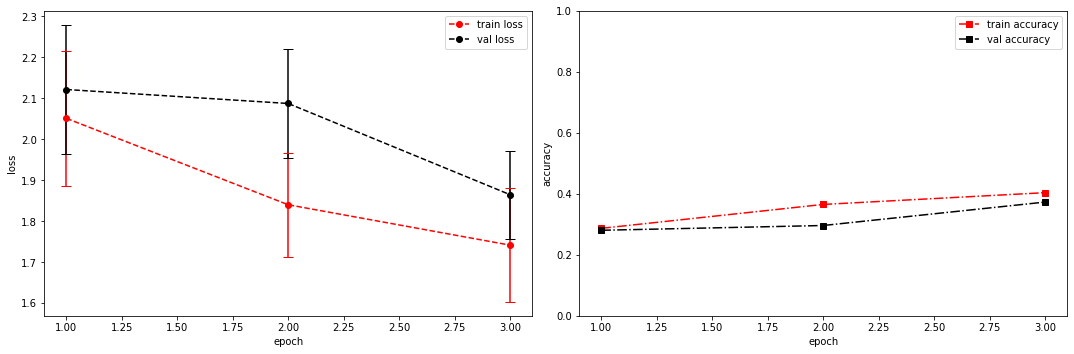

model saved


training epoch:  3
model set to train
Epoch [4/100], step [1/84],  Loss: 1.8492 +/- 0.0000,  accuracy: 0.0205078125, time elapsed = 0.3013491630554199s
Epoch [4/100], step [17/84],  Loss: 1.6364 +/- 0.0897,  accuracy: 0.4384765625, time elapsed = 1.1822786331176758s
Epoch [4/100], step [33/84],  Loss: 1.6458 +/- 0.1201,  accuracy: 0.427734375, time elapsed = 1.2019095420837402s
Epoch [4/100], step [49/84],  Loss: 1.7047 +/- 0.1154,  accuracy: 0.431640625, time elapsed = 1.1928389072418213s
Epoch [4/100], step [65/84],  Loss: 1.7067 +/- 0.1316,  accuracy: 0.419921875, time elapsed = 1.1668336391448975s
Epoch [4/100], step [81/84],  Loss: 1.6866 +/- 0.1168,  accuracy: 0.4111328125, time elapsed = 1.1488454341888428s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.426,  precision = 0.426 recall = 0.426 f1 = 0.426 ::: val: acc = 0.386,  precision = 0.386 recall = 0.386 time elapsed = 8.072817325592041s


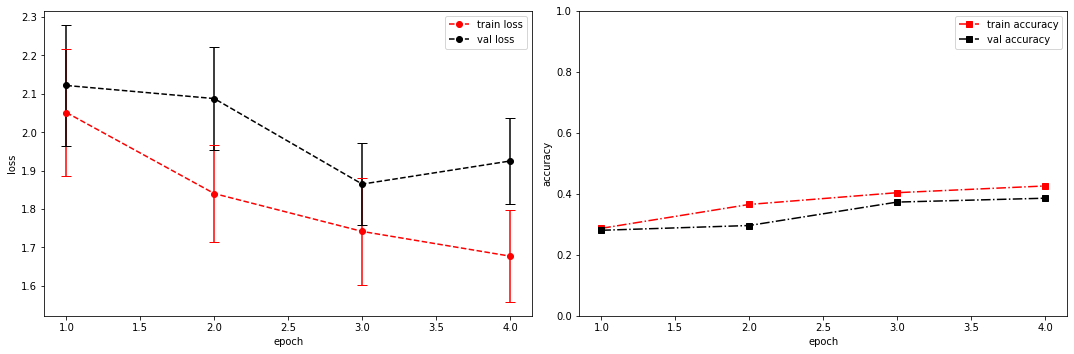

model saved


training epoch:  4
model set to train
Epoch [5/100], step [1/84],  Loss: 1.4777 +/- 0.0000,  accuracy: 0.0302734375, time elapsed = 0.2894163131713867s
Epoch [5/100], step [17/84],  Loss: 1.5455 +/- 0.1263,  accuracy: 0.474609375, time elapsed = 1.1983680725097656s
Epoch [5/100], step [33/84],  Loss: 1.6263 +/- 0.1311,  accuracy: 0.4541015625, time elapsed = 1.2041747570037842s
Epoch [5/100], step [49/84],  Loss: 1.5686 +/- 0.1116,  accuracy: 0.46875, time elapsed = 1.152771234512329s
Epoch [5/100], step [65/84],  Loss: 1.6229 +/- 0.1174,  accuracy: 0.44140625, time elapsed = 1.1990344524383545s
Epoch [5/100], step [81/84],  Loss: 1.6241 +/- 0.1184,  accuracy: 0.447265625, time elapsed = 1.1625902652740479s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.457,  precision = 0.457 recall = 0.457 f1 = 0.457 ::: val: acc = 0.428,  precision = 0.428 recall = 0.428 time elapsed = 8.117904663085938s


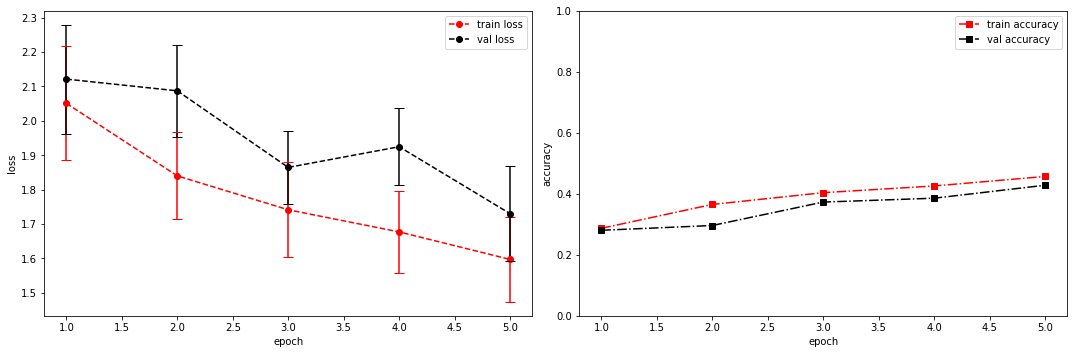

model saved


training epoch:  5
model set to train
Epoch [6/100], step [1/84],  Loss: 1.6131 +/- 0.0000,  accuracy: 0.0263671875, time elapsed = 0.302274227142334s
Epoch [6/100], step [17/84],  Loss: 1.5209 +/- 0.1604,  accuracy: 0.486328125, time elapsed = 1.2092838287353516s
Epoch [6/100], step [33/84],  Loss: 1.4221 +/- 0.1304,  accuracy: 0.5234375, time elapsed = 1.1594226360321045s
Epoch [6/100], step [49/84],  Loss: 1.5211 +/- 0.1329,  accuracy: 0.4814453125, time elapsed = 1.1737377643585205s
Epoch [6/100], step [65/84],  Loss: 1.5281 +/- 0.1077,  accuracy: 0.46484375, time elapsed = 1.1751697063446045s
Epoch [6/100], step [81/84],  Loss: 1.6060 +/- 0.1770,  accuracy: 0.4658203125, time elapsed = 1.165285587310791s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.483,  precision = 0.483 recall = 0.483 f1 = 0.483 ::: val: acc = 0.406,  precision = 0.406 recall = 0.406 time elapsed = 8.06271743774414s


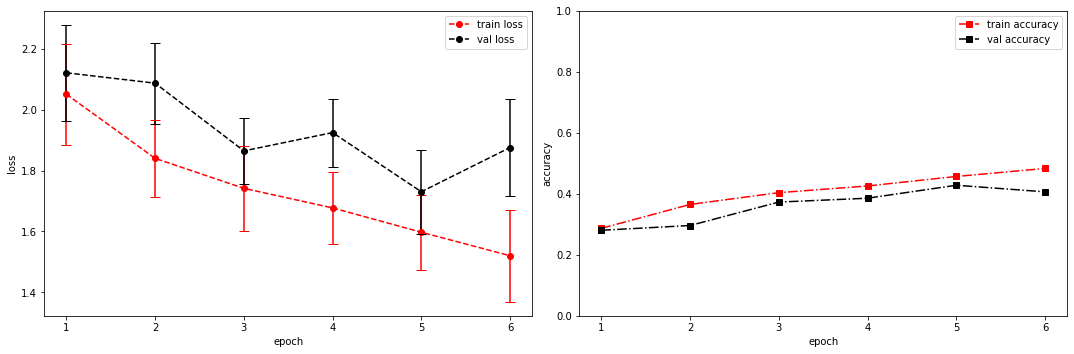

model saved
model saved


training epoch:  6
model set to train
Epoch [7/100], step [1/84],  Loss: 1.4319 +/- 0.0000,  accuracy: 0.0322265625, time elapsed = 0.2819969654083252s
Epoch [7/100], step [17/84],  Loss: 1.4473 +/- 0.1535,  accuracy: 0.517578125, time elapsed = 1.1694393157958984s
Epoch [7/100], step [33/84],  Loss: 1.4070 +/- 0.1411,  accuracy: 0.517578125, time elapsed = 1.196460485458374s
Epoch [7/100], step [49/84],  Loss: 1.4455 +/- 0.1120,  accuracy: 0.5107421875, time elapsed = 1.1542308330535889s
Epoch [7/100], step [65/84],  Loss: 1.4273 +/- 0.1453,  accuracy: 0.5302734375, time elapsed = 1.1923601627349854s
Epoch [7/100], step [81/84],  Loss: 1.4665 +/- 0.1344,  accuracy: 0.5078125, time elapsed = 1.1643171310424805s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.516,  precision = 0.516 recall = 0.516 f1 = 0.516 ::: val: acc = 0.427,  precision = 0.427 recall = 0.427 time elapsed = 8.028735637664795s


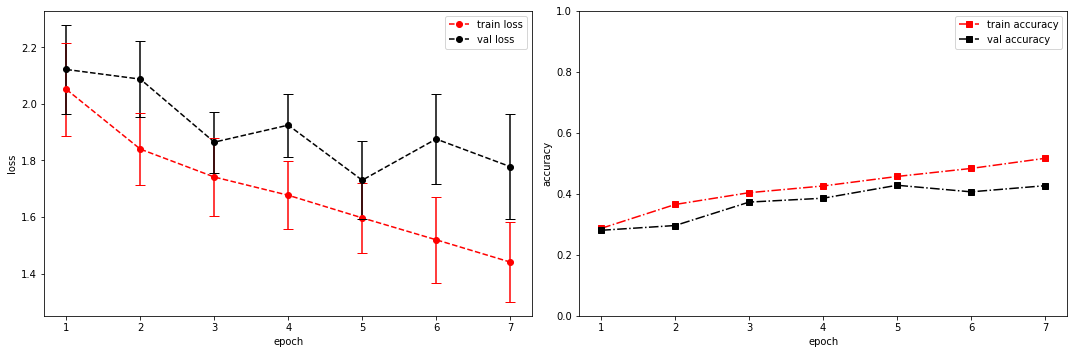

model saved
stopping early
device:  cuda
dataset metadata:  {'n_fft': 2048, 'hop_length': 256, 'n_mfcc': 13, 'notes': 'optional notes not passed'}
train model: data loaders initialized
sample shape =  (1, 13, 517)
model loaded
Layer (type:depth-idx)                   Output Shape              Param #
├─ConvBlock: 1-1                         [-1, 8, 6, 258]           --
|    └─Sequential: 2-1                   [-1, 8, 6, 258]           --
|    |    └─Conv2d: 3-1                  [-1, 8, 13, 517]          80
|    |    └─ReLU: 3-2                    [-1, 8, 13, 517]          --
|    |    └─MaxPool2d: 3-3               [-1, 8, 6, 258]           --
|    |    └─BatchNorm2d: 3-4             [-1, 8, 6, 258]           16
├─ConvBlock: 1-2                         [-1, 8, 3, 129]           --
|    └─Sequential: 2-2                   [-1, 8, 3, 129]           --
|    |    └─Conv2d: 3-5                  [-1, 8, 6, 258]           584
|    |    └─ReLU: 3-6                    [-1, 8, 6, 258]           

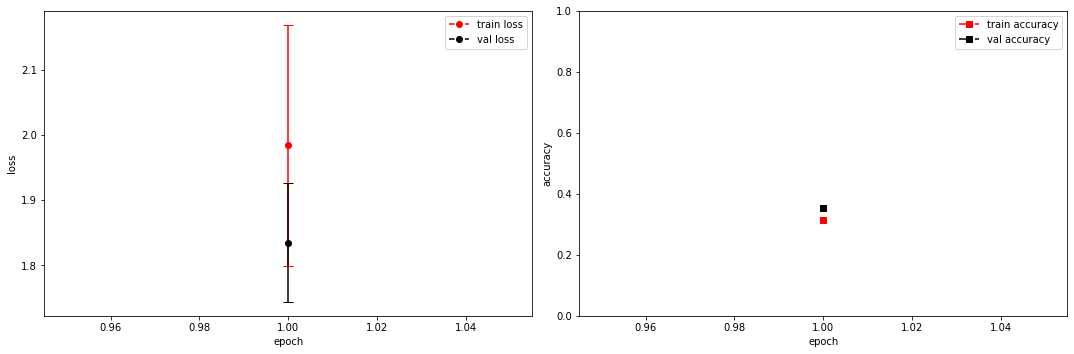

model saved


training epoch:  1
model set to train
Epoch [2/100], step [1/84],  Loss: 1.6787 +/- 0.0000,  accuracy: 0.025390625, time elapsed = 0.28588366508483887s
Epoch [2/100], step [17/84],  Loss: 1.7184 +/- 0.0915,  accuracy: 0.4228515625, time elapsed = 1.2092037200927734s
Epoch [2/100], step [33/84],  Loss: 1.7833 +/- 0.1128,  accuracy: 0.3720703125, time elapsed = 1.1973936557769775s
Epoch [2/100], step [49/84],  Loss: 1.7476 +/- 0.1212,  accuracy: 0.40625, time elapsed = 1.1667983531951904s
Epoch [2/100], step [65/84],  Loss: 1.7137 +/- 0.1105,  accuracy: 0.416015625, time elapsed = 1.2105584144592285s
Epoch [2/100], step [81/84],  Loss: 1.6371 +/- 0.1309,  accuracy: 0.4560546875, time elapsed = 1.158188819885254s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.415,  precision = 0.415 recall = 0.415 f1 = 0.415 ::: val: acc = 0.359,  precision = 0.359 recall = 0.359 time elapsed = 8.107802629470825s


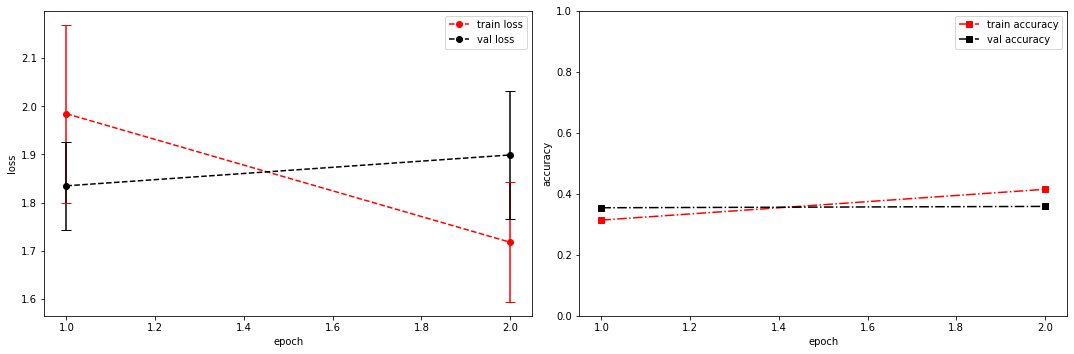

model saved


training epoch:  2
model set to train
Epoch [3/100], step [1/84],  Loss: 1.4861 +/- 0.0000,  accuracy: 0.0283203125, time elapsed = 0.3046691417694092s
Epoch [3/100], step [17/84],  Loss: 1.5669 +/- 0.1020,  accuracy: 0.4541015625, time elapsed = 1.1967236995697021s
Epoch [3/100], step [33/84],  Loss: 1.6074 +/- 0.1244,  accuracy: 0.4580078125, time elapsed = 1.2732691764831543s
Epoch [3/100], step [49/84],  Loss: 1.5912 +/- 0.1095,  accuracy: 0.4560546875, time elapsed = 1.1888670921325684s
Epoch [3/100], step [65/84],  Loss: 1.5970 +/- 0.1123,  accuracy: 0.462890625, time elapsed = 1.1678731441497803s
Epoch [3/100], step [81/84],  Loss: 1.5259 +/- 0.1307,  accuracy: 0.4775390625, time elapsed = 1.1703717708587646s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.462,  precision = 0.462 recall = 0.462 f1 = 0.462 ::: val: acc = 0.372,  precision = 0.372 recall = 0.372 time elapsed = 8.143880605697632s


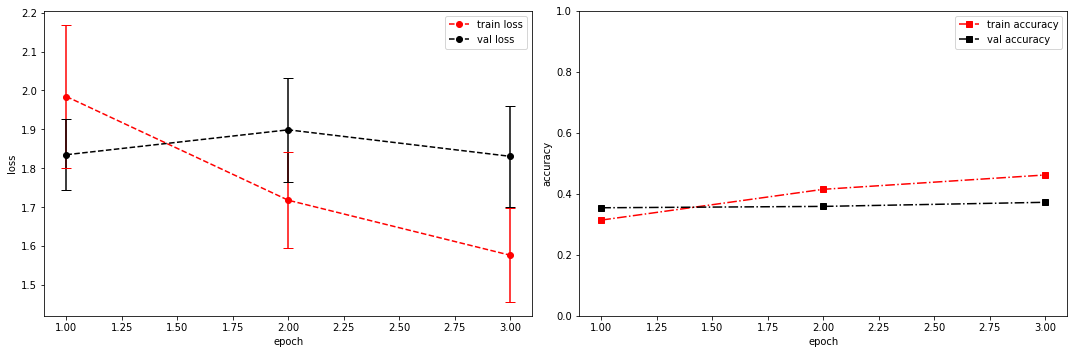

model saved


training epoch:  3
model set to train
Epoch [4/100], step [1/84],  Loss: 1.4395 +/- 0.0000,  accuracy: 0.02734375, time elapsed = 0.29181838035583496s
Epoch [4/100], step [17/84],  Loss: 1.3742 +/- 0.0755,  accuracy: 0.537109375, time elapsed = 1.1741752624511719s
Epoch [4/100], step [33/84],  Loss: 1.4474 +/- 0.1005,  accuracy: 0.5107421875, time elapsed = 1.1606743335723877s
Epoch [4/100], step [49/84],  Loss: 1.3632 +/- 0.1304,  accuracy: 0.544921875, time elapsed = 1.1534345149993896s
Epoch [4/100], step [65/84],  Loss: 1.4237 +/- 0.1102,  accuracy: 0.51953125, time elapsed = 1.1790692806243896s
Epoch [4/100], step [81/84],  Loss: 1.4295 +/- 0.1378,  accuracy: 0.5439453125, time elapsed = 1.1583383083343506s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.531,  precision = 0.531 recall = 0.531 f1 = 0.531 ::: val: acc = 0.374,  precision = 0.374 recall = 0.374 time elapsed = 7.971645355224609s


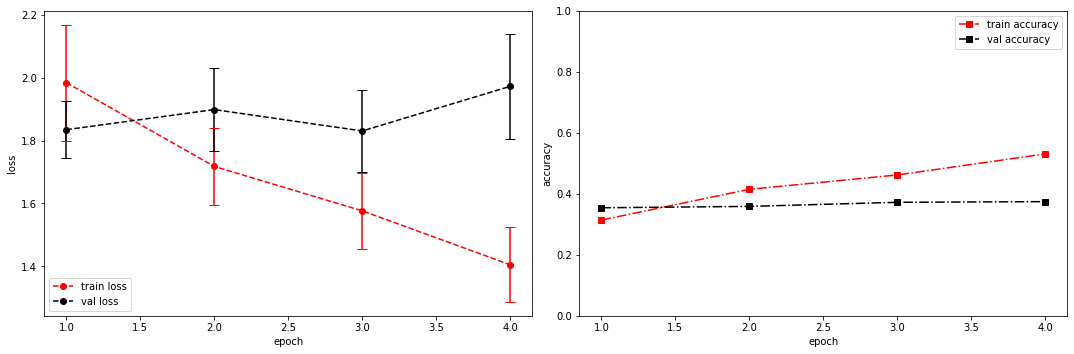

model saved


training epoch:  4
model set to train
Epoch [5/100], step [1/84],  Loss: 1.2602 +/- 0.0000,  accuracy: 0.0361328125, time elapsed = 0.2983522415161133s
Epoch [5/100], step [17/84],  Loss: 1.2226 +/- 0.1257,  accuracy: 0.5908203125, time elapsed = 1.2255091667175293s
Epoch [5/100], step [33/84],  Loss: 1.2701 +/- 0.1213,  accuracy: 0.59375, time elapsed = 1.169769525527954s
Epoch [5/100], step [49/84],  Loss: 1.2443 +/- 0.1194,  accuracy: 0.564453125, time elapsed = 1.1898441314697266s
Epoch [5/100], step [65/84],  Loss: 1.3430 +/- 0.1216,  accuracy: 0.5341796875, time elapsed = 1.2126774787902832s
Epoch [5/100], step [81/84],  Loss: 1.2851 +/- 0.1350,  accuracy: 0.5576171875, time elapsed = 1.176898717880249s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.567,  precision = 0.567 recall = 0.567 f1 = 0.567 ::: val: acc = 0.421,  precision = 0.421 recall = 0.421 time elapsed = 8.153227806091309s


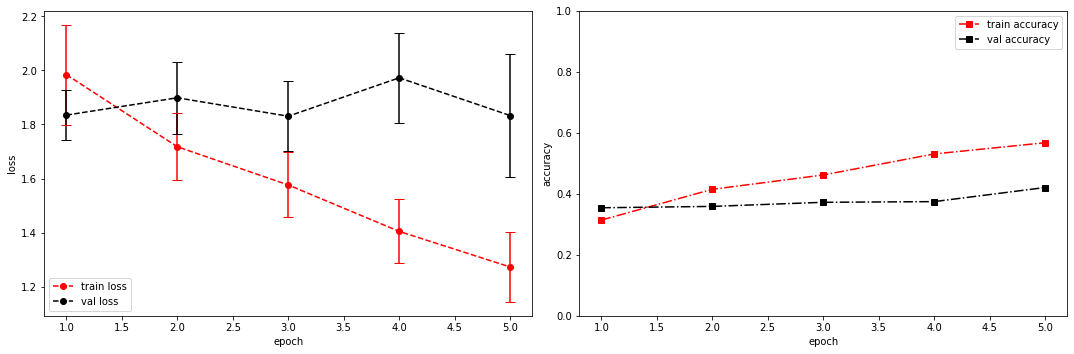

model saved
model saved


training epoch:  5
model set to train
Epoch [6/100], step [1/84],  Loss: 1.1410 +/- 0.0000,  accuracy: 0.0380859375, time elapsed = 0.2976105213165283s
Epoch [6/100], step [17/84],  Loss: 1.1239 +/- 0.1357,  accuracy: 0.63671875, time elapsed = 1.1686458587646484s
Epoch [6/100], step [33/84],  Loss: 1.1282 +/- 0.1396,  accuracy: 0.6279296875, time elapsed = 1.1554830074310303s
Epoch [6/100], step [49/84],  Loss: 1.1042 +/- 0.1754,  accuracy: 0.6337890625, time elapsed = 1.1382086277008057s
Epoch [6/100], step [65/84],  Loss: 1.1099 +/- 0.1206,  accuracy: 0.6259765625, time elapsed = 1.2037482261657715s
Epoch [6/100], step [81/84],  Loss: 1.1205 +/- 0.1184,  accuracy: 0.609375, time elapsed = 1.1460087299346924s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.624,  precision = 0.624 recall = 0.624 f1 = 0.624 ::: val: acc = 0.442,  precision = 0.442 recall = 0.442 time elapsed = 7.930585145950317s


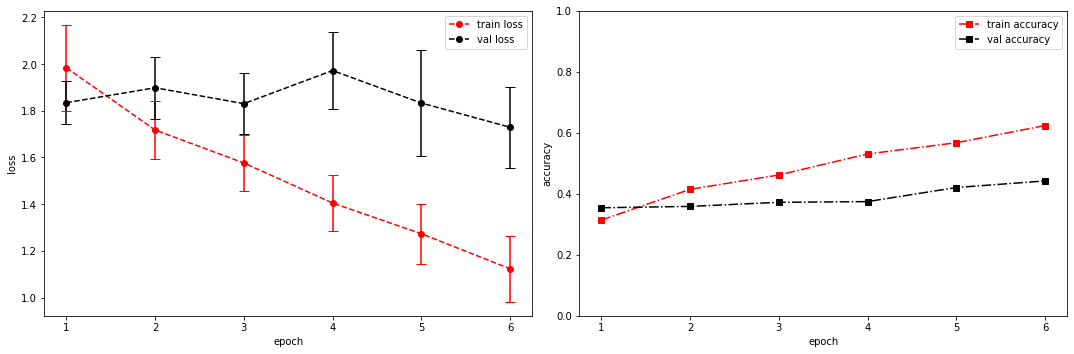

model saved
stopping early
device:  cuda
dataset metadata:  {'n_fft': 2048, 'hop_length': 256, 'n_mfcc': 13, 'notes': 'optional notes not passed'}
train model: data loaders initialized
sample shape =  (1, 13, 517)
model loaded
Layer (type:depth-idx)                   Output Shape              Param #
├─ConvBlock: 1-1                         [-1, 8, 6, 258]           --
|    └─Sequential: 2-1                   [-1, 8, 6, 258]           --
|    |    └─Conv2d: 3-1                  [-1, 8, 13, 517]          80
|    |    └─ReLU: 3-2                    [-1, 8, 13, 517]          --
|    |    └─MaxPool2d: 3-3               [-1, 8, 6, 258]           --
|    |    └─BatchNorm2d: 3-4             [-1, 8, 6, 258]           16
├─ConvBlock: 1-2                         [-1, 8, 3, 129]           --
|    └─Sequential: 2-2                   [-1, 8, 3, 129]           --
|    |    └─Conv2d: 3-5                  [-1, 8, 6, 258]           584
|    |    └─ReLU: 3-6                    [-1, 8, 6, 258]           

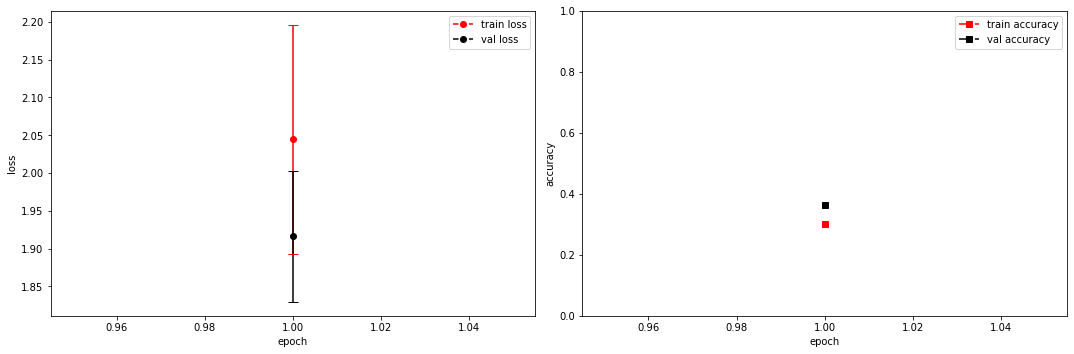

model saved


training epoch:  1
model set to train
Epoch [2/100], step [1/84],  Loss: 1.9856 +/- 0.0000,  accuracy: 0.0263671875, time elapsed = 0.2807433605194092s
Epoch [2/100], step [17/84],  Loss: 1.8082 +/- 0.1069,  accuracy: 0.3876953125, time elapsed = 1.1991629600524902s
Epoch [2/100], step [33/84],  Loss: 1.7658 +/- 0.0989,  accuracy: 0.4130859375, time elapsed = 1.2020275592803955s
Epoch [2/100], step [49/84],  Loss: 1.7564 +/- 0.1278,  accuracy: 0.423828125, time elapsed = 1.1896038055419922s
Epoch [2/100], step [65/84],  Loss: 1.7367 +/- 0.0855,  accuracy: 0.41015625, time elapsed = 1.1812384128570557s
Epoch [2/100], step [81/84],  Loss: 1.6927 +/- 0.1261,  accuracy: 0.439453125, time elapsed = 1.1711606979370117s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.414,  precision = 0.414 recall = 0.414 f1 = 0.414 ::: val: acc = 0.382,  precision = 0.382 recall = 0.382 time elapsed = 8.11020302772522s


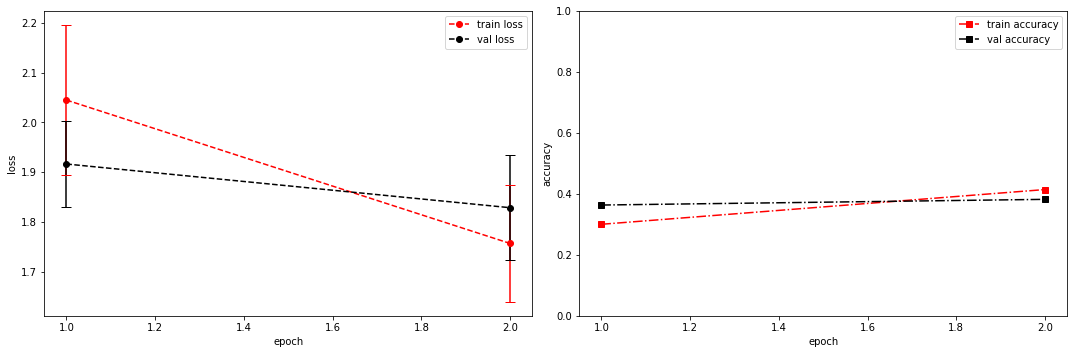

model saved


training epoch:  2
model set to train
Epoch [3/100], step [1/84],  Loss: 1.7847 +/- 0.0000,  accuracy: 0.021484375, time elapsed = 0.3031578063964844s
Epoch [3/100], step [17/84],  Loss: 1.6007 +/- 0.1288,  accuracy: 0.474609375, time elapsed = 1.1840753555297852s
Epoch [3/100], step [33/84],  Loss: 1.6119 +/- 0.1139,  accuracy: 0.486328125, time elapsed = 1.1738696098327637s
Epoch [3/100], step [49/84],  Loss: 1.6247 +/- 0.1257,  accuracy: 0.443359375, time elapsed = 1.1876873970031738s
Epoch [3/100], step [65/84],  Loss: 1.5537 +/- 0.0926,  accuracy: 0.482421875, time elapsed = 1.1791603565216064s
Epoch [3/100], step [81/84],  Loss: 1.5340 +/- 0.0722,  accuracy: 0.4990234375, time elapsed = 1.1812858581542969s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.474,  precision = 0.474 recall = 0.474 f1 = 0.474 ::: val: acc = 0.419,  precision = 0.419 recall = 0.419 time elapsed = 8.081310749053955s


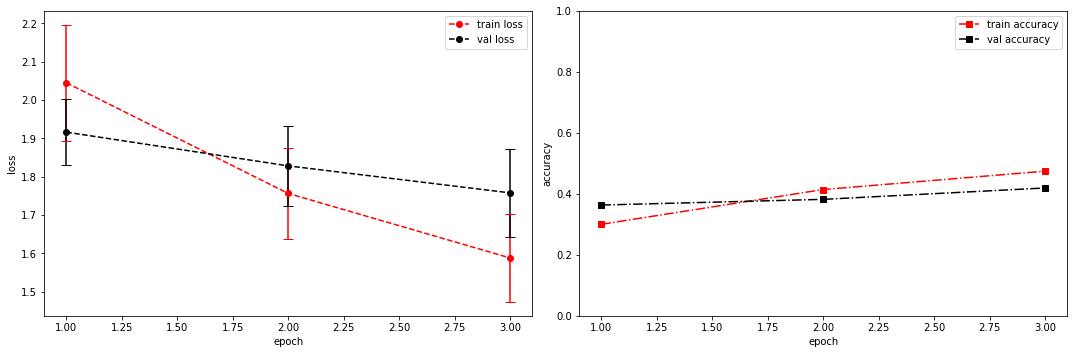

model saved


training epoch:  3
model set to train
Epoch [4/100], step [1/84],  Loss: 1.4613 +/- 0.0000,  accuracy: 0.0283203125, time elapsed = 0.32259535789489746s
Epoch [4/100], step [17/84],  Loss: 1.4199 +/- 0.1062,  accuracy: 0.5419921875, time elapsed = 1.1866390705108643s
Epoch [4/100], step [33/84],  Loss: 1.4215 +/- 0.1096,  accuracy: 0.525390625, time elapsed = 1.182852029800415s
Epoch [4/100], step [49/84],  Loss: 1.4253 +/- 0.1622,  accuracy: 0.5341796875, time elapsed = 1.1595993041992188s
Epoch [4/100], step [65/84],  Loss: 1.4428 +/- 0.1109,  accuracy: 0.5068359375, time elapsed = 1.1766090393066406s
Epoch [4/100], step [81/84],  Loss: 1.4342 +/- 0.1384,  accuracy: 0.5126953125, time elapsed = 1.1669437885284424s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.523,  precision = 0.523 recall = 0.523 f1 = 0.523 ::: val: acc = 0.422,  precision = 0.422 recall = 0.422 time elapsed = 8.065319538116455s


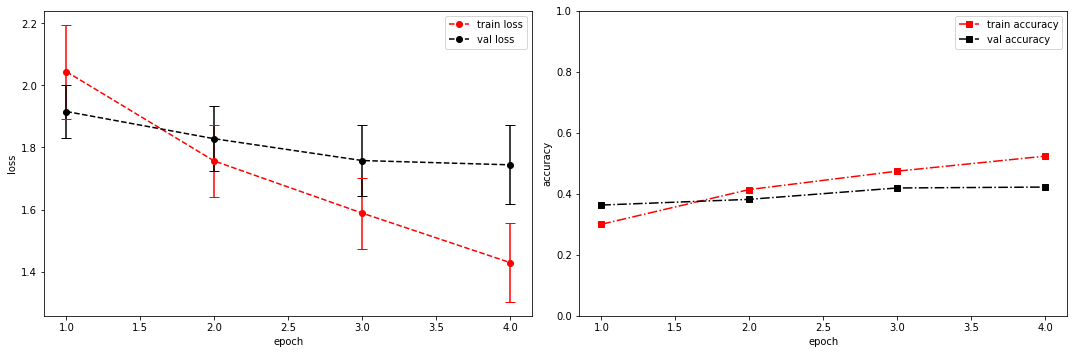

model saved


training epoch:  4
model set to train
Epoch [5/100], step [1/84],  Loss: 1.2422 +/- 0.0000,  accuracy: 0.037109375, time elapsed = 0.3052983283996582s
Epoch [5/100], step [17/84],  Loss: 1.2564 +/- 0.1148,  accuracy: 0.599609375, time elapsed = 1.2229225635528564s
Epoch [5/100], step [33/84],  Loss: 1.2758 +/- 0.1241,  accuracy: 0.58203125, time elapsed = 1.2021880149841309s
Epoch [5/100], step [49/84],  Loss: 1.2587 +/- 0.0897,  accuracy: 0.5830078125, time elapsed = 1.1901450157165527s
Epoch [5/100], step [65/84],  Loss: 1.2673 +/- 0.1050,  accuracy: 0.580078125, time elapsed = 1.186786413192749s
Epoch [5/100], step [81/84],  Loss: 1.2746 +/- 0.1347,  accuracy: 0.5703125, time elapsed = 1.164592981338501s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.584,  precision = 0.584 recall = 0.584 f1 = 0.584 ::: val: acc = 0.400,  precision = 0.400 recall = 0.400 time elapsed = 8.118311882019043s


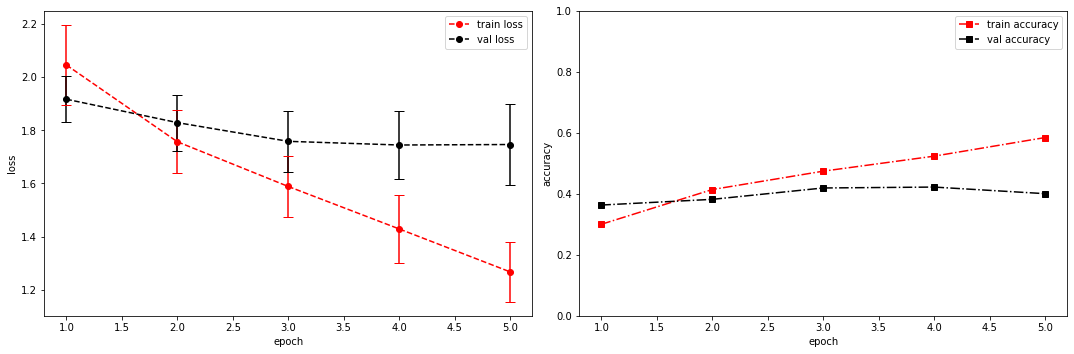

model saved
model saved


training epoch:  5
model set to train
Epoch [6/100], step [1/84],  Loss: 1.0579 +/- 0.0000,  accuracy: 0.0400390625, time elapsed = 0.2998676300048828s
Epoch [6/100], step [17/84],  Loss: 1.1093 +/- 0.1005,  accuracy: 0.650390625, time elapsed = 1.1899001598358154s
Epoch [6/100], step [33/84],  Loss: 1.0826 +/- 0.1274,  accuracy: 0.66015625, time elapsed = 1.1726560592651367s
Epoch [6/100], step [49/84],  Loss: 1.1740 +/- 0.1188,  accuracy: 0.6181640625, time elapsed = 1.1740164756774902s
Epoch [6/100], step [65/84],  Loss: 1.0903 +/- 0.1129,  accuracy: 0.642578125, time elapsed = 1.1669342517852783s
Epoch [6/100], step [81/84],  Loss: 1.1386 +/- 0.1147,  accuracy: 0.625, time elapsed = 1.1708693504333496s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.638,  precision = 0.638 recall = 0.638 f1 = 0.638 ::: val: acc = 0.429,  precision = 0.429 recall = 0.429 time elapsed = 8.068299770355225s


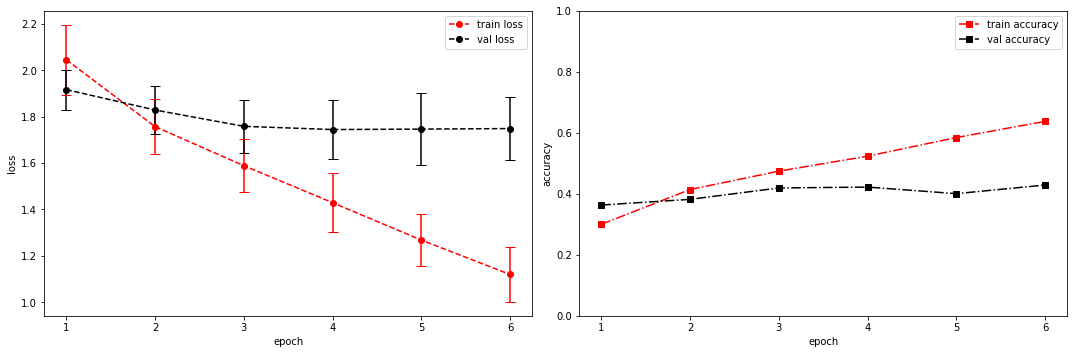

model saved
stopping early
device:  cuda
dataset metadata:  {'n_fft': 2048, 'hop_length': 256, 'n_mfcc': 13, 'notes': 'optional notes not passed'}
train model: data loaders initialized
sample shape =  (1, 13, 517)
model loaded
Layer (type:depth-idx)                   Output Shape              Param #
├─ConvBlock: 1-1                         [-1, 8, 6, 258]           --
|    └─Sequential: 2-1                   [-1, 8, 6, 258]           --
|    |    └─Conv2d: 3-1                  [-1, 8, 13, 517]          80
|    |    └─ReLU: 3-2                    [-1, 8, 13, 517]          --
|    |    └─MaxPool2d: 3-3               [-1, 8, 6, 258]           --
|    |    └─BatchNorm2d: 3-4             [-1, 8, 6, 258]           16
├─ConvBlock: 1-2                         [-1, 8, 3, 129]           --
|    └─Sequential: 2-2                   [-1, 8, 3, 129]           --
|    |    └─Conv2d: 3-5                  [-1, 8, 6, 258]           584
|    |    └─ReLU: 3-6                    [-1, 8, 6, 258]           

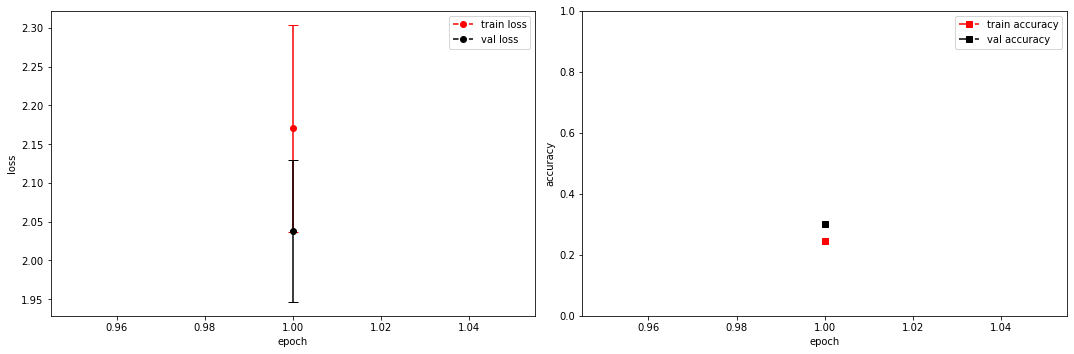

model saved


training epoch:  1
model set to train
Epoch [2/100], step [1/84],  Loss: 1.9254 +/- 0.0000,  accuracy: 0.0224609375, time elapsed = 0.29058241844177246s
Epoch [2/100], step [17/84],  Loss: 1.9860 +/- 0.1189,  accuracy: 0.322265625, time elapsed = 1.1793067455291748s
Epoch [2/100], step [33/84],  Loss: 1.9418 +/- 0.0755,  accuracy: 0.35546875, time elapsed = 1.1818015575408936s
Epoch [2/100], step [49/84],  Loss: 1.9332 +/- 0.0702,  accuracy: 0.34375, time elapsed = 1.172363519668579s
Epoch [2/100], step [65/84],  Loss: 1.9547 +/- 0.0920,  accuracy: 0.330078125, time elapsed = 1.2053892612457275s
Epoch [2/100], step [81/84],  Loss: 1.9425 +/- 0.1091,  accuracy: 0.3349609375, time elapsed = 1.1701583862304688s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.338,  precision = 0.338 recall = 0.338 f1 = 0.338 ::: val: acc = 0.343,  precision = 0.343 recall = 0.343 time elapsed = 8.053189277648926s


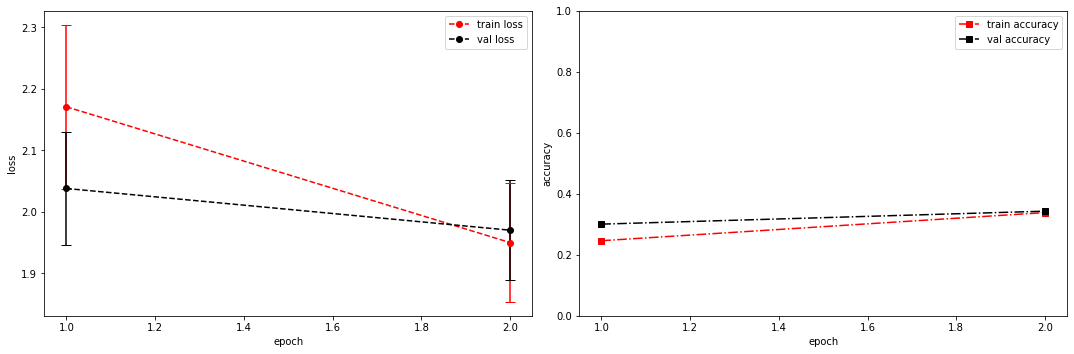

model saved


training epoch:  2
model set to train
Epoch [3/100], step [1/84],  Loss: 1.8282 +/- 0.0000,  accuracy: 0.025390625, time elapsed = 0.28182363510131836s
Epoch [3/100], step [17/84],  Loss: 1.8416 +/- 0.0711,  accuracy: 0.39453125, time elapsed = 1.1642768383026123s
Epoch [3/100], step [33/84],  Loss: 1.8323 +/- 0.1061,  accuracy: 0.3935546875, time elapsed = 1.1428594589233398s
Epoch [3/100], step [49/84],  Loss: 1.8780 +/- 0.0853,  accuracy: 0.3583984375, time elapsed = 1.1366040706634521s
Epoch [3/100], step [65/84],  Loss: 1.8508 +/- 0.1088,  accuracy: 0.37890625, time elapsed = 1.1508305072784424s
Epoch [3/100], step [81/84],  Loss: 1.8414 +/- 0.1038,  accuracy: 0.3828125, time elapsed = 1.2007942199707031s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.381,  precision = 0.381 recall = 0.381 f1 = 0.381 ::: val: acc = 0.351,  precision = 0.351 recall = 0.351 time elapsed = 7.9240734577178955s


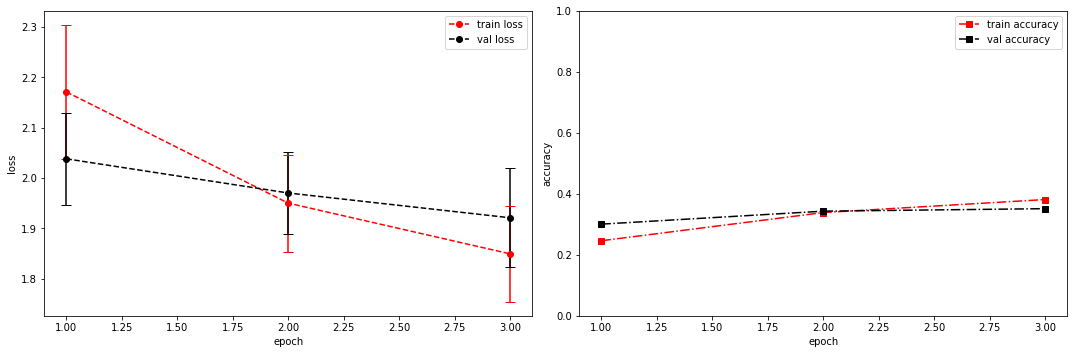

model saved


training epoch:  3
model set to train
Epoch [4/100], step [1/84],  Loss: 1.8268 +/- 0.0000,  accuracy: 0.0234375, time elapsed = 0.30164527893066406s
Epoch [4/100], step [17/84],  Loss: 1.7710 +/- 0.1084,  accuracy: 0.4052734375, time elapsed = 1.1593577861785889s
Epoch [4/100], step [33/84],  Loss: 1.7343 +/- 0.1097,  accuracy: 0.4306640625, time elapsed = 1.177480936050415s
Epoch [4/100], step [49/84],  Loss: 1.7529 +/- 0.1281,  accuracy: 0.421875, time elapsed = 1.1480367183685303s
Epoch [4/100], step [65/84],  Loss: 1.7977 +/- 0.1037,  accuracy: 0.3857421875, time elapsed = 1.1536059379577637s
Epoch [4/100], step [81/84],  Loss: 1.7201 +/- 0.0966,  accuracy: 0.42578125, time elapsed = 1.1776189804077148s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.413,  precision = 0.413 recall = 0.413 f1 = 0.413 ::: val: acc = 0.358,  precision = 0.358 recall = 0.358 time elapsed = 7.981558561325073s


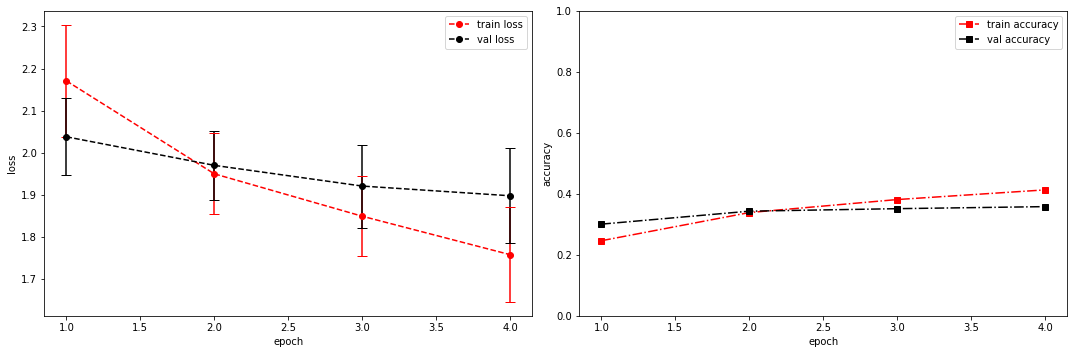

model saved


training epoch:  4
model set to train
Epoch [5/100], step [1/84],  Loss: 1.7712 +/- 0.0000,  accuracy: 0.0234375, time elapsed = 0.31359434127807617s
Epoch [5/100], step [17/84],  Loss: 1.6889 +/- 0.1091,  accuracy: 0.4462890625, time elapsed = 1.2076940536499023s
Epoch [5/100], step [33/84],  Loss: 1.6840 +/- 0.1009,  accuracy: 0.455078125, time elapsed = 1.1666598320007324s
Epoch [5/100], step [49/84],  Loss: 1.6650 +/- 0.0745,  accuracy: 0.466796875, time elapsed = 1.1679561138153076s
Epoch [5/100], step [65/84],  Loss: 1.7017 +/- 0.0730,  accuracy: 0.44140625, time elapsed = 1.17645263671875s
Epoch [5/100], step [81/84],  Loss: 1.6665 +/- 0.1228,  accuracy: 0.458984375, time elapsed = 1.172795057296753s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.452,  precision = 0.452 recall = 0.452 f1 = 0.452 ::: val: acc = 0.367,  precision = 0.367 recall = 0.367 time elapsed = 8.079637289047241s


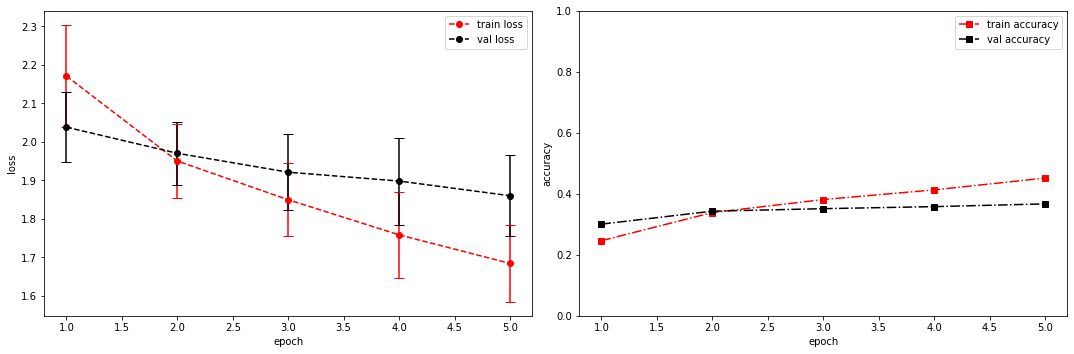

model saved
model saved


training epoch:  5
model set to train
Epoch [6/100], step [1/84],  Loss: 1.5939 +/- 0.0000,  accuracy: 0.03125, time elapsed = 0.2870597839355469s
Epoch [6/100], step [17/84],  Loss: 1.5952 +/- 0.0961,  accuracy: 0.4716796875, time elapsed = 1.2177479267120361s
Epoch [6/100], step [33/84],  Loss: 1.5982 +/- 0.1012,  accuracy: 0.48046875, time elapsed = 1.2432117462158203s
Epoch [6/100], step [49/84],  Loss: 1.6162 +/- 0.1277,  accuracy: 0.4765625, time elapsed = 1.172924280166626s
Epoch [6/100], step [65/84],  Loss: 1.5739 +/- 0.0907,  accuracy: 0.48828125, time elapsed = 1.1700127124786377s
Epoch [6/100], step [81/84],  Loss: 1.6032 +/- 0.0982,  accuracy: 0.4736328125, time elapsed = 1.1777698993682861s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.476,  precision = 0.476 recall = 0.476 f1 = 0.476 ::: val: acc = 0.380,  precision = 0.380 recall = 0.380 time elapsed = 8.112853527069092s


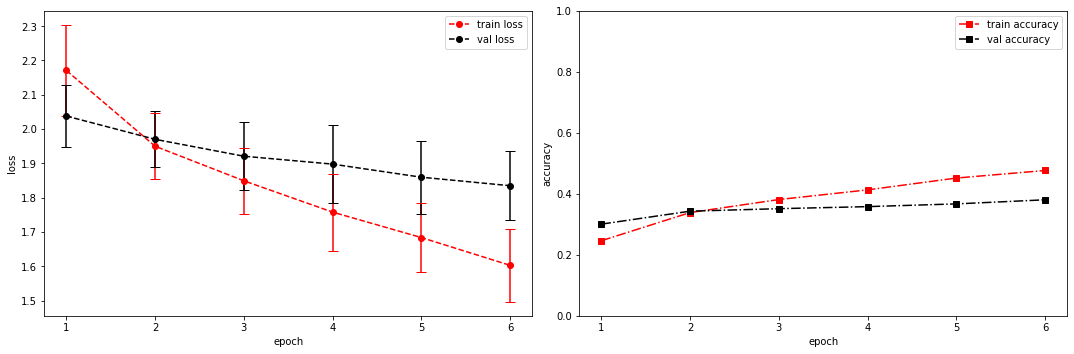

model saved
stopping early
device:  cuda
dataset metadata:  {'n_fft': 2048, 'hop_length': 256, 'n_mfcc': 13, 'notes': 'optional notes not passed'}
train model: data loaders initialized
sample shape =  (1, 13, 517)
model loaded
Layer (type:depth-idx)                   Output Shape              Param #
├─ConvBlock: 1-1                         [-1, 8, 6, 258]           --
|    └─Sequential: 2-1                   [-1, 8, 6, 258]           --
|    |    └─Conv2d: 3-1                  [-1, 8, 13, 517]          80
|    |    └─ReLU: 3-2                    [-1, 8, 13, 517]          --
|    |    └─MaxPool2d: 3-3               [-1, 8, 6, 258]           --
|    |    └─BatchNorm2d: 3-4             [-1, 8, 6, 258]           16
├─ConvBlock: 1-2                         [-1, 8, 3, 129]           --
|    └─Sequential: 2-2                   [-1, 8, 3, 129]           --
|    |    └─Conv2d: 3-5                  [-1, 8, 6, 258]           584
|    |    └─ReLU: 3-6                    [-1, 8, 6, 258]           

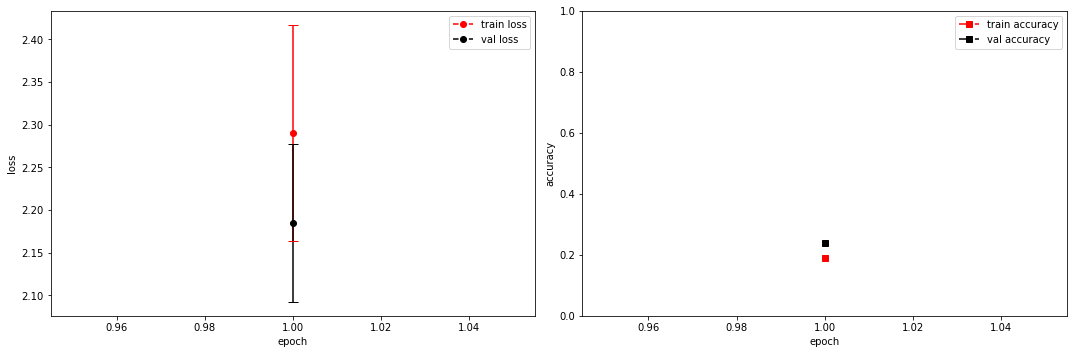

model saved


training epoch:  1
model set to train
Epoch [2/100], step [1/84],  Loss: 2.1675 +/- 0.0000,  accuracy: 0.0146484375, time elapsed = 0.29184556007385254s
Epoch [2/100], step [17/84],  Loss: 2.0911 +/- 0.0898,  accuracy: 0.251953125, time elapsed = 1.2161035537719727s
Epoch [2/100], step [33/84],  Loss: 2.1057 +/- 0.1126,  accuracy: 0.2607421875, time elapsed = 1.2023050785064697s
Epoch [2/100], step [49/84],  Loss: 2.0658 +/- 0.0793,  accuracy: 0.2900390625, time elapsed = 1.1982378959655762s
Epoch [2/100], step [65/84],  Loss: 2.0343 +/- 0.0783,  accuracy: 0.2958984375, time elapsed = 1.207735538482666s
Epoch [2/100], step [81/84],  Loss: 2.0535 +/- 0.0753,  accuracy: 0.294921875, time elapsed = 1.2168715000152588s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.280,  precision = 0.280 recall = 0.280 f1 = 0.280 ::: val: acc = 0.280,  precision = 0.280 recall = 0.280 time elapsed = 8.169737339019775s


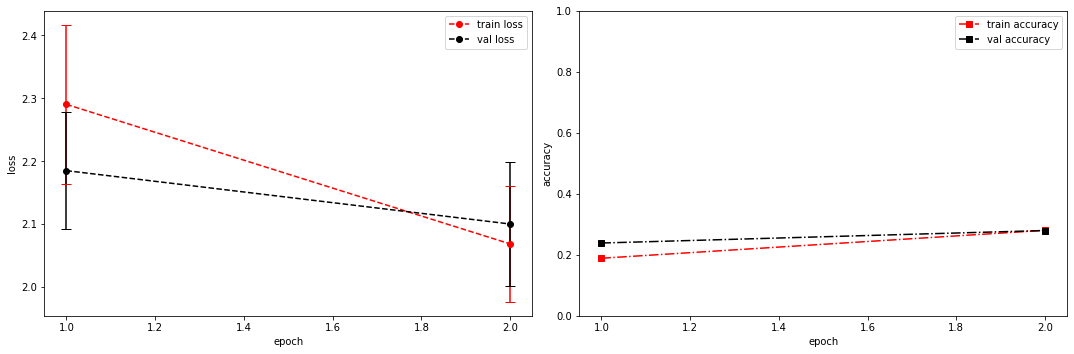

model saved


training epoch:  2
model set to train
Epoch [3/100], step [1/84],  Loss: 1.9761 +/- 0.0000,  accuracy: 0.0224609375, time elapsed = 0.2880828380584717s
Epoch [3/100], step [17/84],  Loss: 1.9633 +/- 0.0929,  accuracy: 0.349609375, time elapsed = 1.2283482551574707s
Epoch [3/100], step [33/84],  Loss: 1.9692 +/- 0.0873,  accuracy: 0.3369140625, time elapsed = 1.182258129119873s
Epoch [3/100], step [49/84],  Loss: 2.0037 +/- 0.0842,  accuracy: 0.3232421875, time elapsed = 1.1762378215789795s
Epoch [3/100], step [65/84],  Loss: 1.9548 +/- 0.0995,  accuracy: 0.337890625, time elapsed = 1.2068347930908203s
Epoch [3/100], step [81/84],  Loss: 1.9525 +/- 0.0870,  accuracy: 0.3291015625, time elapsed = 1.1613185405731201s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.339,  precision = 0.339 recall = 0.339 f1 = 0.339 ::: val: acc = 0.313,  precision = 0.313 recall = 0.313 time elapsed = 9.44910454750061s


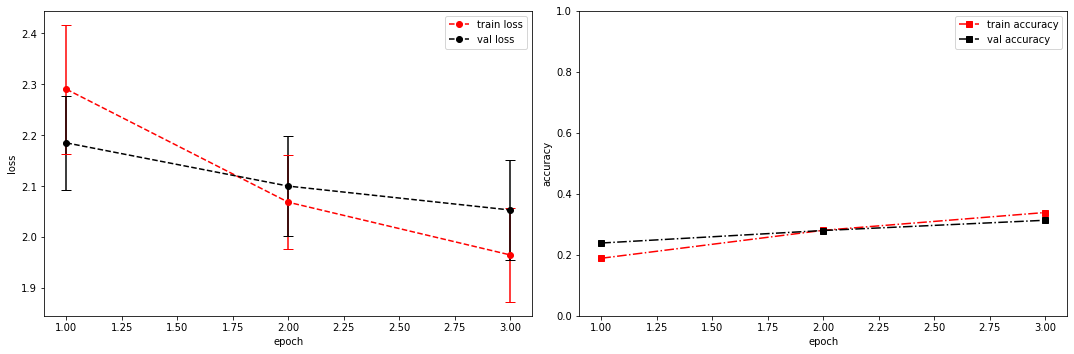

model saved


training epoch:  3
model set to train
Epoch [4/100], step [1/84],  Loss: 1.8742 +/- 0.0000,  accuracy: 0.0244140625, time elapsed = 0.30559229850769043s
Epoch [4/100], step [17/84],  Loss: 1.8833 +/- 0.0629,  accuracy: 0.3701171875, time elapsed = 1.228865146636963s
Epoch [4/100], step [33/84],  Loss: 1.9070 +/- 0.0961,  accuracy: 0.35546875, time elapsed = 1.1947252750396729s
Epoch [4/100], step [49/84],  Loss: 1.9234 +/- 0.0991,  accuracy: 0.3359375, time elapsed = 1.1994338035583496s
Epoch [4/100], step [65/84],  Loss: 1.9056 +/- 0.0702,  accuracy: 0.3564453125, time elapsed = 1.1710410118103027s
Epoch [4/100], step [81/84],  Loss: 1.8631 +/- 0.0763,  accuracy: 0.3828125, time elapsed = 1.1804537773132324s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.360,  precision = 0.360 recall = 0.360 f1 = 0.360 ::: val: acc = 0.333,  precision = 0.333 recall = 0.333 time elapsed = 8.165122509002686s


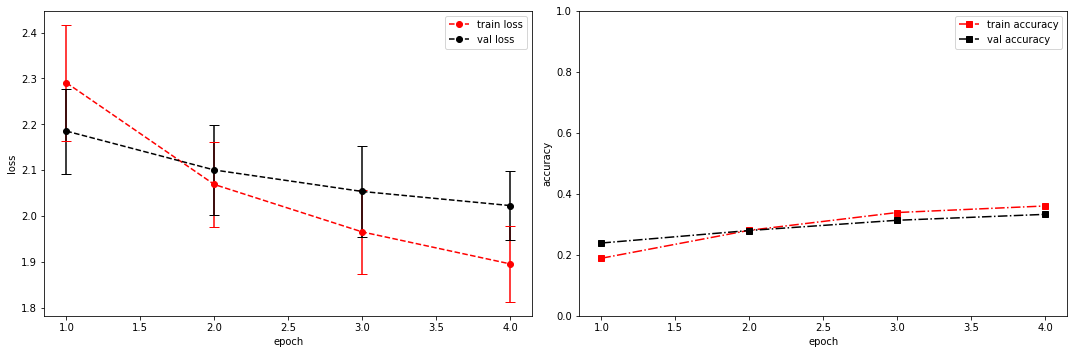

model saved


training epoch:  4
model set to train
Epoch [5/100], step [1/84],  Loss: 1.7353 +/- 0.0000,  accuracy: 0.0263671875, time elapsed = 0.30517077445983887s
Epoch [5/100], step [17/84],  Loss: 1.8103 +/- 0.0762,  accuracy: 0.41796875, time elapsed = 1.1936583518981934s
Epoch [5/100], step [33/84],  Loss: 1.8108 +/- 0.0820,  accuracy: 0.40625, time elapsed = 1.1850128173828125s
Epoch [5/100], step [49/84],  Loss: 1.8332 +/- 0.0984,  accuracy: 0.38671875, time elapsed = 1.1901991367340088s
Epoch [5/100], step [65/84],  Loss: 1.8698 +/- 0.0900,  accuracy: 0.361328125, time elapsed = 1.2145612239837646s
Epoch [5/100], step [81/84],  Loss: 1.8413 +/- 0.0804,  accuracy: 0.396484375, time elapsed = 1.1506147384643555s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.394,  precision = 0.394 recall = 0.394 f1 = 0.394 ::: val: acc = 0.333,  precision = 0.333 recall = 0.333 time elapsed = 8.082510232925415s


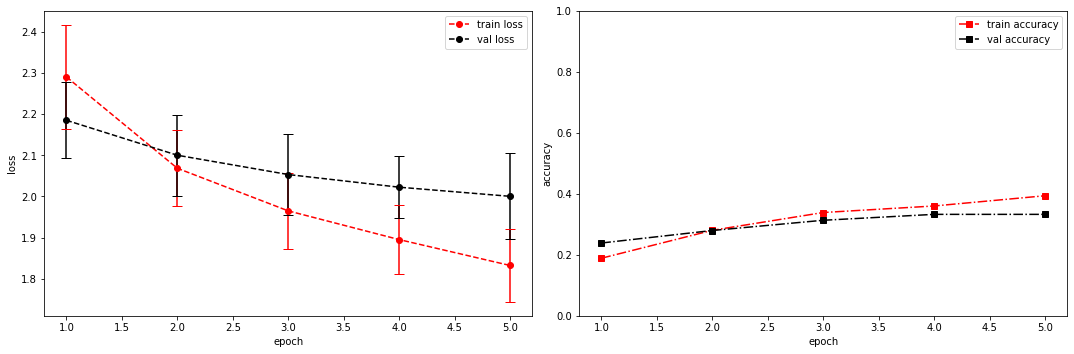

model saved
model saved


training epoch:  5
model set to train
Epoch [6/100], step [1/84],  Loss: 1.7918 +/- 0.0000,  accuracy: 0.0263671875, time elapsed = 0.28867506980895996s
Epoch [6/100], step [17/84],  Loss: 1.7811 +/- 0.0689,  accuracy: 0.3994140625, time elapsed = 1.2009015083312988s
Epoch [6/100], step [33/84],  Loss: 1.7778 +/- 0.1113,  accuracy: 0.4052734375, time elapsed = 1.1837165355682373s
Epoch [6/100], step [49/84],  Loss: 1.7909 +/- 0.1165,  accuracy: 0.4052734375, time elapsed = 1.1926283836364746s
Epoch [6/100], step [65/84],  Loss: 1.7645 +/- 0.1166,  accuracy: 0.4140625, time elapsed = 1.1814262866973877s
Epoch [6/100], step [81/84],  Loss: 1.7598 +/- 0.0895,  accuracy: 0.427734375, time elapsed = 1.1478948593139648s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.412,  precision = 0.412 recall = 0.412 f1 = 0.412 ::: val: acc = 0.346,  precision = 0.346 recall = 0.346 time elapsed = 8.077439546585083s


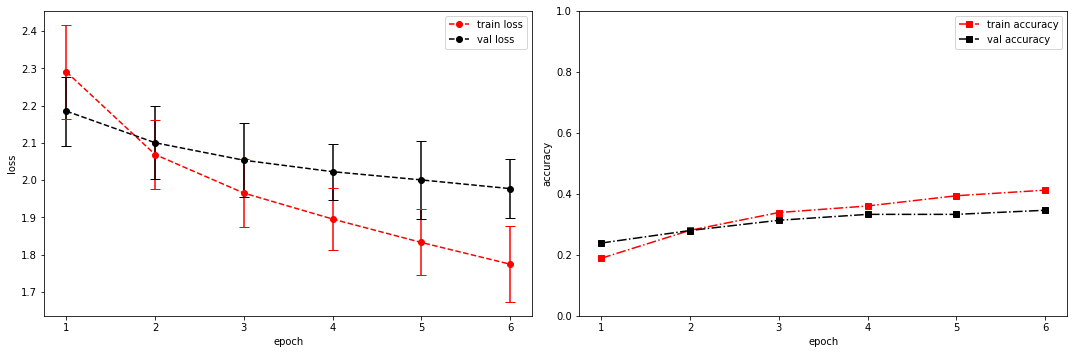

model saved
stopping early
device:  cuda
dataset metadata:  {'n_fft': 2048, 'hop_length': 256, 'n_mfcc': 13, 'notes': 'optional notes not passed'}
train model: data loaders initialized
sample shape =  (1, 13, 517)
model loaded
Layer (type:depth-idx)                   Output Shape              Param #
├─ConvBlock: 1-1                         [-1, 8, 6, 258]           --
|    └─Sequential: 2-1                   [-1, 8, 6, 258]           --
|    |    └─Conv2d: 3-1                  [-1, 8, 13, 517]          80
|    |    └─ReLU: 3-2                    [-1, 8, 13, 517]          --
|    |    └─MaxPool2d: 3-3               [-1, 8, 6, 258]           --
|    |    └─BatchNorm2d: 3-4             [-1, 8, 6, 258]           16
├─ConvBlock: 1-2                         [-1, 8, 3, 129]           --
|    └─Sequential: 2-2                   [-1, 8, 3, 129]           --
|    |    └─Conv2d: 3-5                  [-1, 8, 6, 258]           584
|    |    └─ReLU: 3-6                    [-1, 8, 6, 258]           

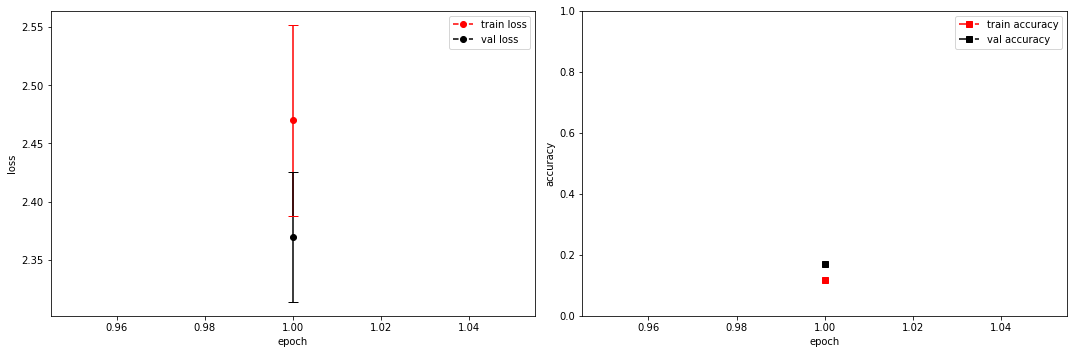

model saved


training epoch:  1
model set to train
Epoch [2/100], step [1/84],  Loss: 2.3606 +/- 0.0000,  accuracy: 0.0087890625, time elapsed = 0.2875325679779053s
Epoch [2/100], step [17/84],  Loss: 2.3558 +/- 0.0635,  accuracy: 0.1640625, time elapsed = 1.1974077224731445s
Epoch [2/100], step [33/84],  Loss: 2.3308 +/- 0.0560,  accuracy: 0.1865234375, time elapsed = 1.1742541790008545s
Epoch [2/100], step [49/84],  Loss: 2.3419 +/- 0.0658,  accuracy: 0.1865234375, time elapsed = 1.1663451194763184s
Epoch [2/100], step [65/84],  Loss: 2.2995 +/- 0.0753,  accuracy: 0.1865234375, time elapsed = 1.158247470855713s
Epoch [2/100], step [81/84],  Loss: 2.2887 +/- 0.0637,  accuracy: 0.1943359375, time elapsed = 1.1660122871398926s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.183,  precision = 0.183 recall = 0.183 f1 = 0.183 ::: val: acc = 0.213,  precision = 0.213 recall = 0.213 time elapsed = 8.025868892669678s


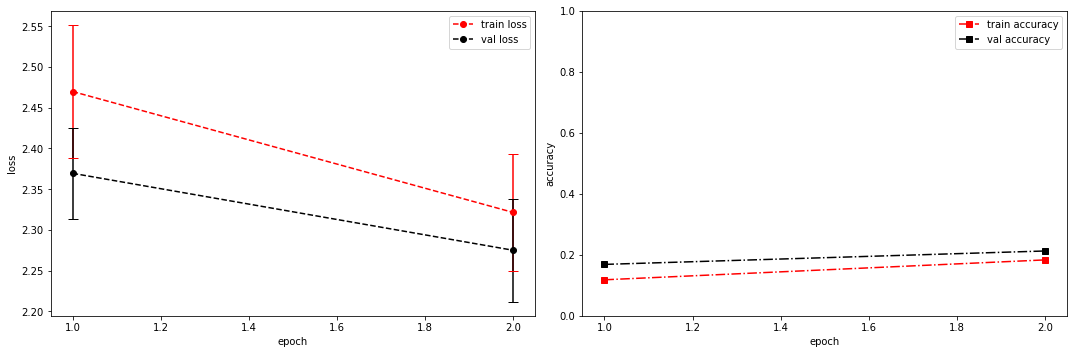

model saved


training epoch:  2
model set to train
Epoch [3/100], step [1/84],  Loss: 2.2346 +/- 0.0000,  accuracy: 0.0166015625, time elapsed = 0.29259824752807617s
Epoch [3/100], step [17/84],  Loss: 2.2294 +/- 0.0653,  accuracy: 0.2373046875, time elapsed = 1.1824591159820557s
Epoch [3/100], step [33/84],  Loss: 2.2440 +/- 0.0787,  accuracy: 0.203125, time elapsed = 1.1406176090240479s
Epoch [3/100], step [49/84],  Loss: 2.2304 +/- 0.0628,  accuracy: 0.2216796875, time elapsed = 1.162379264831543s
Epoch [3/100], step [65/84],  Loss: 2.2550 +/- 0.1006,  accuracy: 0.2294921875, time elapsed = 1.157590389251709s
Epoch [3/100], step [81/84],  Loss: 2.2114 +/- 0.0701,  accuracy: 0.236328125, time elapsed = 1.2005934715270996s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.226,  precision = 0.226 recall = 0.226 f1 = 0.226 ::: val: acc = 0.242,  precision = 0.242 recall = 0.242 time elapsed = 8.014759063720703s


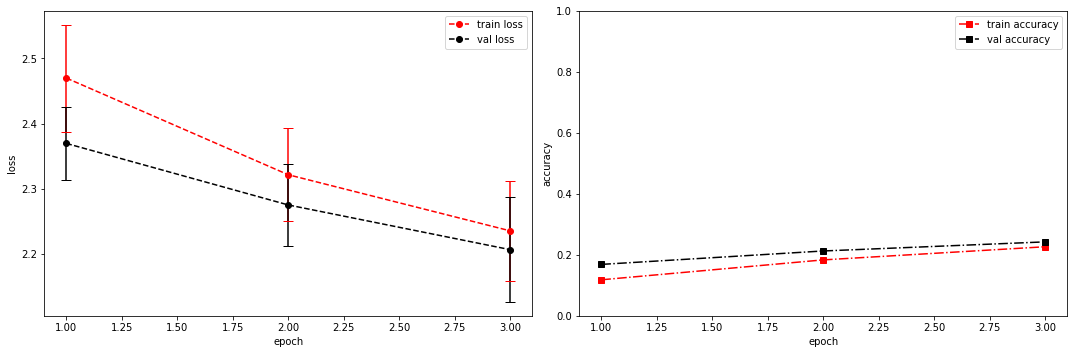

model saved


training epoch:  3
model set to train
Epoch [4/100], step [1/84],  Loss: 2.3530 +/- 0.0000,  accuracy: 0.0087890625, time elapsed = 0.3137481212615967s
Epoch [4/100], step [17/84],  Loss: 2.1464 +/- 0.0503,  accuracy: 0.279296875, time elapsed = 1.1786253452301025s
Epoch [4/100], step [33/84],  Loss: 2.1977 +/- 0.0754,  accuracy: 0.2158203125, time elapsed = 1.1670219898223877s
Epoch [4/100], step [49/84],  Loss: 2.1801 +/- 0.1118,  accuracy: 0.2353515625, time elapsed = 1.1606109142303467s
Epoch [4/100], step [65/84],  Loss: 2.1934 +/- 0.0956,  accuracy: 0.2451171875, time elapsed = 1.2081947326660156s
Epoch [4/100], step [81/84],  Loss: 2.1516 +/- 0.0665,  accuracy: 0.275390625, time elapsed = 1.1613588333129883s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.250,  precision = 0.250 recall = 0.250 f1 = 0.250 ::: val: acc = 0.257,  precision = 0.257 recall = 0.257 time elapsed = 8.078571796417236s


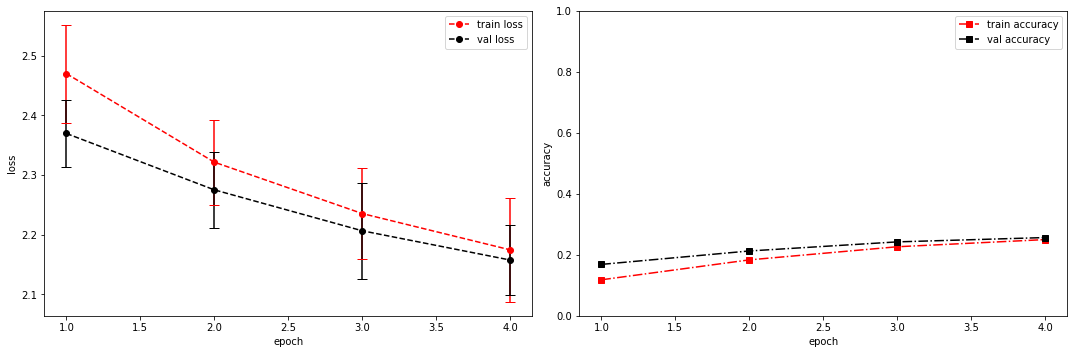

model saved


training epoch:  4
model set to train
Epoch [5/100], step [1/84],  Loss: 2.1472 +/- 0.0000,  accuracy: 0.0126953125, time elapsed = 0.29890966415405273s
Epoch [5/100], step [17/84],  Loss: 2.1455 +/- 0.0547,  accuracy: 0.2587890625, time elapsed = 1.2137532234191895s
Epoch [5/100], step [33/84],  Loss: 2.1258 +/- 0.0808,  accuracy: 0.259765625, time elapsed = 1.1932263374328613s
Epoch [5/100], step [49/84],  Loss: 2.1440 +/- 0.0750,  accuracy: 0.267578125, time elapsed = 1.1602413654327393s
Epoch [5/100], step [65/84],  Loss: 2.1063 +/- 0.0731,  accuracy: 0.279296875, time elapsed = 1.1713659763336182s
Epoch [5/100], step [81/84],  Loss: 2.1145 +/- 0.0961,  accuracy: 0.2744140625, time elapsed = 1.1499147415161133s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.266,  precision = 0.266 recall = 0.266 f1 = 0.266 ::: val: acc = 0.274,  precision = 0.274 recall = 0.274 time elapsed = 8.047691345214844s


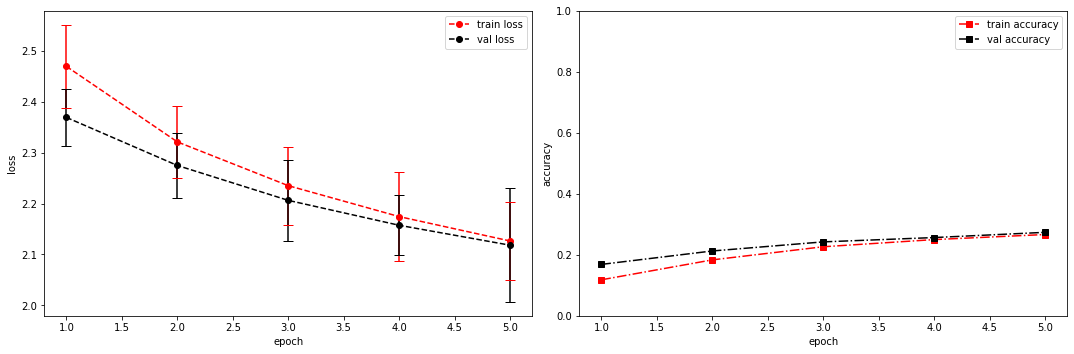

model saved


training epoch:  5
model set to train
Epoch [6/100], step [1/84],  Loss: 2.2573 +/- 0.0000,  accuracy: 0.015625, time elapsed = 0.3004872798919678s
Epoch [6/100], step [17/84],  Loss: 2.0801 +/- 0.0830,  accuracy: 0.2890625, time elapsed = 1.185878038406372s
Epoch [6/100], step [33/84],  Loss: 2.0746 +/- 0.0670,  accuracy: 0.2822265625, time elapsed = 1.1535687446594238s
Epoch [6/100], step [49/84],  Loss: 2.1187 +/- 0.0919,  accuracy: 0.2705078125, time elapsed = 1.1897449493408203s
Epoch [6/100], step [65/84],  Loss: 2.0375 +/- 0.1108,  accuracy: 0.3037109375, time elapsed = 1.1452555656433105s
Epoch [6/100], step [81/84],  Loss: 2.1272 +/- 0.0733,  accuracy: 0.26171875, time elapsed = 1.204056978225708s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.283,  precision = 0.283 recall = 0.283 f1 = 0.283 ::: val: acc = 0.287,  precision = 0.287 recall = 0.287 time elapsed = 8.011402606964111s


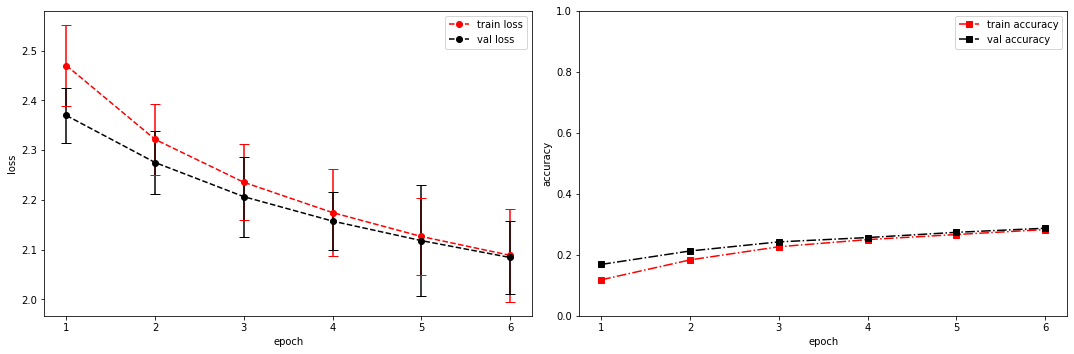

model saved


training epoch:  6
model set to train
Epoch [7/100], step [1/84],  Loss: 2.1190 +/- 0.0000,  accuracy: 0.01171875, time elapsed = 0.3027017116546631s
Epoch [7/100], step [17/84],  Loss: 2.0620 +/- 0.0916,  accuracy: 0.298828125, time elapsed = 1.2305288314819336s
Epoch [7/100], step [33/84],  Loss: 2.0351 +/- 0.1247,  accuracy: 0.2958984375, time elapsed = 1.197009563446045s
Epoch [7/100], step [49/84],  Loss: 2.0498 +/- 0.0952,  accuracy: 0.2890625, time elapsed = 1.1919054985046387s
Epoch [7/100], step [65/84],  Loss: 2.0647 +/- 0.0752,  accuracy: 0.287109375, time elapsed = 1.2347354888916016s
Epoch [7/100], step [81/84],  Loss: 2.0284 +/- 0.0842,  accuracy: 0.2880859375, time elapsed = 1.188047170639038s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.291,  precision = 0.291 recall = 0.291 f1 = 0.291 ::: val: acc = 0.295,  precision = 0.295 recall = 0.295 time elapsed = 8.243359088897705s


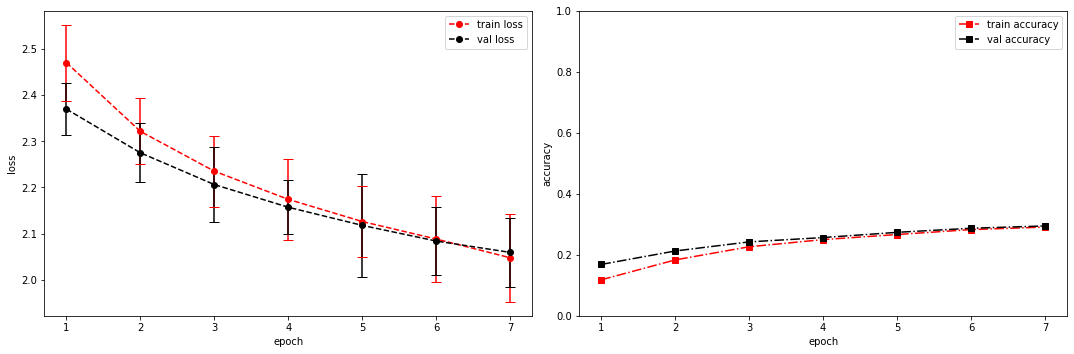

model saved


training epoch:  7
model set to train
Epoch [8/100], step [1/84],  Loss: 1.9511 +/- 0.0000,  accuracy: 0.0166015625, time elapsed = 0.2832908630371094s
Epoch [8/100], step [17/84],  Loss: 2.0266 +/- 0.0688,  accuracy: 0.30078125, time elapsed = 1.226689100265503s
Epoch [8/100], step [33/84],  Loss: 2.0261 +/- 0.0808,  accuracy: 0.2958984375, time elapsed = 1.1990466117858887s
Epoch [8/100], step [49/84],  Loss: 2.0099 +/- 0.0711,  accuracy: 0.302734375, time elapsed = 1.1809632778167725s
Epoch [8/100], step [65/84],  Loss: 2.0326 +/- 0.0876,  accuracy: 0.302734375, time elapsed = 1.1877021789550781s
Epoch [8/100], step [81/84],  Loss: 2.0158 +/- 0.0908,  accuracy: 0.3115234375, time elapsed = 1.175882339477539s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.304,  precision = 0.304 recall = 0.304 f1 = 0.304 ::: val: acc = 0.304,  precision = 0.304 recall = 0.304 time elapsed = 8.159930229187012s


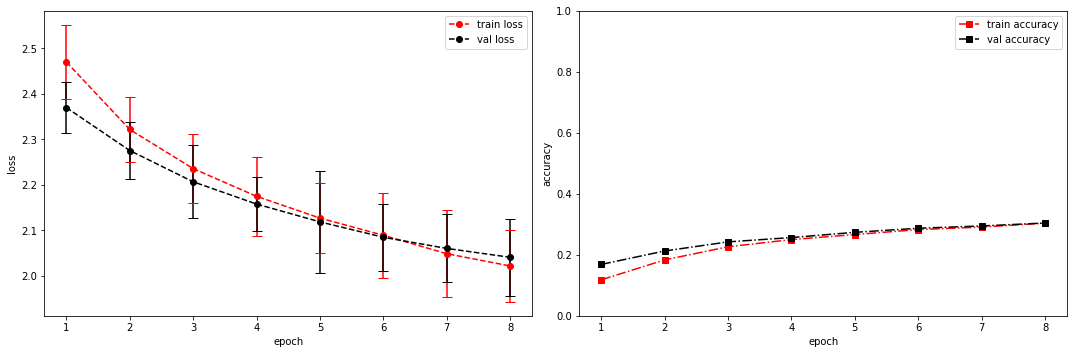

model saved


training epoch:  8
model set to train
Epoch [9/100], step [1/84],  Loss: 1.8218 +/- 0.0000,  accuracy: 0.025390625, time elapsed = 0.3251926898956299s
Epoch [9/100], step [17/84],  Loss: 2.0162 +/- 0.0736,  accuracy: 0.2958984375, time elapsed = 1.2022628784179688s
Epoch [9/100], step [33/84],  Loss: 1.9872 +/- 0.1011,  accuracy: 0.3212890625, time elapsed = 1.1635115146636963s
Epoch [9/100], step [49/84],  Loss: 1.9856 +/- 0.0905,  accuracy: 0.3447265625, time elapsed = 1.1839210987091064s
Epoch [9/100], step [65/84],  Loss: 2.0051 +/- 0.0640,  accuracy: 0.3125, time elapsed = 1.171245813369751s
Epoch [9/100], step [81/84],  Loss: 2.0028 +/- 0.1132,  accuracy: 0.3095703125, time elapsed = 1.1804141998291016s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.317,  precision = 0.317 recall = 0.317 f1 = 0.317 ::: val: acc = 0.324,  precision = 0.324 recall = 0.324 time elapsed = 8.093083143234253s


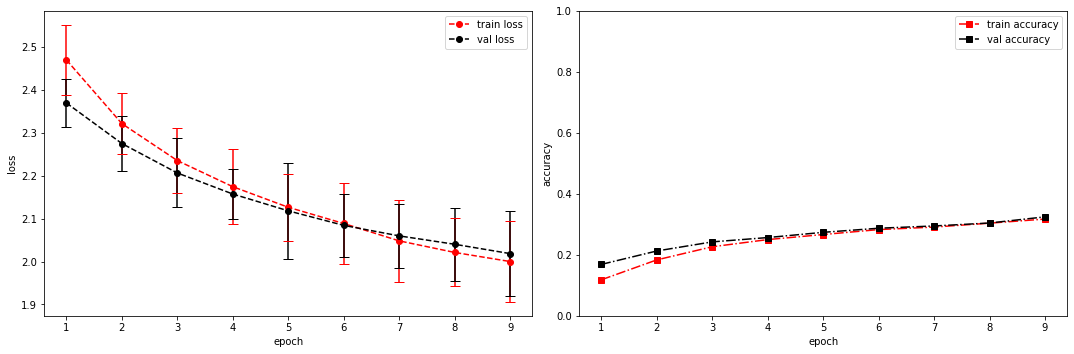

model saved


training epoch:  9
model set to train
Epoch [10/100], step [1/84],  Loss: 1.9904 +/- 0.0000,  accuracy: 0.0205078125, time elapsed = 0.2986721992492676s
Epoch [10/100], step [17/84],  Loss: 1.9742 +/- 0.0634,  accuracy: 0.3310546875, time elapsed = 1.1908562183380127s
Epoch [10/100], step [33/84],  Loss: 1.9774 +/- 0.0931,  accuracy: 0.328125, time elapsed = 1.18385910987854s
Epoch [10/100], step [49/84],  Loss: 1.9641 +/- 0.0716,  accuracy: 0.330078125, time elapsed = 1.1696181297302246s
Epoch [10/100], step [65/84],  Loss: 1.9799 +/- 0.0896,  accuracy: 0.3134765625, time elapsed = 1.1721417903900146s
Epoch [10/100], step [81/84],  Loss: 1.9998 +/- 0.0879,  accuracy: 0.330078125, time elapsed = 1.1958057880401611s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.326,  precision = 0.326 recall = 0.326 f1 = 0.326 ::: val: acc = 0.327,  precision = 0.327 recall = 0.327 time elapsed = 8.090545654296875s


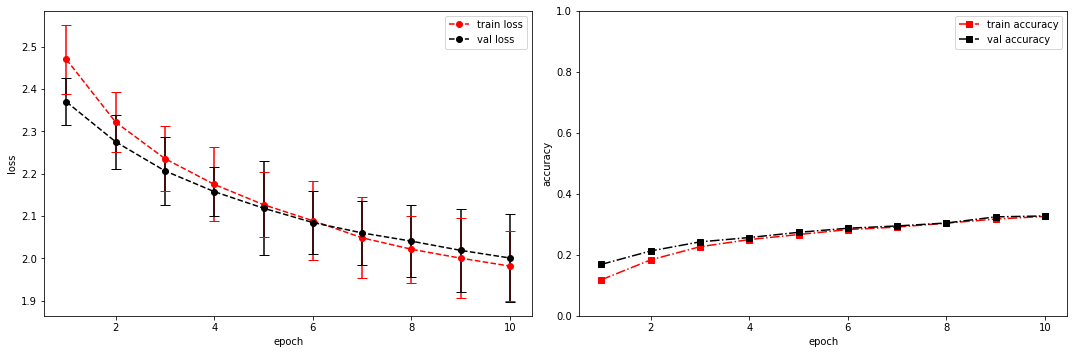

model saved


training epoch:  10
model set to train
Epoch [11/100], step [1/84],  Loss: 1.8025 +/- 0.0000,  accuracy: 0.025390625, time elapsed = 0.30225372314453125s
Epoch [11/100], step [17/84],  Loss: 1.9509 +/- 0.0817,  accuracy: 0.322265625, time elapsed = 1.1932423114776611s
Epoch [11/100], step [33/84],  Loss: 1.9804 +/- 0.1003,  accuracy: 0.32421875, time elapsed = 1.2060842514038086s
Epoch [11/100], step [49/84],  Loss: 1.9405 +/- 0.0671,  accuracy: 0.330078125, time elapsed = 1.1919581890106201s
Epoch [11/100], step [65/84],  Loss: 1.9592 +/- 0.0870,  accuracy: 0.32421875, time elapsed = 1.2272167205810547s
Epoch [11/100], step [81/84],  Loss: 1.9517 +/- 0.0770,  accuracy: 0.3525390625, time elapsed = 1.1564695835113525s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.332,  precision = 0.332 recall = 0.332 f1 = 0.332 ::: val: acc = 0.333,  precision = 0.333 recall = 0.333 time elapsed = 8.136770486831665s


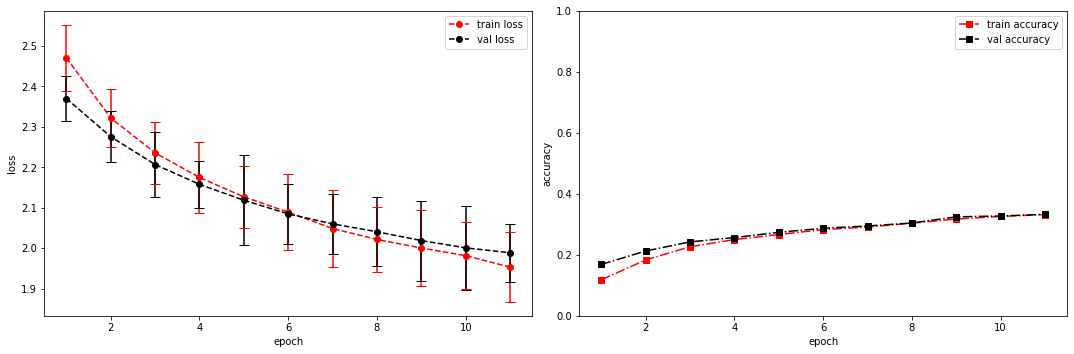

model saved


training epoch:  11
model set to train
Epoch [12/100], step [1/84],  Loss: 2.0681 +/- 0.0000,  accuracy: 0.01953125, time elapsed = 0.3270242214202881s
Epoch [12/100], step [17/84],  Loss: 1.9248 +/- 0.0769,  accuracy: 0.3505859375, time elapsed = 1.1952450275421143s
Epoch [12/100], step [33/84],  Loss: 1.9195 +/- 0.0717,  accuracy: 0.3505859375, time elapsed = 1.176689624786377s
Epoch [12/100], step [49/84],  Loss: 1.9297 +/- 0.1022,  accuracy: 0.3408203125, time elapsed = 1.1838021278381348s
Epoch [12/100], step [65/84],  Loss: 1.9509 +/- 0.0676,  accuracy: 0.3310546875, time elapsed = 1.2028388977050781s
Epoch [12/100], step [81/84],  Loss: 1.9528 +/- 0.0760,  accuracy: 0.326171875, time elapsed = 1.1842374801635742s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.339,  precision = 0.339 recall = 0.339 f1 = 0.339 ::: val: acc = 0.336,  precision = 0.336 recall = 0.336 time elapsed = 8.139730215072632s


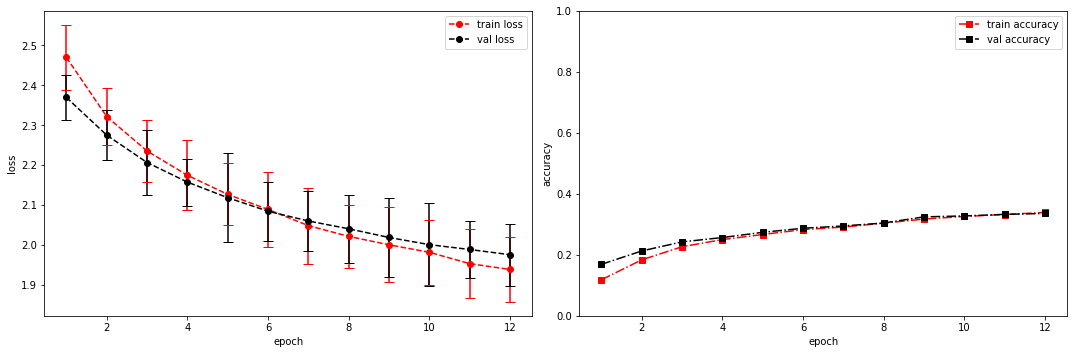

model saved


training epoch:  12
model set to train
Epoch [13/100], step [1/84],  Loss: 1.8735 +/- 0.0000,  accuracy: 0.01953125, time elapsed = 0.3200969696044922s
Epoch [13/100], step [17/84],  Loss: 1.9216 +/- 0.0986,  accuracy: 0.3564453125, time elapsed = 2.5856332778930664s
Epoch [13/100], step [33/84],  Loss: 1.9046 +/- 0.1254,  accuracy: 0.375, time elapsed = 1.1804008483886719s
Epoch [13/100], step [49/84],  Loss: 1.9589 +/- 0.0989,  accuracy: 0.3193359375, time elapsed = 1.1715950965881348s
Epoch [13/100], step [65/84],  Loss: 1.9122 +/- 0.0725,  accuracy: 0.3388671875, time elapsed = 1.1625192165374756s
Epoch [13/100], step [81/84],  Loss: 1.8829 +/- 0.0893,  accuracy: 0.3828125, time elapsed = 2.2726213932037354s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.353,  precision = 0.353 recall = 0.353 f1 = 0.353 ::: val: acc = 0.344,  precision = 0.344 recall = 0.344 time elapsed = 10.568194150924683s


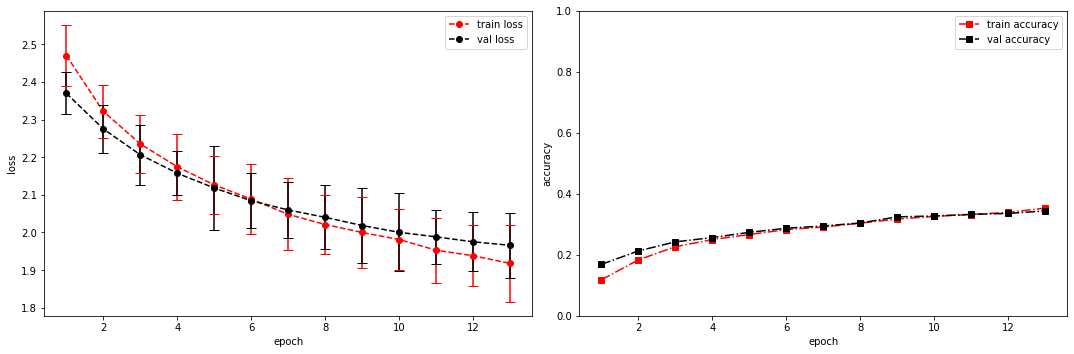

model saved


training epoch:  13
model set to train
Epoch [14/100], step [1/84],  Loss: 1.9032 +/- 0.0000,  accuracy: 0.021484375, time elapsed = 0.3078467845916748s
Epoch [14/100], step [17/84],  Loss: 1.8953 +/- 0.1057,  accuracy: 0.353515625, time elapsed = 1.1971642971038818s
Epoch [14/100], step [33/84],  Loss: 1.9054 +/- 0.0668,  accuracy: 0.35546875, time elapsed = 1.1766908168792725s
Epoch [14/100], step [49/84],  Loss: 1.8962 +/- 0.0750,  accuracy: 0.359375, time elapsed = 1.2044949531555176s
Epoch [14/100], step [65/84],  Loss: 1.9190 +/- 0.0737,  accuracy: 0.3525390625, time elapsed = 1.2094836235046387s
Epoch [14/100], step [81/84],  Loss: 1.9020 +/- 0.0850,  accuracy: 0.361328125, time elapsed = 1.180314064025879s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.356,  precision = 0.356 recall = 0.356 f1 = 0.356 ::: val: acc = 0.341,  precision = 0.341 recall = 0.341 time elapsed = 8.166618824005127s


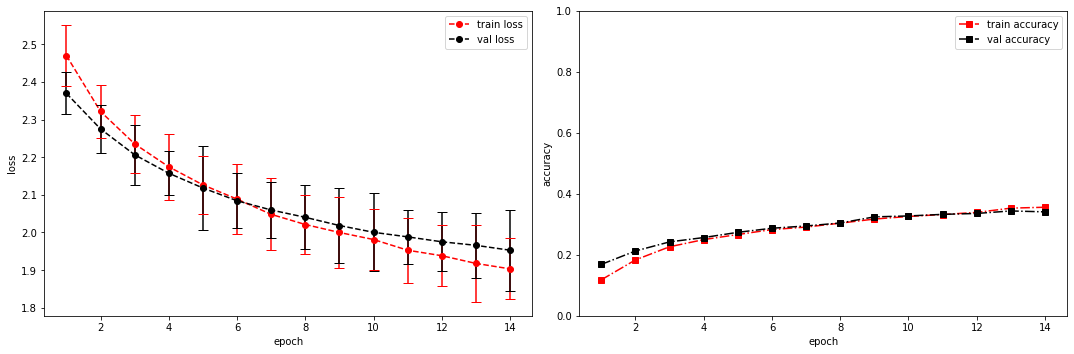

model saved


training epoch:  14
model set to train
Epoch [15/100], step [1/84],  Loss: 1.9263 +/- 0.0000,  accuracy: 0.021484375, time elapsed = 0.31574487686157227s
Epoch [15/100], step [17/84],  Loss: 1.8640 +/- 0.0607,  accuracy: 0.361328125, time elapsed = 1.1835155487060547s
Epoch [15/100], step [33/84],  Loss: 1.8810 +/- 0.0877,  accuracy: 0.3720703125, time elapsed = 1.165384292602539s
Epoch [15/100], step [49/84],  Loss: 1.8926 +/- 0.0958,  accuracy: 0.369140625, time elapsed = 1.1824095249176025s
Epoch [15/100], step [65/84],  Loss: 1.9187 +/- 0.0941,  accuracy: 0.34375, time elapsed = 1.2051990032196045s
Epoch [15/100], step [81/84],  Loss: 1.8729 +/- 0.0737,  accuracy: 0.3759765625, time elapsed = 1.1857762336730957s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.367,  precision = 0.367 recall = 0.367 f1 = 0.367 ::: val: acc = 0.343,  precision = 0.343 recall = 0.343 time elapsed = 8.103941917419434s


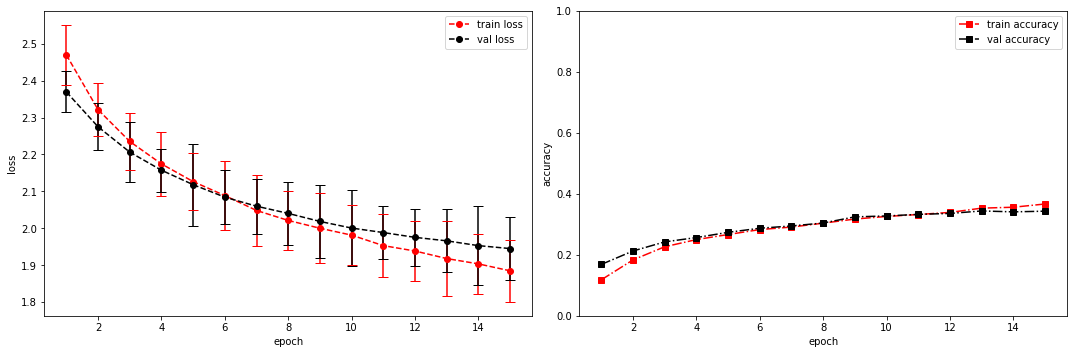

model saved


training epoch:  15
model set to train
Epoch [16/100], step [1/84],  Loss: 1.8774 +/- 0.0000,  accuracy: 0.0205078125, time elapsed = 0.3137094974517822s
Epoch [16/100], step [17/84],  Loss: 1.8194 +/- 0.0973,  accuracy: 0.40234375, time elapsed = 1.1826086044311523s
Epoch [16/100], step [33/84],  Loss: 1.9079 +/- 0.0507,  accuracy: 0.3369140625, time elapsed = 1.1631860733032227s
Epoch [16/100], step [49/84],  Loss: 1.8669 +/- 0.0936,  accuracy: 0.3671875, time elapsed = 1.2333683967590332s
Epoch [16/100], step [65/84],  Loss: 1.8582 +/- 0.1122,  accuracy: 0.375, time elapsed = 1.1781682968139648s
Epoch [16/100], step [81/84],  Loss: 1.9142 +/- 0.1046,  accuracy: 0.357421875, time elapsed = 1.1896321773529053s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.367,  precision = 0.367 recall = 0.367 f1 = 0.367 ::: val: acc = 0.347,  precision = 0.347 recall = 0.347 time elapsed = 8.142350673675537s


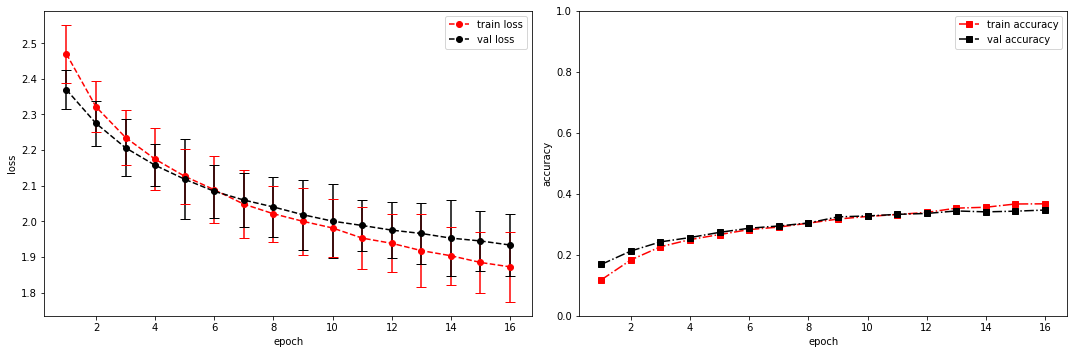

model saved


training epoch:  16
model set to train
Epoch [17/100], step [1/84],  Loss: 1.6679 +/- 0.0000,  accuracy: 0.02734375, time elapsed = 0.30756521224975586s
Epoch [17/100], step [17/84],  Loss: 1.8540 +/- 0.0819,  accuracy: 0.3828125, time elapsed = 1.2028279304504395s
Epoch [17/100], step [33/84],  Loss: 1.8655 +/- 0.1141,  accuracy: 0.37109375, time elapsed = 1.1900062561035156s
Epoch [17/100], step [49/84],  Loss: 1.8450 +/- 0.1034,  accuracy: 0.3740234375, time elapsed = 1.158884048461914s
Epoch [17/100], step [65/84],  Loss: 1.8258 +/- 0.1082,  accuracy: 0.3974609375, time elapsed = 1.1877391338348389s
Epoch [17/100], step [81/84],  Loss: 1.8860 +/- 0.1137,  accuracy: 0.3544921875, time elapsed = 1.189596176147461s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.377,  precision = 0.377 recall = 0.377 f1 = 0.377 ::: val: acc = 0.345,  precision = 0.345 recall = 0.345 time elapsed = 8.076717615127563s


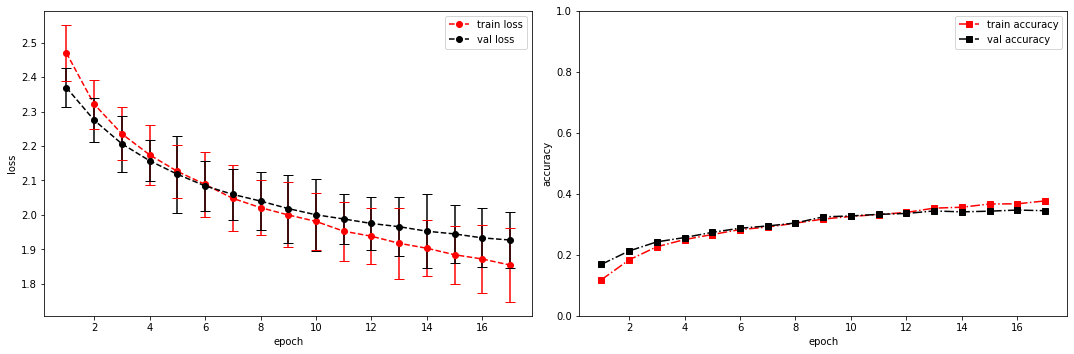

model saved


training epoch:  17
model set to train
Epoch [18/100], step [1/84],  Loss: 2.0121 +/- 0.0000,  accuracy: 0.0205078125, time elapsed = 0.3384404182434082s
Epoch [18/100], step [17/84],  Loss: 1.8294 +/- 0.0987,  accuracy: 0.380859375, time elapsed = 1.175044059753418s
Epoch [18/100], step [33/84],  Loss: 1.8591 +/- 0.1004,  accuracy: 0.37890625, time elapsed = 1.1659114360809326s
Epoch [18/100], step [49/84],  Loss: 1.8646 +/- 0.0821,  accuracy: 0.34765625, time elapsed = 1.1632637977600098s
Epoch [18/100], step [65/84],  Loss: 1.7929 +/- 0.0761,  accuracy: 0.3955078125, time elapsed = 1.1598684787750244s
Epoch [18/100], step [81/84],  Loss: 1.8231 +/- 0.1002,  accuracy: 0.39453125, time elapsed = 1.1952934265136719s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.379,  precision = 0.379 recall = 0.379 f1 = 0.379 ::: val: acc = 0.354,  precision = 0.354 recall = 0.354 time elapsed = 8.06058406829834s


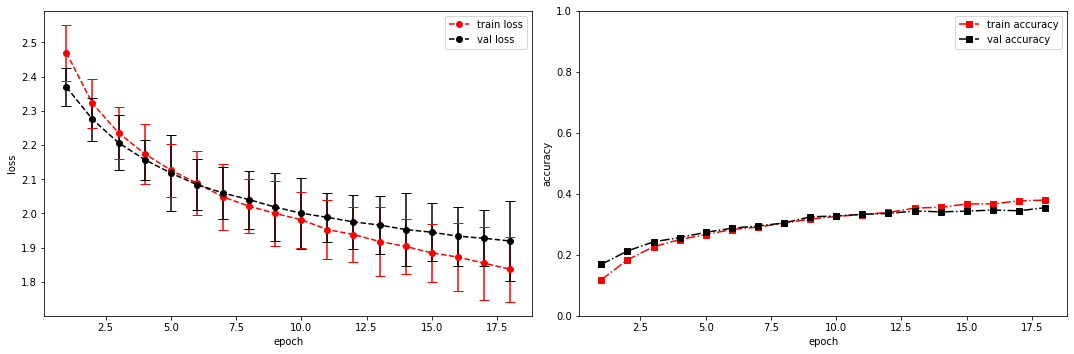

model saved


training epoch:  18
model set to train
Epoch [19/100], step [1/84],  Loss: 1.9561 +/- 0.0000,  accuracy: 0.021484375, time elapsed = 0.29636573791503906s
Epoch [19/100], step [17/84],  Loss: 1.8145 +/- 0.0698,  accuracy: 0.3837890625, time elapsed = 1.1533622741699219s
Epoch [19/100], step [33/84],  Loss: 1.8288 +/- 0.0774,  accuracy: 0.396484375, time elapsed = 1.1875298023223877s
Epoch [19/100], step [49/84],  Loss: 1.8237 +/- 0.0825,  accuracy: 0.392578125, time elapsed = 1.1883726119995117s
Epoch [19/100], step [65/84],  Loss: 1.8455 +/- 0.0943,  accuracy: 0.37890625, time elapsed = 1.1495656967163086s
Epoch [19/100], step [81/84],  Loss: 1.8202 +/- 0.1072,  accuracy: 0.376953125, time elapsed = 1.1622612476348877s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.385,  precision = 0.385 recall = 0.385 f1 = 0.385 ::: val: acc = 0.356,  precision = 0.356 recall = 0.356 time elapsed = 8.005584001541138s


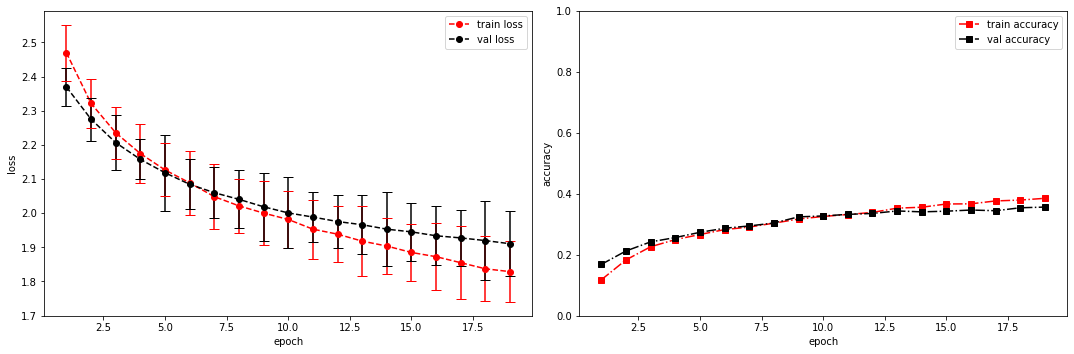

model saved


training epoch:  19
model set to train
Epoch [20/100], step [1/84],  Loss: 1.8536 +/- 0.0000,  accuracy: 0.029296875, time elapsed = 0.3142373561859131s
Epoch [20/100], step [17/84],  Loss: 1.7940 +/- 0.1204,  accuracy: 0.400390625, time elapsed = 1.204951286315918s
Epoch [20/100], step [33/84],  Loss: 1.8388 +/- 0.1039,  accuracy: 0.380859375, time elapsed = 1.1947276592254639s
Epoch [20/100], step [49/84],  Loss: 1.8240 +/- 0.0848,  accuracy: 0.3916015625, time elapsed = 1.2127881050109863s
Epoch [20/100], step [65/84],  Loss: 1.7936 +/- 0.1154,  accuracy: 0.396484375, time elapsed = 1.1825752258300781s
Epoch [20/100], step [81/84],  Loss: 1.7993 +/- 0.0894,  accuracy: 0.408203125, time elapsed = 1.1991963386535645s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.397,  precision = 0.397 recall = 0.397 f1 = 0.397 ::: val: acc = 0.359,  precision = 0.359 recall = 0.359 time elapsed = 8.144043684005737s


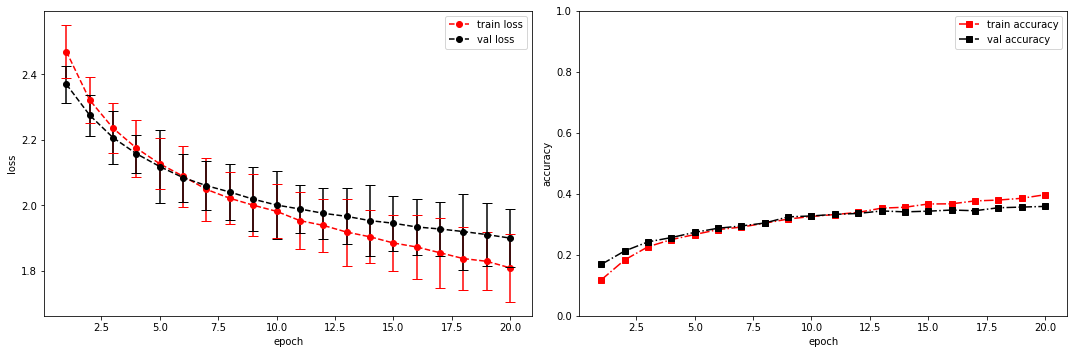

model saved


training epoch:  20
model set to train
Epoch [21/100], step [1/84],  Loss: 1.8024 +/- 0.0000,  accuracy: 0.02734375, time elapsed = 0.2975475788116455s
Epoch [21/100], step [17/84],  Loss: 1.8316 +/- 0.0830,  accuracy: 0.396484375, time elapsed = 1.190664529800415s
Epoch [21/100], step [33/84],  Loss: 1.7440 +/- 0.0774,  accuracy: 0.443359375, time elapsed = 1.2198851108551025s
Epoch [21/100], step [49/84],  Loss: 1.7957 +/- 0.0875,  accuracy: 0.4013671875, time elapsed = 1.1860392093658447s
Epoch [21/100], step [65/84],  Loss: 1.7829 +/- 0.0712,  accuracy: 0.390625, time elapsed = 1.1872022151947021s
Epoch [21/100], step [81/84],  Loss: 1.8192 +/- 0.0576,  accuracy: 0.380859375, time elapsed = 1.2064979076385498s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.403,  precision = 0.403 recall = 0.403 f1 = 0.403 ::: val: acc = 0.349,  precision = 0.349 recall = 0.349 time elapsed = 8.12853479385376s


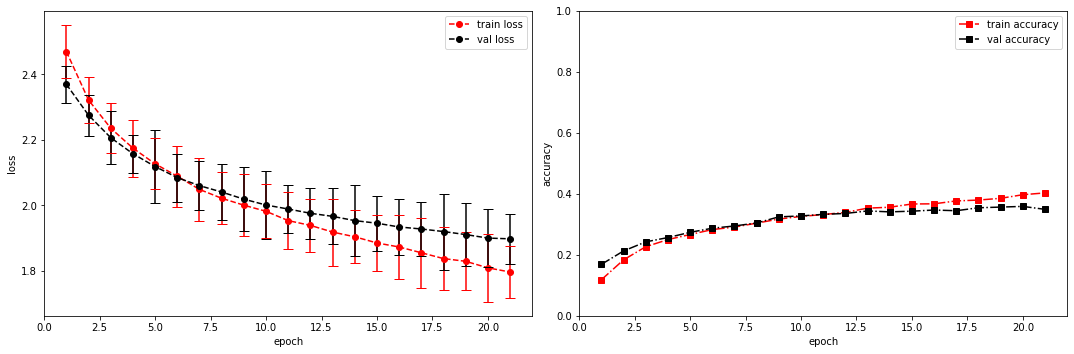

model saved


training epoch:  21
model set to train
Epoch [22/100], step [1/84],  Loss: 1.7101 +/- 0.0000,  accuracy: 0.029296875, time elapsed = 0.3110837936401367s
Epoch [22/100], step [17/84],  Loss: 1.7911 +/- 0.0869,  accuracy: 0.40234375, time elapsed = 1.1816213130950928s
Epoch [22/100], step [33/84],  Loss: 1.7696 +/- 0.0907,  accuracy: 0.4130859375, time elapsed = 1.1601967811584473s
Epoch [22/100], step [49/84],  Loss: 1.7845 +/- 0.0803,  accuracy: 0.38671875, time elapsed = 1.2206909656524658s
Epoch [22/100], step [65/84],  Loss: 1.7972 +/- 0.0841,  accuracy: 0.3955078125, time elapsed = 1.1856558322906494s
Epoch [22/100], step [81/84],  Loss: 1.7861 +/- 0.1221,  accuracy: 0.408203125, time elapsed = 1.1768555641174316s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.404,  precision = 0.404 recall = 0.404 f1 = 0.404 ::: val: acc = 0.361,  precision = 0.361 recall = 0.361 time elapsed = 8.14228343963623s


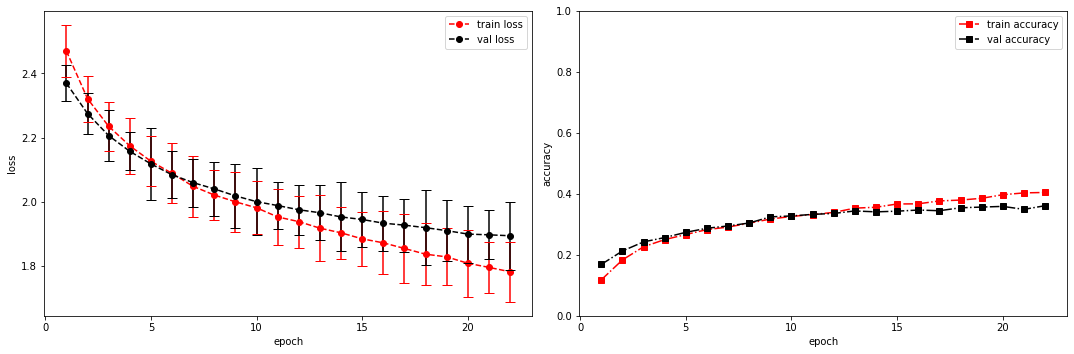

model saved


training epoch:  22
model set to train
Epoch [23/100], step [1/84],  Loss: 1.8293 +/- 0.0000,  accuracy: 0.0244140625, time elapsed = 0.31021809577941895s
Epoch [23/100], step [17/84],  Loss: 1.7676 +/- 0.0838,  accuracy: 0.4013671875, time elapsed = 1.1850364208221436s
Epoch [23/100], step [33/84],  Loss: 1.7651 +/- 0.0834,  accuracy: 0.412109375, time elapsed = 1.1795082092285156s
Epoch [23/100], step [49/84],  Loss: 1.7670 +/- 0.1053,  accuracy: 0.427734375, time elapsed = 1.2070331573486328s
Epoch [23/100], step [65/84],  Loss: 1.7678 +/- 0.0634,  accuracy: 0.4013671875, time elapsed = 1.174391746520996s
Epoch [23/100], step [81/84],  Loss: 1.7970 +/- 0.0883,  accuracy: 0.3974609375, time elapsed = 1.1771831512451172s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.407,  precision = 0.407 recall = 0.407 f1 = 0.407 ::: val: acc = 0.362,  precision = 0.362 recall = 0.362 time elapsed = 8.098455429077148s


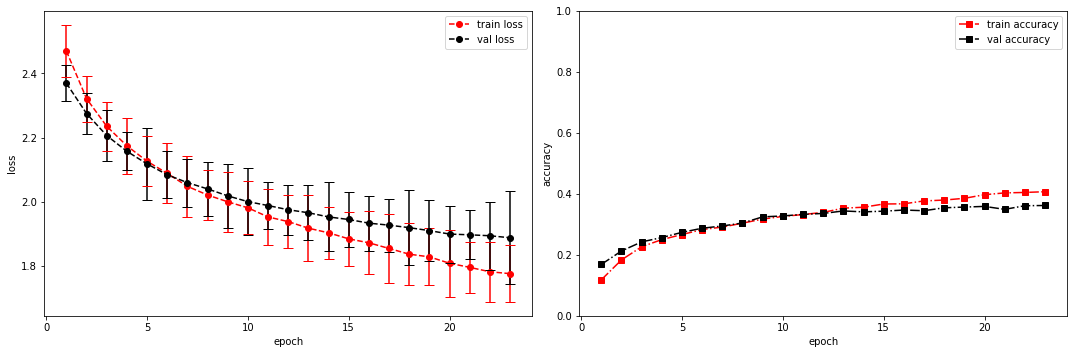

model saved


training epoch:  23
model set to train
Epoch [24/100], step [1/84],  Loss: 1.8410 +/- 0.0000,  accuracy: 0.02734375, time elapsed = 0.33106088638305664s
Epoch [24/100], step [17/84],  Loss: 1.7658 +/- 0.0898,  accuracy: 0.4130859375, time elapsed = 1.2073841094970703s
Epoch [24/100], step [33/84],  Loss: 1.7612 +/- 0.0926,  accuracy: 0.412109375, time elapsed = 1.178035020828247s
Epoch [24/100], step [49/84],  Loss: 1.7425 +/- 0.0886,  accuracy: 0.4287109375, time elapsed = 1.1491129398345947s
Epoch [24/100], step [65/84],  Loss: 1.7627 +/- 0.0856,  accuracy: 0.404296875, time elapsed = 1.1895203590393066s
Epoch [24/100], step [81/84],  Loss: 1.7654 +/- 0.0683,  accuracy: 0.4296875, time elapsed = 1.1856842041015625s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.418,  precision = 0.418 recall = 0.418 f1 = 0.418 ::: val: acc = 0.371,  precision = 0.371 recall = 0.371 time elapsed = 8.106698274612427s


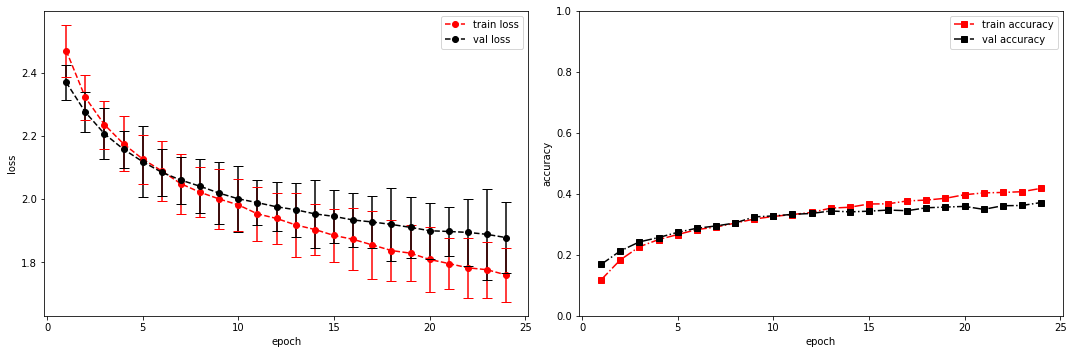

model saved


training epoch:  24
model set to train
Epoch [25/100], step [1/84],  Loss: 1.9506 +/- 0.0000,  accuracy: 0.01953125, time elapsed = 0.30471181869506836s
Epoch [25/100], step [17/84],  Loss: 1.7446 +/- 0.0826,  accuracy: 0.4345703125, time elapsed = 1.1680219173431396s
Epoch [25/100], step [33/84],  Loss: 1.7711 +/- 0.0868,  accuracy: 0.41015625, time elapsed = 1.232414960861206s
Epoch [25/100], step [49/84],  Loss: 1.7476 +/- 0.1049,  accuracy: 0.41015625, time elapsed = 1.2071678638458252s
Epoch [25/100], step [65/84],  Loss: 1.7121 +/- 0.1169,  accuracy: 0.44140625, time elapsed = 1.2045180797576904s
Epoch [25/100], step [81/84],  Loss: 1.7346 +/- 0.0784,  accuracy: 0.4208984375, time elapsed = 1.1812994480133057s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.421,  precision = 0.421 recall = 0.421 f1 = 0.421 ::: val: acc = 0.371,  precision = 0.371 recall = 0.371 time elapsed = 8.187372207641602s


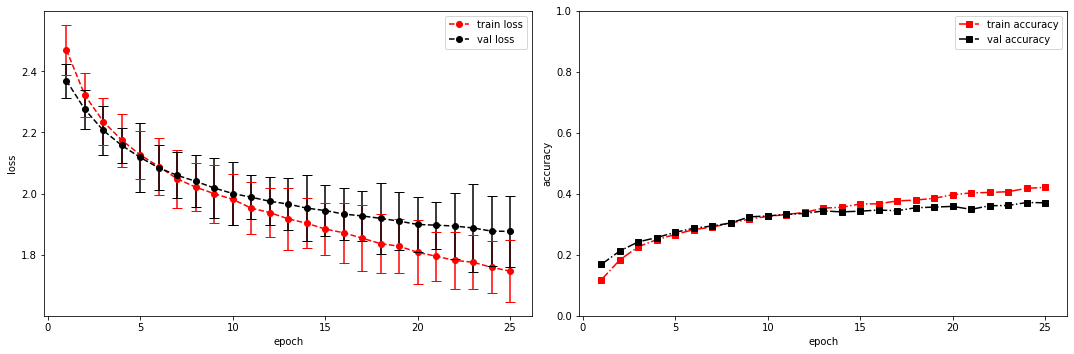

model saved


training epoch:  25
model set to train
Epoch [26/100], step [1/84],  Loss: 1.7527 +/- 0.0000,  accuracy: 0.02734375, time elapsed = 0.3231534957885742s
Epoch [26/100], step [17/84],  Loss: 1.7277 +/- 0.1088,  accuracy: 0.435546875, time elapsed = 1.1980974674224854s
Epoch [26/100], step [33/84],  Loss: 1.7582 +/- 0.0774,  accuracy: 0.4189453125, time elapsed = 1.1828641891479492s
Epoch [26/100], step [49/84],  Loss: 1.7247 +/- 0.0995,  accuracy: 0.431640625, time elapsed = 1.2255537509918213s
Epoch [26/100], step [65/84],  Loss: 1.7397 +/- 0.0638,  accuracy: 0.4306640625, time elapsed = 1.221935749053955s
Epoch [26/100], step [81/84],  Loss: 1.7096 +/- 0.0920,  accuracy: 0.4443359375, time elapsed = 1.1534199714660645s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.431,  precision = 0.431 recall = 0.431 f1 = 0.431 ::: val: acc = 0.370,  precision = 0.370 recall = 0.370 time elapsed = 8.153278112411499s


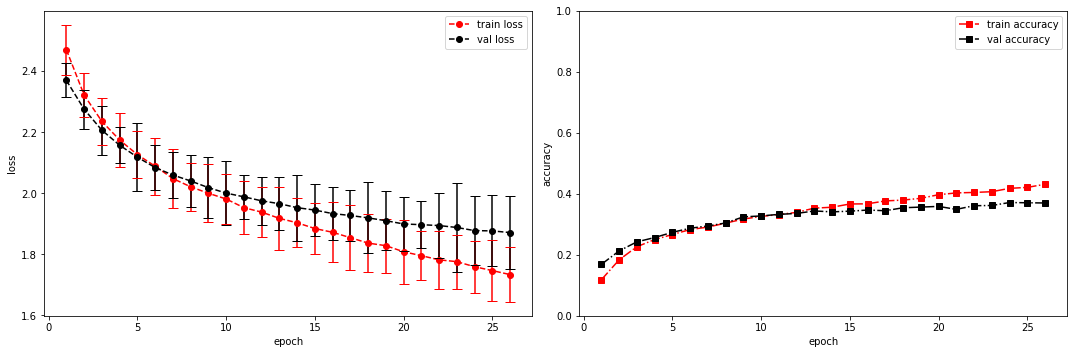

model saved


training epoch:  26
model set to train
Epoch [27/100], step [1/84],  Loss: 1.6817 +/- 0.0000,  accuracy: 0.03125, time elapsed = 0.3201429843902588s
Epoch [27/100], step [17/84],  Loss: 1.7338 +/- 0.0897,  accuracy: 0.4306640625, time elapsed = 1.2349188327789307s
Epoch [27/100], step [33/84],  Loss: 1.7220 +/- 0.0935,  accuracy: 0.4482421875, time elapsed = 1.208235263824463s
Epoch [27/100], step [49/84],  Loss: 1.7239 +/- 0.1018,  accuracy: 0.4453125, time elapsed = 1.1575424671173096s
Epoch [27/100], step [65/84],  Loss: 1.7170 +/- 0.0853,  accuracy: 0.44921875, time elapsed = 1.1814522743225098s
Epoch [27/100], step [81/84],  Loss: 1.7283 +/- 0.0895,  accuracy: 0.44921875, time elapsed = 1.1826741695404053s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.445,  precision = 0.445 recall = 0.445 f1 = 0.445 ::: val: acc = 0.373,  precision = 0.373 recall = 0.373 time elapsed = 8.178970575332642s


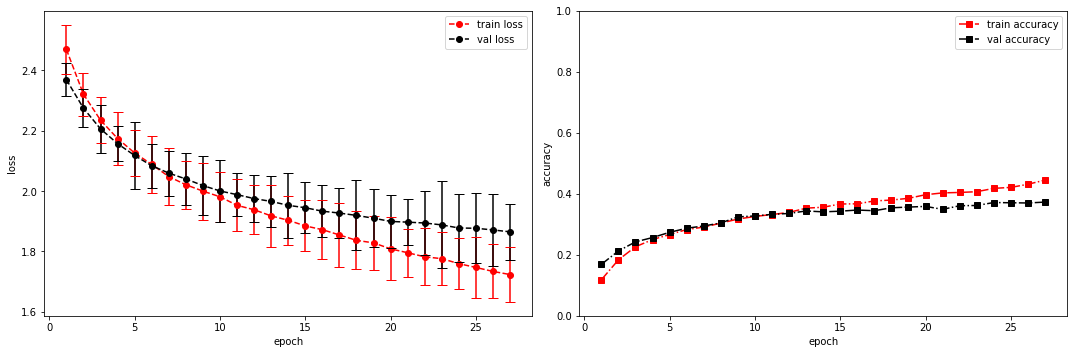

model saved
model saved


training epoch:  27
model set to train
Epoch [28/100], step [1/84],  Loss: 1.8784 +/- 0.0000,  accuracy: 0.0166015625, time elapsed = 0.30248475074768066s
Epoch [28/100], step [17/84],  Loss: 1.7290 +/- 0.0957,  accuracy: 0.4267578125, time elapsed = 1.1900300979614258s
Epoch [28/100], step [33/84],  Loss: 1.7405 +/- 0.0788,  accuracy: 0.4189453125, time elapsed = 1.1869194507598877s
Epoch [28/100], step [49/84],  Loss: 1.7023 +/- 0.0791,  accuracy: 0.447265625, time elapsed = 1.1805570125579834s
Epoch [28/100], step [65/84],  Loss: 1.6936 +/- 0.1041,  accuracy: 0.43359375, time elapsed = 1.2023603916168213s
Epoch [28/100], step [81/84],  Loss: 1.7220 +/- 0.0514,  accuracy: 0.439453125, time elapsed = 1.2127032279968262s
model set to eval

EPOCH FINISHED: ,  training: acc = 0.431,  precision = 0.431 recall = 0.431 f1 = 0.431 ::: val: acc = 0.374,  precision = 0.374 recall = 0.374 time elapsed = 8.160360097885132s


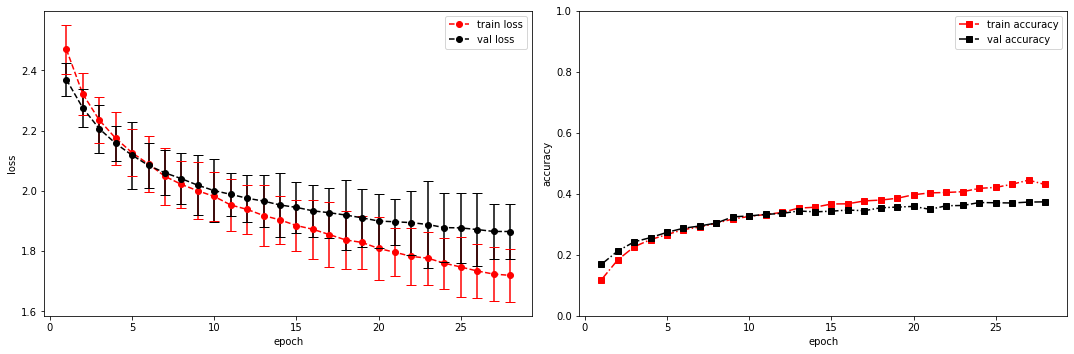

model saved
stopping early


In [8]:
CHECKPOINT_ROOT = "/content/drive/MyDrive/ITCS 5156 project/trained_models/Learning_rate/"

model_args = {
	"channels": [8, 8, 32, 32, 64],
	"conv_kernel_sizes": [3, 3, 3, 3, 3],
	"conv_strides": [1, 1, 1, 1, 1],
	"conv_paddings": [1, 1, 1, 1, 1],
	"pool_masks": [True, True, True, True, True],
	"pool_kernel_sizes": [2, 2, 2, (1, 2), (1, 2)],
	"pool_strides": [2, 2, 2, (1, 2), (1, 2)],
	"linear_features": [128, 64],
	"dropout_probs": [0, 0],
}

args_dict = {
	"filename": filename, 
	"model_id": "Conv_5_layer",
	"num_epochs": 100,
	"interval": 16,
	#"lr": 0.001,
	"batch_size": 64,
	"val_split": 0.2,
	"save_checkpoint": True,
	"criterion": nn.CrossEntropyLoss(),
	"patience": 2,
	"min_epochs": 3,
	"buffer": 0.05,
	"model_args": model_args,
  'checkpoint_path': CHECKPOINT_ROOT,
}

learning_rates = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]
for lr in learning_rates:
  args_dict['lr'] = lr
  args_dict['checkpoint_name'] = "conv_net_lr_{}.pt".format(lr)
  args_dict['notes'] = dedent("""
  varying learning rate, lr = {}

  other hyperparams:
  id: Conv_5_layer
  max_epochs: 100
  interval: 16
  batch_size: 64
  val_split: 0.2
  criterion: CrossEntropyLoss
  """.format(lr))
  args_dict['experiment_params'] = {
      'learning_rate': lr
  }
  train_model(**args_dict)